In [103]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from torchvision.models import vgg16
import os
from PIL import Image
from sklearn.model_selection import train_test_split

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [104]:
# Dataset Load and split

# 96 eyes, 49 OCT images, 2 visits, 16 biomarkers (binary)
# 96 eyes, 49 OCT images, 2 visits, 496 x 504 OCT images (grayscale)
scan_N = 9408
oct_N = 49
eye_N = 96
sh = [496, 504]

# csv_file = '~/scratch/OLIVES/OLIVES/Biomarker_Clinical_Data_Images_Updated.csv'
csv_file = '/storage/ice1/shared/d-pace_community/makerspace-datasets/MEDICAL/OLIVES/OLIVES/Biomarker_Clinical_Data_Images.csv'
data = pd.read_csv(csv_file)
col_names = data.columns
file_paths = data['Path (Trial/Arm/Folder/Visit/Eye/Image Name)'].values #[9408,]
file_paths = file_paths.reshape([eye_N,2*oct_N])
bio_markers = data[col_names[2:18]].values
bio_markers = bio_markers.reshape([eye_N,2*oct_N,-1])

clin_data = data[col_names[19:21]].values
clin_data = clin_data.reshape([eye_N,2*oct_N,-1])

home_dir = '/storage/ice1/shared/d-pace_community/makerspace-datasets/MEDICAL/OLIVES/OLIVES'

In [105]:
# Check for rows with Nan and identify the rows (get rid of them after Data split)
rows_with_nan = data[data.isna().any(axis=1)]
# data = data.dropna()

In [106]:

########## Preprocessing ###########################
model_name = 'vgg16'
input_dim = 224 # Input size for VGG16
transform_vgg = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.CenterCrop(496),
    transforms.Resize((224,224)),                # 224x224 or 384x384
    transforms.ToTensor(),                        # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalize with ImageNet stats
        std=[0.229, 0.224, 0.225])
])

#####################################################

class OCTDataset(Dataset):
    def __init__(self, file_paths, labels, clin_data, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.clin_data = clin_data

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        # Dynamically replace 'TREX DME' with 'TREX_DME' in the file path
        corrected_path = self.file_paths[index][0].replace('TREX DME', 'TREX_DME')
        img = Image.open(home_dir + corrected_path).convert("L")
        label = self.labels[index]  # Shape: [sample N, bio_marker_N]
        
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(label, dtype=torch.float32)
        clin = torch.tensor(self.clin_data[index], dtype=torch.float32)
        return img, label, clin

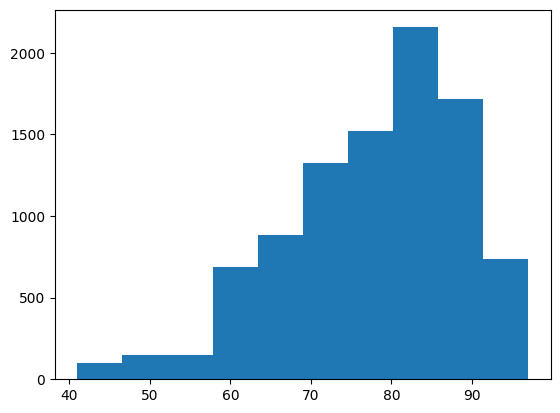

77.71354166666667 10.929043109528417
334.9270833333333 117.8748227987062


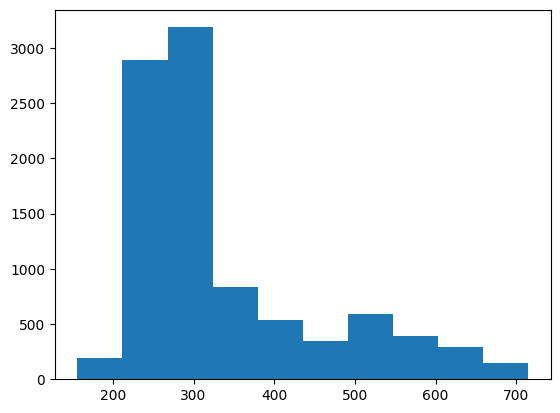

In [107]:
import matplotlib.pyplot as plt
plt.hist(clin_data[:,:,0].flatten())
plt.show()
plt.hist(clin_data[:,:,1].flatten())
zero = clin_data[:,:,0].flatten()
one = clin_data[:,:,1].flatten()
print( np.mean(zero), np.std(zero))
print(np.mean(one), np.std(one))

In [75]:
'''
Data setup - No Stratification (OCT + clinical label)

'''

# Eye-wise split
# Split dataset into train/val/test

# Clinical data (96,98,2)
train_val_files, test_files, train_val_labels, test_labels, train_val_clin, test_clin = train_test_split(
    file_paths, bio_markers, clin_data, test_size=0.2, random_state=42
)

train_files, val_files, train_labels, val_labels, train_clin, val_clin = train_test_split(
    train_val_files, train_val_labels, train_val_clin, test_size=0.25, random_state=42
)
print(train_files.shape, val_files.shape, test_files.shape)
# Eye-wise -> scan-wise
train_files = train_files.reshape([-1,1])
val_files = val_files.reshape([-1,1])
test_files = test_files.reshape([-1,1])

train_labels = train_labels.reshape([-1,16])
val_labels = val_labels.reshape([-1,16])
test_labels = test_labels.reshape([-1,16])

train_clin = train_clin.reshape([-1,2])
val_clin = val_clin.reshape([-1,2])
test_clin = test_clin.reshape([-1,2])

######## Get rid of data points with Nan values #########
train_nan = ~np.isnan(train_labels).any(axis=1)
val_nan = ~np.isnan(val_labels).any(axis=1)
test_nan = ~np.isnan(test_labels).any(axis=1)

train_labels = train_labels[train_nan]
val_labels = val_labels[val_nan]
test_labels = test_labels[test_nan]

train_files = train_files[train_nan]
val_files = val_files[val_nan]
test_files = test_files[test_nan]

train_clin = train_clin[train_nan]
val_clin = val_clin[val_nan]
test_clin = test_clin[test_nan]
#########################################################

train_dataset = OCTDataset(train_files, train_labels, train_clin, transform=transform_vgg)
val_dataset = OCTDataset(val_files, val_labels, val_clin, transform=transform_vgg)
test_dataset = OCTDataset(test_files, test_labels, test_clin, transform=transform_vgg)

# Make DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

(57, 98) (19, 98) (20, 98)


In [76]:
# Weighted BCE for multi-label imbalanced (pos vs. neg) data

train_pos_weights = torch.tensor(train_labels.shape[0] / (2* np.sum(train_labels,axis=0)))
# val_pos_weights = val_labels.shape[0] / (2* np.sum(val_labels,axis=0))
# test_pos_weights = test_labels.shape[0] / (2* np.sum(test_labels,axis=0))

class WeightedBinaryCrossEntropyLoss(nn.Module):
    def __init__(self, pos_weights):
        """
        pos_weights: Tensor of shape (num_biomarkers,) containing weights for positive labels.
        """
        super(WeightedBinaryCrossEntropyLoss, self).__init__()
        self.pos_weights = pos_weights

    def forward(self, logits, targets):
        """
        logits: Predicted logits from the model, shape (batch_size, num_biomarkers).
        targets: Ground truth binary labels, shape (batch_size, num_biomarkers).
        """
        loss = nn.BCEWithLogitsLoss(reduction='none')(logits, targets)  # Compute BCE loss
        weighted_loss = loss * self.pos_weights  # Apply positive weights
        return weighted_loss.mean()
    


class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        """
        Focal Loss for multi-label classification.

        Parameters:
        - gamma (float): Focusing parameter that reduces the loss for well-classified samples (default: 2.0).
        - alpha (float or Tensor): Balancing factor to address class imbalance (default: None).
          If a tensor is provided, it should be of shape (num_classes,).
        - reduction (str): Specifies the reduction to apply to the output: 'none', 'mean', 'sum' (default: 'mean').
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, logits, targets):
        """
        Compute Focal Loss.

        Parameters:
        - logits (Tensor): Predicted logits of shape (batch_size, num_classes).
        - targets (Tensor): Ground truth labels of shape (batch_size, num_classes).

        Returns:
        - loss (Tensor): Calculated focal loss.
        """
        # Convert logits to probabilities using sigmoid
        probs = torch.sigmoid(logits)
        
        # Binary cross-entropy loss
        bce_loss = F.binary_cross_entropy(probs, targets, reduction='none')
        
        # Compute the modulating factor (1 - p_t)^gamma
        pt = probs * targets + (1 - probs) * (1 - targets)
        focal_factor = (1 - pt) ** self.gamma

        # Apply class balancing factor alpha if provided
        if self.alpha is not None:
            if isinstance(self.alpha, (float, int)):
                alpha_factor = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            elif isinstance(self.alpha, torch.Tensor):
                alpha_factor = self.alpha.unsqueeze(0) * targets + (1 - self.alpha).unsqueeze(0) * (1 - targets)
            else:
                raise ValueError("Alpha must be a float, int, or torch.Tensor.")
            focal_loss = alpha_factor * focal_factor * bce_loss
        else:
            focal_loss = focal_factor * bce_loss

        # Reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Initialize Focal Loss (Example)
# 1. gamma (Focusing Parameter):
# Controls the strength of the focusing effect.
# Higher values put more focus on hard-to-classify samples.

# 2. alpha (Class Balancing Factor):
# Helps address class imbalance.
# If alpha is a scalar, it applies the same balancing for all classes.
# If alpha is a tensor, it applies per-class balancing.

# 3. reduction:
# 'mean': Average loss across the batch.
# 'sum': Sum of the loss across the batch.
# 'none': No reduction is applied; returns loss for each sample.

focal_loss = FocalLoss(gamma=2.0, alpha=0.25)


In [77]:
# import timm 
# import tqdm

# # Load model (model_name, )
# model_name = 'vgg16'
# input_dim = 224
# print(f'model name {model_name}, input size {input_dim}')
# model = timm.create_model(model_name, pretrained=True) 
# print(model.head)
# ###### Parameters ######
# lr = 1e-4
# num_classes = 16
# epochs = 10
# ########################

# # print(model.head)
# model = model.to('cuda')
# model.eval()
# for param in model.parameters():
#     param.requires_grad = False
    
# # Adjust for the feature vector dimension
# batch_size = train_loader.batch_size  # Assuming train_loader.batch_size is defined
# feature_dim = 4096  # VGG16's final feature dimension after the FC layers

# ######### Get mean and std of VGG16 features #########

# get_extract = np.zeros([len(train_dataset), feature_dim])
# with torch.no_grad():
#     batch = 0
#     for img, label, clin in train_loader:
#         # Pass the input through the model up to the FC layers
#         features = model(img.to('cuda'))  # Full forward pass
#         fc_features = features[:, :feature_dim]  # Extract the 4096-dimensional features
        
#         # Store the features with dimension (batch_size, 4096)
#         get_extract[batch * batch_size:min((batch + 1) * batch_size, len(train_dataset))] = fc_features.cpu().numpy()
#         batch += 1

# vgg16_mean = np.mean(get_extract)
# vgg16_std = np.std(get_extract)
# print(f'vgg16 mean {vgg16_mean}, std {vgg16_std}')

import numpy as np
import torch
from torch import nn
import timm 
import tqdm

# Ensure the model is loaded properly
model_name = 'vgg16'
input_dim = 224
print(f'model name {model_name}, input size {input_dim}')
model = timm.create_model(model_name, pretrained=True)
print(model.head)

# Modify the model to extract 4096-dimensional features
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.features = model.features  # Convolutional layers
        self.flatten = nn.Flatten(start_dim=1)  # Flatten after convolutional layers
        self.fc1 = nn.Linear(512 * 7 * 7, 4096)  # Fully connected layer for 4096 features

        # Explicitly move all components to GPU
        self.features = self.features.to('cuda')
        self.flatten = self.flatten.to('cuda')
        self.fc1 = self.fc1.to('cuda')

    def forward(self, x):
        x = self.features(x)       # Feature extraction
        x = self.flatten(x)        # Flatten features (retain 7x7 spatial dimensions)
        x = self.fc1(x)            # Fully connected layer to produce 4096 features
        return x

# Use the feature extractor
model = FeatureExtractor(model)  # Ensure all components are on GPU
model.eval()

# Freeze parameters
for param in model.parameters():
    param.requires_grad = False

# Adjust for the feature vector dimension
batch_size = train_loader.batch_size  # Assuming train_loader.batch_size is defined
feature_dim = 4096  # VGG16's intermediate feature dimension
get_extract = np.zeros([len(train_dataset), feature_dim])

with torch.no_grad():
    batch = 0
    for img, label, clin in train_loader:
        img = img.to('cuda')  # Ensure input data is on GPU
        features = model(img)  # Extract 4096-dimensional features

        # Store the features with dimension (batch_size, 4096)
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, len(train_dataset))
        get_extract[start_idx:end_idx] = features.cpu().numpy()
        batch += 1

vgg16_mean = np.mean(get_extract)
vgg16_std = np.std(get_extract)
print(f'vgg16 mean {vgg16_mean}, std {vgg16_std}')



model name vgg16, input size 224
ClassifierHead(
  (global_pool): SelectAdaptivePool2d(pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
  (drop): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=4096, out_features=1000, bias=True)
  (flatten): Identity()
)
vgg16 mean -0.0005344395657772088, std 0.33454057487142735


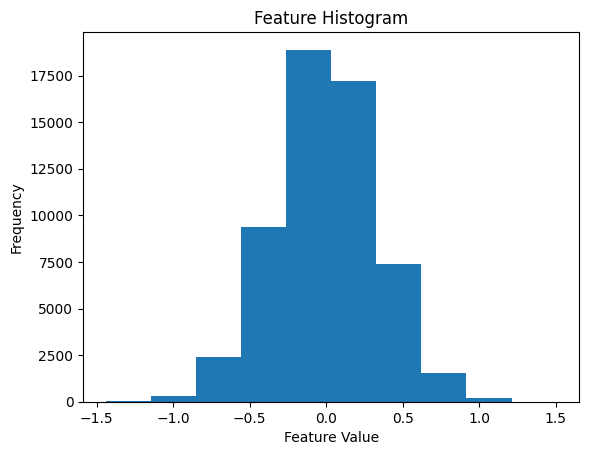

Mean of all features: -0.0014955362
Std of all features: 0.3327182
Mean of first feature: 0.08098485
Std of first feature: 0.28069898
Number of input features to the head: 25088
Number of samples in the dataset: 5582


In [78]:
# features = np.array(features.cpu())
# print(features.shape)
# plt.hist(features[:,0,:].flatten()) # CLS token
# plt.hist(features.flatten().cpu().numpy())  # Flatten the entire tensor
# print(np.mean(features.cpu().numpy()), np.std(features.cpu().numpy()))
# print(np.mean(features[:,0,:]), np.std(features[:,0,:]))
# model.head.in_features
# len(train_dataset)

# Flatten the entire tensor and plot a histogram
plt.hist(features.flatten().cpu().numpy())  # Flatten the entire tensor
plt.title("Feature Histogram")
plt.xlabel("Feature Value")
plt.ylabel("Frequency")
plt.show()

# Calculate and print the mean and standard deviation for all features
print("Mean of all features:", np.mean(features.cpu().numpy()))
print("Std of all features:", np.std(features.cpu().numpy()))

# Access the first feature across all samples (batch dimension) and calculate stats
print("Mean of first feature:", np.mean(features[:, 0].cpu().numpy()))
print("Std of first feature:", np.std(features[:, 0].cpu().numpy()))

# Additional checks (model and dataset information)
print("Number of input features to the head:", model.fc1.in_features)
print("Number of samples in the dataset:", len(train_dataset))

In [83]:
import timm 
import tqdm

###### Parameters ######
lr = 1e-4
num_classes = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10
clin_dim = 2
feature_dim = 25088  # VGG16 output after flattening

class CustomVGG16(nn.Module):
    def __init__(self, original_model, num_classes):
        super(CustomVGG16, self).__init__()
        self.features = original_model.features  # Convolutional layers
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 512),  # 512*7*7 for VGG16 feature output before classifier
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),  # `num_classes` = 16 for your case
            nn.Sigmoid(),  # Multi-label classification
        )

    def forward_features(self, x):
        """Extract features from the convolutional layers."""
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten the features
        return x

    def forward(self, x):
        """Forward pass through the entire model."""
        x = self.forward_features(x)
        x = self.classifier(x)
        return x

# Create the custom model with `timm`'s VGG16
model = CustomVGG16(timm.create_model('vgg16', pretrained=True), num_classes)



# # Modify the classifier head for multi-class output
model.fc = nn.Sequential(
    nn.Linear(4096, 512),  # Match the expected 4096 input features
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes),  # `num_classes` = 16 for your case
    nn.Sigmoid(),  # Multi-label classification
)

model = model.to('cuda')
    
# Freeze the feature extraction layers
for param in model.features.parameters():
    param.requires_grad = False

# Ensure the classifier parameters are trainable
for param in model.classifier.parameters():
    param.requires_grad = True
    

# class FusionClassifier(nn.Module):
#     def __init__(self, feature_dim, clin_dim, num_classes):
#         super(FusionClassifier, self).__init__()
#         combined_dim = feature_dim + clin_dim  # Correct combined dimension

#         # Define the classifier as a sequential model
#         self.classifier = nn.Sequential(
#             nn.Linear(combined_dim, 256),  # Input: combined_dim -> 256
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(256, num_classes),  # 256 -> num_classes
#             nn.Sigmoid()                  # Sigmoid activation for multi-label output
#         )
    
#     def forward(self, combined_features):
#         return self.classifier(combined_features)

class FusionClassifier(nn.Module):
    def __init__(self, feature_dim, clin_dim, num_classes):
        super(FusionClassifier, self).__init__()
        combined_dim = feature_dim + clin_dim  # Correct combined dimension

        # Define the classifier as a sequential model
        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, num_classes),  # Input: combined_dim -> 256
            nn.Sigmoid()                  # Sigmoid activation for multi-label output
        )
    
    def forward(self, combined_features):
        return self.classifier(combined_features)


multi_model = FusionClassifier(feature_dim, clin_dim, num_classes)

multi_model.to('cuda')
model.to('cuda') # vgg16 model

########################
optimizer = torch.optim.AdamW(multi_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

######### Loss ###########
# criterion = torch.nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification
criterion = WeightedBinaryCrossEntropyLoss(train_pos_weights.to('cuda'))
# criterion = FocalLoss(gamma=2.0, alpha=0.25)
##########################

# Training and validation
def train_one_epoch(multi_model,model, train_loader, optimizer, criterion):
    multi_model.train()
    model.eval()
    running_loss = 0.0  
    for images, labels, clin in tqdm.tqdm(train_loader):
        images, labels, clin = images.to('cuda'), labels.to('cuda'), clin.to('cuda')
        
        # Normalize clinical data to fit deit mean, std
        # clin [batch_size, 2]
        clin = (clin - torch.mean(clin)) /torch.std(clin) * vgg16_std + vgg16_mean

        # Get image features from vision model
        with torch.no_grad():
            img_features = model.forward_features(images)
            # img_features = img_features[:,0,:] # Get CLS tokens
        
        combined_features = torch.cat((img_features, clin), dim=1)
        optimizer.zero_grad()
        outputs = multi_model(combined_features)
        loss = criterion(outputs, labels)
        print('loss : ',loss.item())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)

def validate_one_epoch(multi_model,model, val_loader, criterion):
    multi_model.eval()
    model.eval()
    running_loss = 0.0
    all_outputs = np.zeros([len(val_dataset),num_classes])
    all_labels = np.zeros([len(val_dataset),num_classes])
    i = 0
    with torch.no_grad():
        for images, labels, clin in tqdm.tqdm(val_loader):
            images, labels, clin = images.to('cuda'), labels.to('cuda'), clin.to('cuda')
        
            # Normalize clinical data to fit deit mean, std
            # clin [batch_size, 2]
            clin = (clin - torch.mean(clin)) /torch.std(clin) * vgg16_std + vgg16_mean

            # Get image features from vision model
            with torch.no_grad():
                img_features = model.forward_features(images)
                # img_features = img_features[:,0,:] # Get CLS tokens

            combined_features = torch.cat((img_features, clin), dim=1)
            outputs = multi_model(combined_features)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
#             print(i*batch_size, min((i+1)*batch_size,len(val_dataset)))
#             print(outputs.shape)
            all_outputs[i*batch_size: min((i+1)*batch_size,len(val_dataset)),:] = outputs.cpu()
            all_labels[i*batch_size: min((i+1)*batch_size,len(val_dataset)),:] = labels.cpu()
            i+=1

    return running_loss / len(val_loader), all_outputs, all_labels

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    
    train_loss = train_one_epoch(multi_model, model, train_loader, optimizer, criterion)
    val_loss, val_outputs, val_labels = validate_one_epoch(multi_model, model, val_loader, criterion)
    
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    scheduler.step()



Epoch 1/10


  1%|          | 1/175 [00:00<00:21,  8.02it/s]

loss :  151.32752278420855


  1%|          | 2/175 [00:00<00:21,  8.04it/s]

loss :  139.10044817036083


  2%|▏         | 3/175 [00:00<00:21,  8.01it/s]

loss :  130.560894578858


  2%|▏         | 4/175 [00:00<00:21,  8.05it/s]

loss :  124.40225325481572


  3%|▎         | 5/175 [00:00<00:21,  8.04it/s]

loss :  119.21240307146172


  3%|▎         | 6/175 [00:00<00:20,  8.05it/s]

loss :  115.73456987601489


  4%|▍         | 7/175 [00:00<00:20,  8.05it/s]

loss :  114.31628704029002


  5%|▍         | 8/175 [00:00<00:20,  8.10it/s]

loss :  112.30179988867468


  5%|▌         | 9/175 [00:01<00:20,  8.10it/s]

loss :  111.33158616695592


  6%|▌         | 10/175 [00:01<00:20,  8.09it/s]

loss :  110.33825544122271


  6%|▋         | 11/175 [00:01<00:20,  8.09it/s]

loss :  109.99428277027266


  7%|▋         | 12/175 [00:01<00:20,  8.10it/s]

loss :  109.7176506792612


  7%|▋         | 13/175 [00:01<00:20,  8.09it/s]

loss :  108.91055699196858


  8%|▊         | 14/175 [00:01<00:19,  8.07it/s]

loss :  108.9820577374266


  9%|▊         | 15/175 [00:01<00:19,  8.06it/s]

loss :  108.54785852598064


  9%|▉         | 16/175 [00:01<00:19,  7.96it/s]

loss :  108.42168487729032


 10%|▉         | 17/175 [00:02<00:19,  8.02it/s]

loss :  107.97516640280463


 10%|█         | 18/175 [00:02<00:19,  8.06it/s]

loss :  107.7318759641652


 11%|█         | 19/175 [00:02<00:19,  8.10it/s]

loss :  107.62222238096467


 11%|█▏        | 20/175 [00:02<00:19,  8.11it/s]

loss :  107.58624744819565


 12%|█▏        | 21/175 [00:02<00:19,  8.08it/s]

loss :  107.77019574028884


 13%|█▎        | 22/175 [00:02<00:18,  8.09it/s]

loss :  107.68114568198544


 13%|█▎        | 23/175 [00:02<00:18,  8.07it/s]

loss :  107.44287229375097


 14%|█▎        | 24/175 [00:02<00:18,  8.05it/s]

loss :  107.38394625294418


 14%|█▍        | 25/175 [00:03<00:18,  8.07it/s]

loss :  107.38639743527011


 15%|█▍        | 26/175 [00:03<00:18,  8.08it/s]

loss :  107.20425530665621


 15%|█▌        | 27/175 [00:03<00:18,  8.08it/s]

loss :  107.18172921868253


 16%|█▌        | 28/175 [00:03<00:18,  8.09it/s]

loss :  107.24707683422946


 17%|█▋        | 29/175 [00:03<00:18,  8.06it/s]

loss :  107.27729951447735


 17%|█▋        | 30/175 [00:03<00:19,  7.61it/s]

loss :  107.04736514634915


 18%|█▊        | 31/175 [00:03<00:18,  7.73it/s]

loss :  107.06537941145163


 18%|█▊        | 32/175 [00:03<00:18,  7.83it/s]

loss :  107.02558438014641


 19%|█▉        | 33/175 [00:04<00:19,  7.24it/s]

loss :  107.08249776158473


 19%|█▉        | 34/175 [00:04<00:18,  7.47it/s]

loss :  107.07086169248751


 20%|██        | 35/175 [00:04<00:18,  7.41it/s]

loss :  107.00125042895874


 21%|██        | 36/175 [00:04<00:18,  7.60it/s]

loss :  107.01116654713346


 21%|██        | 37/175 [00:04<00:17,  7.74it/s]

loss :  106.86432428989703


 22%|██▏       | 38/175 [00:04<00:17,  7.81it/s]

loss :  107.05450998565705


 22%|██▏       | 39/175 [00:04<00:17,  7.89it/s]

loss :  107.04481649745499


 23%|██▎       | 40/175 [00:05<00:16,  7.96it/s]

loss :  106.79633956360169


 23%|██▎       | 41/175 [00:05<00:16,  8.00it/s]

loss :  106.8479859373123


 24%|██▍       | 42/175 [00:05<00:16,  8.03it/s]

loss :  106.91425400488585


 25%|██▍       | 43/175 [00:05<00:16,  8.05it/s]

loss :  106.83858952306284


 25%|██▌       | 44/175 [00:05<00:16,  8.10it/s]

loss :  106.77331475682811


 26%|██▌       | 45/175 [00:05<00:16,  8.11it/s]

loss :  107.01160528833243


 26%|██▋       | 46/175 [00:05<00:15,  8.12it/s]

loss :  106.75109298646908


 27%|██▋       | 47/175 [00:05<00:15,  8.09it/s]

loss :  106.77836507002732


 27%|██▋       | 48/175 [00:06<00:15,  8.07it/s]

loss :  106.78594143619212


 28%|██▊       | 49/175 [00:06<00:15,  8.07it/s]

loss :  106.86974007137559


 29%|██▊       | 50/175 [00:06<00:15,  8.07it/s]

loss :  106.75862148631191


 29%|██▉       | 51/175 [00:06<00:15,  8.08it/s]

loss :  106.76956534514636


 30%|██▉       | 52/175 [00:06<00:15,  8.10it/s]

loss :  106.73650792049824


 30%|███       | 53/175 [00:06<00:15,  8.11it/s]

loss :  106.71880670719972


 31%|███       | 54/175 [00:06<00:14,  8.12it/s]

loss :  106.79820942930851


 31%|███▏      | 55/175 [00:06<00:14,  8.12it/s]

loss :  106.74134009653935


 32%|███▏      | 56/175 [00:07<00:14,  8.10it/s]

loss :  106.7542756475396


 33%|███▎      | 57/175 [00:07<00:14,  8.07it/s]

loss :  106.73527527357939


 33%|███▎      | 58/175 [00:07<00:14,  8.05it/s]

loss :  106.73636802229254


 34%|███▎      | 59/175 [00:07<00:14,  8.10it/s]

loss :  106.7370602111761


 34%|███▍      | 60/175 [00:07<00:14,  8.10it/s]

loss :  106.69302975003667


 35%|███▍      | 61/175 [00:07<00:14,  8.10it/s]

loss :  106.73220772137357


 35%|███▌      | 62/175 [00:07<00:13,  8.11it/s]

loss :  106.72098838054356


 36%|███▌      | 63/175 [00:07<00:13,  8.09it/s]

loss :  106.68556999628443


 37%|███▋      | 64/175 [00:07<00:13,  8.08it/s]

loss :  106.66563582065028


 37%|███▋      | 65/175 [00:08<00:13,  8.09it/s]

loss :  106.73340041096978


 38%|███▊      | 66/175 [00:08<00:13,  8.08it/s]

loss :  106.74433704539936


 38%|███▊      | 67/175 [00:08<00:13,  8.09it/s]

loss :  106.69626341224671


 39%|███▉      | 68/175 [00:08<00:13,  8.11it/s]

loss :  106.63762781529138


 39%|███▉      | 69/175 [00:08<00:13,  8.12it/s]

loss :  106.75844314991484


 40%|████      | 70/175 [00:08<00:12,  8.12it/s]

loss :  106.69351165260088


 41%|████      | 71/175 [00:08<00:12,  8.11it/s]

loss :  106.67524637720328


 41%|████      | 72/175 [00:08<00:12,  8.08it/s]

loss :  106.71172374488924


 42%|████▏     | 73/175 [00:09<00:12,  8.07it/s]

loss :  106.73935126883754


 42%|████▏     | 74/175 [00:09<00:12,  8.07it/s]

loss :  106.67001395330973


 43%|████▎     | 75/175 [00:09<00:12,  8.10it/s]

loss :  106.66060231075711


 43%|████▎     | 76/175 [00:09<00:12,  8.10it/s]

loss :  106.67476638479718


 44%|████▍     | 77/175 [00:09<00:12,  8.15it/s]

loss :  106.7137534153024


 45%|████▍     | 78/175 [00:09<00:11,  8.18it/s]

loss :  106.62163324659154


 45%|████▌     | 79/175 [00:09<00:11,  8.16it/s]

loss :  106.66055032525725


 46%|████▌     | 80/175 [00:09<00:11,  8.14it/s]

loss :  106.6354623548167


 46%|████▋     | 81/175 [00:10<00:11,  8.13it/s]

loss :  106.71820204188352


 47%|████▋     | 82/175 [00:10<00:11,  8.12it/s]

loss :  106.66915994448073


 47%|████▋     | 83/175 [00:10<00:11,  8.09it/s]

loss :  106.66104191244838


 48%|████▊     | 84/175 [00:10<00:11,  8.09it/s]

loss :  106.68316197247222


 49%|████▊     | 85/175 [00:10<00:11,  8.09it/s]

loss :  106.66106287456732


 49%|████▉     | 86/175 [00:10<00:11,  8.09it/s]

loss :  106.64086114424046


 50%|████▉     | 87/175 [00:10<00:10,  8.08it/s]

loss :  106.6590531633839


 50%|█████     | 88/175 [00:10<00:10,  8.07it/s]

loss :  106.63388796660642


 51%|█████     | 89/175 [00:11<00:10,  8.08it/s]

loss :  106.63608702537593


 51%|█████▏    | 90/175 [00:11<00:10,  8.09it/s]

loss :  106.660871421525


 52%|█████▏    | 91/175 [00:11<00:10,  8.10it/s]

loss :  106.66451308259053


 53%|█████▎    | 92/175 [00:11<00:10,  7.93it/s]

loss :  106.64268479401903


 53%|█████▎    | 93/175 [00:11<00:10,  7.96it/s]

loss :  106.61304327601249


 54%|█████▎    | 94/175 [00:11<00:10,  7.99it/s]

loss :  106.62205781293865


 54%|█████▍    | 95/175 [00:11<00:09,  8.02it/s]

loss :  106.66122493362941


 55%|█████▍    | 96/175 [00:11<00:09,  8.04it/s]

loss :  106.6164283213883


 55%|█████▌    | 97/175 [00:12<00:09,  8.04it/s]

loss :  106.60552419645033


 56%|█████▌    | 98/175 [00:12<00:09,  8.05it/s]

loss :  106.62121221206675


 57%|█████▋    | 99/175 [00:12<00:09,  8.06it/s]

loss :  106.62696617711171


 57%|█████▋    | 100/175 [00:12<00:09,  8.06it/s]

loss :  106.62079293315394


 58%|█████▊    | 101/175 [00:12<00:09,  8.07it/s]

loss :  106.65613729103697


 58%|█████▊    | 102/175 [00:12<00:09,  8.05it/s]

loss :  106.5931473911726


 59%|█████▉    | 103/175 [00:12<00:08,  8.05it/s]

loss :  106.67020895946507


 59%|█████▉    | 104/175 [00:12<00:08,  8.06it/s]

loss :  106.57678742647542


 60%|██████    | 105/175 [00:13<00:08,  8.06it/s]

loss :  106.60909714019238


 61%|██████    | 106/175 [00:13<00:08,  8.06it/s]

loss :  106.62736661117218


 61%|██████    | 107/175 [00:13<00:08,  8.05it/s]

loss :  106.59057756959336


 62%|██████▏   | 108/175 [00:13<00:08,  8.05it/s]

loss :  106.63720103132437


 62%|██████▏   | 109/175 [00:13<00:08,  8.06it/s]

loss :  106.64278590552645


 63%|██████▎   | 110/175 [00:13<00:08,  7.47it/s]

loss :  106.61390911588757


 63%|██████▎   | 111/175 [00:13<00:08,  7.29it/s]

loss :  106.64001120415853


 64%|██████▍   | 112/175 [00:14<00:08,  7.30it/s]

loss :  106.59796519507401


 65%|██████▍   | 113/175 [00:14<00:08,  7.49it/s]

loss :  106.6126394387377


 65%|██████▌   | 114/175 [00:14<00:08,  7.38it/s]

loss :  106.6104163943169


 66%|██████▌   | 115/175 [00:14<00:07,  7.59it/s]

loss :  106.5928324250373


 66%|██████▋   | 116/175 [00:14<00:07,  7.58it/s]

loss :  106.6283864739253


 67%|██████▋   | 117/175 [00:14<00:08,  7.14it/s]

loss :  106.62540952215893


 67%|██████▋   | 118/175 [00:14<00:07,  7.19it/s]

loss :  106.58200898208727


 68%|██████▊   | 119/175 [00:14<00:07,  7.45it/s]

loss :  106.5976682367024


 69%|██████▊   | 120/175 [00:15<00:07,  7.65it/s]

loss :  106.58993548107199


 69%|██████▉   | 121/175 [00:15<00:07,  7.33it/s]

loss :  106.71037691707687


 70%|██████▉   | 122/175 [00:15<00:06,  7.58it/s]

loss :  106.56691494364748


 70%|███████   | 123/175 [00:15<00:06,  7.73it/s]

loss :  106.62984656812677


 71%|███████   | 124/175 [00:15<00:06,  7.83it/s]

loss :  106.58963057247594


 71%|███████▏  | 125/175 [00:15<00:06,  7.91it/s]

loss :  106.69583387697286


 72%|███████▏  | 126/175 [00:15<00:06,  7.98it/s]

loss :  106.57210016406465


 73%|███████▎  | 127/175 [00:15<00:06,  7.72it/s]

loss :  106.58557786789117


 73%|███████▎  | 128/175 [00:16<00:06,  7.41it/s]

loss :  106.56907773485514


 74%|███████▎  | 129/175 [00:16<00:06,  7.61it/s]

loss :  106.64293507650636


 74%|███████▍  | 130/175 [00:16<00:05,  7.76it/s]

loss :  106.58829945419481


 75%|███████▍  | 131/175 [00:16<00:05,  7.88it/s]

loss :  106.58479465729687


 75%|███████▌  | 132/175 [00:16<00:05,  7.92it/s]

loss :  106.60618874693523


 76%|███████▌  | 133/175 [00:16<00:05,  7.93it/s]

loss :  106.63387067134255


 77%|███████▋  | 134/175 [00:16<00:05,  7.94it/s]

loss :  106.62313528124494


 77%|███████▋  | 135/175 [00:16<00:05,  7.97it/s]

loss :  106.59183807794325


 78%|███████▊  | 136/175 [00:17<00:05,  7.80it/s]

loss :  106.59781534260921


 78%|███████▊  | 137/175 [00:17<00:04,  7.88it/s]

loss :  106.55329371623054


 79%|███████▉  | 138/175 [00:17<00:04,  7.97it/s]

loss :  106.58158435846445


 79%|███████▉  | 139/175 [00:17<00:04,  8.02it/s]

loss :  106.57436635845278


 80%|████████  | 140/175 [00:17<00:04,  8.06it/s]

loss :  106.5621876013141


 81%|████████  | 141/175 [00:17<00:04,  7.82it/s]

loss :  106.59185904002494


 81%|████████  | 142/175 [00:17<00:04,  7.92it/s]

loss :  106.57858214851312


 82%|████████▏ | 143/175 [00:18<00:04,  7.99it/s]

loss :  106.57774145953482


 82%|████████▏ | 144/175 [00:18<00:03,  8.03it/s]

loss :  106.56225303903213


 83%|████████▎ | 145/175 [00:18<00:03,  8.06it/s]

loss :  106.63491312220559


 83%|████████▎ | 146/175 [00:18<00:03,  8.06it/s]

loss :  106.55798366841552


 84%|████████▍ | 147/175 [00:18<00:03,  8.10it/s]

loss :  106.61605670711731


 85%|████████▍ | 148/175 [00:18<00:03,  8.12it/s]

loss :  106.57722199341865


 85%|████████▌ | 149/175 [00:18<00:03,  8.13it/s]

loss :  106.55881574837989


 86%|████████▌ | 150/175 [00:18<00:03,  8.09it/s]

loss :  106.5711268142662


 86%|████████▋ | 151/175 [00:18<00:02,  8.10it/s]

loss :  106.58870222775813


 87%|████████▋ | 152/175 [00:19<00:02,  8.05it/s]

loss :  106.58235272491


 87%|████████▋ | 153/175 [00:19<00:02,  8.05it/s]

loss :  106.5833016979833


 88%|████████▊ | 154/175 [00:19<00:02,  8.04it/s]

loss :  106.56741813651684


 89%|████████▊ | 155/175 [00:19<00:02,  8.06it/s]

loss :  106.54916748280942


 89%|████████▉ | 156/175 [00:19<00:02,  8.09it/s]

loss :  106.57669033958135


 90%|████████▉ | 157/175 [00:19<00:02,  7.75it/s]

loss :  106.55486441499086


 90%|█████████ | 158/175 [00:19<00:02,  7.86it/s]

loss :  106.56630081861125


 91%|█████████ | 159/175 [00:19<00:02,  7.94it/s]

loss :  106.57377075230602


 91%|█████████▏| 160/175 [00:20<00:01,  8.01it/s]

loss :  106.55179005339312


 92%|█████████▏| 161/175 [00:20<00:01,  8.03it/s]

loss :  106.58233153112133


 93%|█████████▎| 162/175 [00:20<00:01,  8.06it/s]

loss :  106.56570741222784


 93%|█████████▎| 163/175 [00:20<00:01,  8.05it/s]

loss :  106.56564805562452


 94%|█████████▎| 164/175 [00:20<00:01,  8.07it/s]

loss :  106.581383110237


 94%|█████████▍| 165/175 [00:20<00:01,  8.07it/s]

loss :  106.57456108137922


 95%|█████████▍| 166/175 [00:20<00:01,  8.06it/s]

loss :  106.56162759166672


 95%|█████████▌| 167/175 [00:20<00:00,  8.06it/s]

loss :  106.62846330795868


 96%|█████████▌| 168/175 [00:21<00:00,  8.07it/s]

loss :  106.5615684007362


 97%|█████████▋| 169/175 [00:21<00:00,  8.07it/s]

loss :  106.5804750747003


 97%|█████████▋| 170/175 [00:21<00:00,  7.71it/s]

loss :  106.59731917304349


 98%|█████████▊| 171/175 [00:21<00:00,  7.84it/s]

loss :  106.55832825960417


 98%|█████████▊| 172/175 [00:21<00:00,  7.90it/s]

loss :  106.58575411733179


 99%|█████████▉| 173/175 [00:21<00:00,  7.95it/s]

loss :  106.56422664725778


100%|██████████| 175/175 [00:21<00:00,  7.98it/s]


loss :  106.55264935170256
loss :  106.56254945266035


100%|██████████| 58/58 [00:07<00:00,  8.08it/s]


Train Loss: 107.7414, Val Loss: 106.5327
Epoch 2/10


  1%|          | 1/175 [00:00<00:21,  8.19it/s]

loss :  106.56489093224167


  1%|          | 2/175 [00:00<00:21,  8.14it/s]

loss :  106.55860865752332


  2%|▏         | 3/175 [00:00<00:21,  8.10it/s]

loss :  106.57562557698928


  2%|▏         | 4/175 [00:00<00:21,  8.09it/s]

loss :  106.5452699812493


  3%|▎         | 5/175 [00:00<00:20,  8.13it/s]

loss :  106.5798841333488


  3%|▎         | 6/175 [00:00<00:20,  8.14it/s]

loss :  106.54796388598777


  4%|▍         | 7/175 [00:00<00:20,  8.14it/s]

loss :  106.56648321900855


  5%|▍         | 8/175 [00:00<00:20,  8.12it/s]

loss :  106.55310714459225


  5%|▌         | 9/175 [00:01<00:20,  8.08it/s]

loss :  106.55103565671888


  6%|▌         | 10/175 [00:01<00:20,  8.09it/s]

loss :  106.56784977593435


  6%|▋         | 11/175 [00:01<00:20,  8.11it/s]

loss :  106.5409715250103


  7%|▋         | 12/175 [00:01<00:20,  8.10it/s]

loss :  106.5601555044394


  7%|▋         | 13/175 [00:01<00:20,  8.08it/s]

loss :  106.55284794520209


  8%|▊         | 14/175 [00:01<00:19,  8.09it/s]

loss :  106.57861657354505


  9%|▊         | 15/175 [00:01<00:19,  8.10it/s]

loss :  106.55732900407848


  9%|▉         | 16/175 [00:01<00:19,  8.13it/s]

loss :  106.5807854579769


 10%|▉         | 17/175 [00:02<00:19,  8.13it/s]

loss :  106.54697019615875


 10%|█         | 18/175 [00:02<00:19,  8.10it/s]

loss :  106.55494023201109


 11%|█         | 19/175 [00:02<00:19,  8.08it/s]

loss :  106.54576655217497


 11%|█▏        | 20/175 [00:02<00:19,  8.09it/s]

loss :  106.54182808224559


 12%|█▏        | 21/175 [00:02<00:19,  8.05it/s]

loss :  106.55502985014151


 13%|█▎        | 22/175 [00:02<00:18,  8.08it/s]

loss :  106.55776352883075


 13%|█▎        | 23/175 [00:02<00:20,  7.58it/s]

loss :  106.55949895771681


 14%|█▎        | 24/175 [00:02<00:19,  7.66it/s]

loss :  106.5542468704025


 14%|█▍        | 25/175 [00:03<00:19,  7.76it/s]

loss :  106.56892528682192


 15%|█▍        | 26/175 [00:03<00:18,  7.85it/s]

loss :  106.55268391798666


 15%|█▌        | 27/175 [00:03<00:18,  7.91it/s]

loss :  106.54352113233115


 16%|█▌        | 28/175 [00:03<00:18,  7.96it/s]

loss :  106.56620362915211


 17%|█▋        | 29/175 [00:03<00:18,  7.99it/s]

loss :  106.55063471899865


 17%|█▋        | 30/175 [00:03<00:18,  8.01it/s]

loss :  106.57056069181917


 18%|█▊        | 31/175 [00:03<00:17,  8.03it/s]

loss :  106.53835248972752


 18%|█▊        | 32/175 [00:03<00:17,  8.02it/s]

loss :  106.5308368127328


 19%|█▉        | 33/175 [00:04<00:17,  8.05it/s]

loss :  106.5504883778598


 19%|█▉        | 34/175 [00:04<00:17,  8.09it/s]

loss :  106.54282454543693


 20%|██        | 35/175 [00:04<00:17,  8.08it/s]

loss :  106.54944847583803


 21%|██        | 36/175 [00:04<00:17,  8.09it/s]

loss :  106.55660491441701


 21%|██        | 37/175 [00:04<00:17,  7.97it/s]

loss :  106.56278288067615


 22%|██▏       | 38/175 [00:04<00:17,  8.04it/s]

loss :  106.55219570746891


 22%|██▏       | 39/175 [00:04<00:16,  8.06it/s]

loss :  106.55566409075425


 23%|██▎       | 40/175 [00:04<00:16,  8.06it/s]

loss :  106.59923596150327


 23%|██▎       | 41/175 [00:05<00:17,  7.76it/s]

loss :  106.53904334337118


 24%|██▍       | 42/175 [00:05<00:16,  7.88it/s]

loss :  106.54578759105999


 25%|██▍       | 43/175 [00:05<00:16,  7.95it/s]

loss :  106.55229331373236


 25%|██▌       | 44/175 [00:05<00:16,  7.99it/s]

loss :  106.55170630076655


 26%|██▌       | 45/175 [00:05<00:16,  8.03it/s]

loss :  106.54553352218281


 26%|██▋       | 46/175 [00:05<00:16,  8.05it/s]

loss :  106.54146894375165


 27%|██▋       | 47/175 [00:05<00:15,  8.05it/s]

loss :  106.5442933533878


 27%|██▋       | 48/175 [00:05<00:15,  8.07it/s]

loss :  106.5531318658895


 28%|██▊       | 49/175 [00:06<00:15,  8.07it/s]

loss :  106.56378892020543


 29%|██▊       | 50/175 [00:06<00:15,  8.09it/s]

loss :  106.54339912775112


 29%|██▉       | 51/175 [00:06<00:15,  8.12it/s]

loss :  106.56574080173012


 30%|██▉       | 52/175 [00:06<00:15,  8.14it/s]

loss :  106.53528811647284


 30%|███       | 53/175 [00:06<00:15,  8.13it/s]

loss :  106.54927364154389


 31%|███       | 54/175 [00:06<00:14,  8.12it/s]

loss :  106.57188484025676


 31%|███▏      | 55/175 [00:06<00:14,  8.11it/s]

loss :  106.55858568900052


 32%|███▏      | 56/175 [00:06<00:14,  8.10it/s]

loss :  106.55554990096087


 33%|███▎      | 57/175 [00:07<00:14,  8.11it/s]

loss :  106.54507259896451


 33%|███▎      | 58/175 [00:07<00:14,  8.14it/s]

loss :  106.53357080644527


 34%|███▎      | 59/175 [00:07<00:14,  8.13it/s]

loss :  106.5354867128232


 34%|███▍      | 60/175 [00:07<00:14,  8.11it/s]

loss :  106.54618256674092


 35%|███▍      | 61/175 [00:07<00:14,  8.12it/s]

loss :  106.54965999592339


 35%|███▌      | 62/175 [00:07<00:13,  8.08it/s]

loss :  106.55291429926552


 36%|███▌      | 63/175 [00:07<00:13,  8.07it/s]

loss :  106.55521761593954


 37%|███▋      | 64/175 [00:07<00:13,  8.06it/s]

loss :  106.56758871569181


 37%|███▋      | 65/175 [00:08<00:13,  8.06it/s]

loss :  106.54384836536822


 38%|███▊      | 66/175 [00:08<00:13,  8.06it/s]

loss :  106.55160806999677


 38%|███▊      | 67/175 [00:08<00:13,  8.06it/s]

loss :  106.552807725696


 39%|███▉      | 68/175 [00:08<00:13,  8.05it/s]

loss :  106.54644164455794


 39%|███▉      | 69/175 [00:08<00:13,  8.05it/s]

loss :  106.55504031984907


 40%|████      | 70/175 [00:08<00:13,  8.07it/s]

loss :  106.54620545420488


 41%|████      | 71/175 [00:08<00:12,  8.07it/s]

loss :  106.54516587073101


 41%|████      | 72/175 [00:08<00:12,  8.06it/s]

loss :  106.58729763098455


 42%|████▏     | 73/175 [00:09<00:12,  8.07it/s]

loss :  106.54612864374282


 42%|████▏     | 74/175 [00:09<00:12,  8.07it/s]

loss :  106.53606863109124


 43%|████▎     | 75/175 [00:09<00:12,  8.09it/s]

loss :  106.5491687935426


 43%|████▎     | 76/175 [00:09<00:12,  8.09it/s]

loss :  106.54045131922683


 44%|████▍     | 77/175 [00:09<00:12,  8.10it/s]

loss :  106.53999519694867


 45%|████▍     | 78/175 [00:09<00:11,  8.10it/s]

loss :  106.53035111275724


 45%|████▌     | 79/175 [00:09<00:11,  8.12it/s]

loss :  106.55612533132818


 46%|████▌     | 80/175 [00:09<00:11,  8.11it/s]

loss :  106.5417885104787


 46%|████▋     | 81/175 [00:10<00:11,  8.08it/s]

loss :  106.53705501879591


 47%|████▋     | 82/175 [00:10<00:11,  8.08it/s]

loss :  106.54920254327699


 47%|████▋     | 83/175 [00:10<00:11,  8.10it/s]

loss :  106.55067066076423


 48%|████▊     | 84/175 [00:10<00:11,  8.08it/s]

loss :  106.55268153440639


 49%|████▊     | 85/175 [00:10<00:11,  8.08it/s]

loss :  106.54563089243686


 49%|████▉     | 86/175 [00:10<00:11,  8.08it/s]

loss :  106.56165299198902


 50%|████▉     | 87/175 [00:10<00:10,  8.06it/s]

loss :  106.53637228854916


 50%|█████     | 88/175 [00:10<00:10,  8.05it/s]

loss :  106.5448882458576


 51%|█████     | 89/175 [00:11<00:10,  8.07it/s]

loss :  106.53880293773236


 51%|█████▏    | 90/175 [00:11<00:10,  8.08it/s]

loss :  106.5537475171736


 52%|█████▏    | 91/175 [00:11<00:10,  8.11it/s]

loss :  106.56033815102073


 53%|█████▎    | 92/175 [00:11<00:10,  8.11it/s]

loss :  106.55926366837542


 53%|█████▎    | 93/175 [00:11<00:10,  8.12it/s]

loss :  106.54373299284367


 54%|█████▎    | 94/175 [00:11<00:09,  8.12it/s]

loss :  106.54273617148175


 54%|█████▍    | 95/175 [00:11<00:09,  8.14it/s]

loss :  106.57385697375565


 55%|█████▍    | 96/175 [00:11<00:09,  8.14it/s]

loss :  106.53691519257575


 55%|█████▌    | 97/175 [00:12<00:09,  8.15it/s]

loss :  106.54230579120446


 56%|█████▌    | 98/175 [00:12<00:09,  8.13it/s]

loss :  106.54720397026513


 57%|█████▋    | 99/175 [00:12<00:09,  8.10it/s]

loss :  106.55590537084663


 57%|█████▋    | 100/175 [00:12<00:09,  8.09it/s]

loss :  106.54704298247285


 58%|█████▊    | 101/175 [00:12<00:09,  8.09it/s]

loss :  106.57546735311706


 58%|█████▊    | 102/175 [00:12<00:09,  8.10it/s]

loss :  106.54368967805718


 59%|█████▉    | 103/175 [00:12<00:08,  8.09it/s]

loss :  106.54494671725672


 59%|█████▉    | 104/175 [00:12<00:08,  8.07it/s]

loss :  106.54946989684328


 60%|██████    | 105/175 [00:13<00:08,  8.08it/s]

loss :  106.5405676345662


 61%|██████    | 106/175 [00:13<00:08,  8.06it/s]

loss :  106.53670683991885


 61%|██████    | 107/175 [00:13<00:08,  8.08it/s]

loss :  106.54324875799873


 62%|██████▏   | 108/175 [00:13<00:08,  8.05it/s]

loss :  106.5311524966533


 62%|██████▏   | 109/175 [00:13<00:08,  8.06it/s]

loss :  106.55915099107102


 63%|██████▎   | 110/175 [00:13<00:08,  8.07it/s]

loss :  106.53709474907367


 63%|██████▎   | 111/175 [00:13<00:07,  8.10it/s]

loss :  106.53941030626311


 64%|██████▍   | 112/175 [00:13<00:07,  8.08it/s]

loss :  106.54468022266738


 65%|██████▍   | 113/175 [00:14<00:07,  8.05it/s]

loss :  106.5389230953017


 65%|██████▌   | 114/175 [00:14<00:07,  8.09it/s]

loss :  106.5373131330146


 66%|██████▌   | 115/175 [00:14<00:07,  8.12it/s]

loss :  106.53912776528642


 66%|██████▋   | 116/175 [00:14<00:07,  8.10it/s]

loss :  106.53269919105364


 67%|██████▋   | 117/175 [00:14<00:07,  8.10it/s]

loss :  106.53691024399487


 67%|██████▋   | 118/175 [00:14<00:07,  8.08it/s]

loss :  106.58539812691922


 68%|██████▊   | 119/175 [00:14<00:06,  8.09it/s]

loss :  106.5428551606007


 69%|██████▊   | 120/175 [00:14<00:06,  8.12it/s]

loss :  106.54310353473235


 69%|██████▉   | 121/175 [00:15<00:06,  8.13it/s]

loss :  106.55220071901168


 70%|██████▉   | 122/175 [00:15<00:06,  8.11it/s]

loss :  106.56390330965532


 70%|███████   | 123/175 [00:15<00:06,  8.11it/s]

loss :  106.53270166153365


 71%|███████   | 124/175 [00:15<00:06,  8.12it/s]

loss :  106.53234458599684


 71%|███████▏  | 125/175 [00:15<00:06,  8.11it/s]

loss :  106.53230027118607


 72%|███████▏  | 126/175 [00:15<00:06,  8.06it/s]

loss :  106.53840062891265


 73%|███████▎  | 127/175 [00:15<00:05,  8.10it/s]

loss :  106.53381767410235


 73%|███████▎  | 128/175 [00:15<00:05,  8.12it/s]

loss :  106.55921679003706


 74%|███████▎  | 129/175 [00:15<00:05,  8.13it/s]

loss :  106.54439288426039


 74%|███████▍  | 130/175 [00:16<00:05,  8.12it/s]

loss :  106.54485037881204


 75%|███████▍  | 131/175 [00:16<00:05,  8.11it/s]

loss :  106.54645972657445


 75%|███████▌  | 132/175 [00:16<00:05,  8.15it/s]

loss :  106.55043744149228


 76%|███████▌  | 133/175 [00:16<00:05,  8.18it/s]

loss :  106.53782336866513


 77%|███████▋  | 134/175 [00:16<00:05,  8.16it/s]

loss :  106.54007192333076


 77%|███████▋  | 135/175 [00:16<00:04,  8.13it/s]

loss :  106.54521401318331


 78%|███████▊  | 136/175 [00:16<00:04,  8.14it/s]

loss :  106.542845213268


 78%|███████▊  | 137/175 [00:16<00:04,  8.14it/s]

loss :  106.55342515854926


 79%|███████▉  | 138/175 [00:17<00:04,  8.15it/s]

loss :  106.53538403015563


 79%|███████▉  | 139/175 [00:17<00:04,  8.15it/s]

loss :  106.5347298605003


 80%|████████  | 140/175 [00:17<00:04,  8.12it/s]

loss :  106.54675358229515


 81%|████████  | 141/175 [00:17<00:04,  8.14it/s]

loss :  106.54672004298787


 81%|████████  | 142/175 [00:17<00:04,  8.12it/s]

loss :  106.54975913762257


 82%|████████▏ | 143/175 [00:17<00:03,  8.12it/s]

loss :  106.54549359402424


 82%|████████▏ | 144/175 [00:17<00:03,  8.11it/s]

loss :  106.53508800784846


 83%|████████▎ | 145/175 [00:17<00:03,  8.10it/s]

loss :  106.54129147608123


 83%|████████▎ | 146/175 [00:18<00:03,  8.11it/s]

loss :  106.54734866627061


 84%|████████▍ | 147/175 [00:18<00:03,  8.11it/s]

loss :  106.5414341387605


 85%|████████▍ | 148/175 [00:18<00:03,  8.12it/s]

loss :  106.53785858252012


 85%|████████▌ | 149/175 [00:18<00:03,  8.13it/s]

loss :  106.54091757908664


 86%|████████▌ | 150/175 [00:18<00:03,  8.11it/s]

loss :  106.53420703680835


 86%|████████▋ | 151/175 [00:18<00:02,  8.10it/s]

loss :  106.53581442339092


 87%|████████▋ | 152/175 [00:18<00:02,  8.09it/s]

loss :  106.5378795765549


 87%|████████▋ | 153/175 [00:18<00:02,  8.08it/s]

loss :  106.55375766764833


 88%|████████▊ | 154/175 [00:19<00:02,  8.09it/s]

loss :  106.53918957974044


 89%|████████▊ | 155/175 [00:19<00:02,  8.12it/s]

loss :  106.54105950367665


 89%|████████▉ | 156/175 [00:19<00:02,  8.10it/s]

loss :  106.53680932439309


 90%|████████▉ | 157/175 [00:19<00:02,  7.87it/s]

loss :  106.57474202576302


 90%|█████████ | 158/175 [00:19<00:02,  7.95it/s]

loss :  106.54378476285184


 91%|█████████ | 159/175 [00:19<00:02,  7.97it/s]

loss :  106.52983071024255


 91%|█████████▏| 160/175 [00:19<00:01,  8.01it/s]

loss :  106.5624061704657


 92%|█████████▏| 161/175 [00:19<00:01,  8.02it/s]

loss :  106.53166416152621


 93%|█████████▎| 162/175 [00:20<00:01,  8.01it/s]

loss :  106.53687173312983


 93%|█████████▎| 163/175 [00:20<00:01,  8.00it/s]

loss :  106.52672560117587


 94%|█████████▎| 164/175 [00:20<00:01,  8.03it/s]

loss :  106.5253222159453


 94%|█████████▍| 165/175 [00:20<00:01,  8.04it/s]

loss :  106.54722208699414


 95%|█████████▍| 166/175 [00:20<00:01,  8.07it/s]

loss :  106.53380069390818


 95%|█████████▌| 167/175 [00:20<00:00,  8.10it/s]

loss :  106.53421239250403


 96%|█████████▌| 168/175 [00:20<00:00,  8.11it/s]

loss :  106.53967995823305


 97%|█████████▋| 169/175 [00:20<00:00,  8.12it/s]

loss :  106.5533106560412


 97%|█████████▋| 170/175 [00:21<00:00,  8.13it/s]

loss :  106.54137268290316


 98%|█████████▊| 171/175 [00:21<00:00,  8.11it/s]

loss :  106.52956896910004


 98%|█████████▊| 172/175 [00:21<00:00,  8.14it/s]

loss :  106.53569565052103


 99%|█████████▉| 173/175 [00:21<00:00,  8.08it/s]

loss :  106.54219061389591


100%|██████████| 175/175 [00:21<00:00,  8.10it/s]


loss :  106.54259445048376
loss :  106.53505823343532


100%|██████████| 58/58 [00:07<00:00,  8.07it/s]


Train Loss: 106.5482, Val Loss: 106.5287
Epoch 3/10


  1%|          | 1/175 [00:00<00:21,  8.14it/s]

loss :  106.5416825307468


  1%|          | 2/175 [00:00<00:21,  8.13it/s]

loss :  106.53555442970122


  2%|▏         | 3/175 [00:00<00:21,  8.16it/s]

loss :  106.54010065796058


  2%|▏         | 4/175 [00:00<00:21,  8.13it/s]

loss :  106.54558286264411


  3%|▎         | 5/175 [00:00<00:20,  8.12it/s]

loss :  106.54726552309822


  3%|▎         | 6/175 [00:00<00:20,  8.14it/s]

loss :  106.52948999702342


  4%|▍         | 7/175 [00:00<00:20,  8.16it/s]

loss :  106.53421475539719


  5%|▍         | 8/175 [00:00<00:20,  8.13it/s]

loss :  106.56499706118076


  5%|▌         | 9/175 [00:01<00:20,  8.12it/s]

loss :  106.5272602491661


  6%|▌         | 10/175 [00:01<00:20,  8.09it/s]

loss :  106.53595527052015


  6%|▋         | 11/175 [00:01<00:20,  8.07it/s]

loss :  106.54462722224918


  7%|▋         | 12/175 [00:01<00:20,  8.09it/s]

loss :  106.53218001907665


  7%|▋         | 13/175 [00:01<00:19,  8.11it/s]

loss :  106.53126624925702


  8%|▊         | 14/175 [00:01<00:19,  8.13it/s]

loss :  106.52884685406899


  9%|▊         | 15/175 [00:01<00:19,  8.08it/s]

loss :  106.53921343785353


  9%|▉         | 16/175 [00:01<00:19,  8.10it/s]

loss :  106.54070599640139


 10%|▉         | 17/175 [00:02<00:19,  8.14it/s]

loss :  106.54816526015195


 10%|█         | 18/175 [00:02<00:19,  8.14it/s]

loss :  106.52705301239047


 11%|█         | 19/175 [00:02<00:19,  8.15it/s]

loss :  106.53749341300137


 11%|█▏        | 20/175 [00:02<00:19,  7.78it/s]

loss :  106.5378329779059


 12%|█▏        | 21/175 [00:02<00:19,  7.91it/s]

loss :  106.52776837007751


 13%|█▎        | 22/175 [00:02<00:19,  7.96it/s]

loss :  106.54056932113967


 13%|█▎        | 23/175 [00:02<00:19,  7.99it/s]

loss :  106.54297220295946


 14%|█▎        | 24/175 [00:02<00:18,  8.02it/s]

loss :  106.54063158603898


 14%|█▍        | 25/175 [00:03<00:18,  8.05it/s]

loss :  106.52976189587051


 15%|█▍        | 26/175 [00:03<00:18,  8.05it/s]

loss :  106.5364991855358


 15%|█▌        | 27/175 [00:03<00:18,  8.07it/s]

loss :  106.56577297529452


 16%|█▌        | 28/175 [00:03<00:18,  8.07it/s]

loss :  106.53509494378679


 17%|█▋        | 29/175 [00:03<00:18,  8.06it/s]

loss :  106.53519303439357


 17%|█▋        | 30/175 [00:03<00:18,  8.05it/s]

loss :  106.54233533506105


 18%|█▊        | 31/175 [00:03<00:17,  8.07it/s]

loss :  106.53401915189644


 18%|█▊        | 32/175 [00:03<00:17,  8.07it/s]

loss :  106.53598693699523


 19%|█▉        | 33/175 [00:04<00:17,  7.95it/s]

loss :  106.53009887072496


 19%|█▉        | 34/175 [00:04<00:17,  7.98it/s]

loss :  106.53969475958002


 20%|██        | 35/175 [00:04<00:17,  7.99it/s]

loss :  106.53771838736918


 21%|██        | 36/175 [00:04<00:17,  8.00it/s]

loss :  106.53050830374815


 21%|██        | 37/175 [00:04<00:17,  8.03it/s]

loss :  106.53523345966835


 22%|██▏       | 38/175 [00:04<00:16,  8.06it/s]

loss :  106.53915576812079


 22%|██▏       | 39/175 [00:04<00:16,  8.06it/s]

loss :  106.53120298576533


 23%|██▎       | 40/175 [00:04<00:16,  8.05it/s]

loss :  106.53545952773467


 23%|██▎       | 41/175 [00:05<00:16,  8.05it/s]

loss :  106.5465309716654


 24%|██▍       | 42/175 [00:05<00:16,  8.06it/s]

loss :  106.53981141054442


 25%|██▍       | 43/175 [00:05<00:16,  8.05it/s]

loss :  106.5362094122886


 25%|██▌       | 44/175 [00:05<00:16,  8.07it/s]

loss :  106.54555493387889


 26%|██▌       | 45/175 [00:05<00:16,  8.12it/s]

loss :  106.53363996929627


 26%|██▋       | 46/175 [00:05<00:15,  8.11it/s]

loss :  106.53718552613097


 27%|██▋       | 47/175 [00:05<00:15,  8.07it/s]

loss :  106.53487342158944


 27%|██▋       | 48/175 [00:05<00:15,  8.07it/s]

loss :  106.53015378343613


 28%|██▊       | 49/175 [00:06<00:15,  8.08it/s]

loss :  106.52903459244848


 29%|██▊       | 50/175 [00:06<00:16,  7.62it/s]

loss :  106.53272826645893


 29%|██▉       | 51/175 [00:06<00:15,  7.76it/s]

loss :  106.5326240443203


 30%|██▉       | 52/175 [00:06<00:15,  7.87it/s]

loss :  106.53613588245344


 30%|███       | 53/175 [00:06<00:15,  7.95it/s]

loss :  106.53674258325267


 31%|███       | 54/175 [00:06<00:15,  7.98it/s]

loss :  106.53064926455612


 31%|███▏      | 55/175 [00:06<00:15,  7.99it/s]

loss :  106.52755162392386


 32%|███▏      | 56/175 [00:06<00:14,  8.01it/s]

loss :  106.56028740804734


 33%|███▎      | 57/175 [00:07<00:14,  8.03it/s]

loss :  106.54400583551069


 33%|███▎      | 58/175 [00:07<00:14,  8.05it/s]

loss :  106.52829019424695


 34%|███▎      | 59/175 [00:07<00:14,  8.05it/s]

loss :  106.52970416070367


 34%|███▍      | 60/175 [00:07<00:14,  8.06it/s]

loss :  106.52850990820977


 35%|███▍      | 61/175 [00:07<00:14,  8.06it/s]

loss :  106.53736810893021


 35%|███▌      | 62/175 [00:07<00:13,  8.07it/s]

loss :  106.52171700003711


 36%|███▌      | 63/175 [00:07<00:13,  8.07it/s]

loss :  106.53584698574


 37%|███▋      | 64/175 [00:07<00:13,  8.07it/s]

loss :  106.53275521701212


 37%|███▋      | 65/175 [00:08<00:13,  8.07it/s]

loss :  106.53618115303708


 38%|███▊      | 66/175 [00:08<00:13,  8.08it/s]

loss :  106.54060267525409


 38%|███▊      | 67/175 [00:08<00:13,  8.11it/s]

loss :  106.53008757734801


 39%|███▉      | 68/175 [00:08<00:13,  8.12it/s]

loss :  106.54864130572663


 39%|███▉      | 69/175 [00:08<00:13,  8.13it/s]

loss :  106.5268379248499


 40%|████      | 70/175 [00:08<00:12,  8.10it/s]

loss :  106.53561509603827


 41%|████      | 71/175 [00:08<00:12,  8.09it/s]

loss :  106.52170326364123


 41%|████      | 72/175 [00:08<00:12,  8.07it/s]

loss :  106.52507397875328


 42%|████▏     | 73/175 [00:09<00:12,  8.08it/s]

loss :  106.53542939406077


 42%|████▏     | 74/175 [00:09<00:12,  8.08it/s]

loss :  106.52826201768676


 43%|████▎     | 75/175 [00:09<00:12,  8.06it/s]

loss :  106.52708195238935


 43%|████▎     | 76/175 [00:09<00:12,  8.06it/s]

loss :  106.5426119456973


 44%|████▍     | 77/175 [00:09<00:12,  8.06it/s]

loss :  106.53037665910892


 45%|████▍     | 78/175 [00:09<00:12,  8.07it/s]

loss :  106.5289063713648


 45%|████▌     | 79/175 [00:09<00:11,  8.05it/s]

loss :  106.55069129904444


 46%|████▌     | 80/175 [00:09<00:11,  8.06it/s]

loss :  106.53015178069361


 46%|████▋     | 81/175 [00:10<00:11,  8.10it/s]

loss :  106.5311671169308


 47%|████▋     | 82/175 [00:10<00:11,  8.12it/s]

loss :  106.53571679921487


 47%|████▋     | 83/175 [00:10<00:11,  8.14it/s]

loss :  106.52805406374415


 48%|████▊     | 84/175 [00:10<00:11,  8.13it/s]

loss :  106.53641285184835


 49%|████▊     | 85/175 [00:10<00:11,  8.10it/s]

loss :  106.52691217989155


 49%|████▉     | 86/175 [00:10<00:11,  8.06it/s]

loss :  106.52628133088928


 50%|████▉     | 87/175 [00:10<00:10,  8.08it/s]

loss :  106.55430236145544


 50%|█████     | 88/175 [00:10<00:10,  8.07it/s]

loss :  106.51731897620209


 51%|█████     | 89/175 [00:11<00:10,  8.13it/s]

loss :  106.64864083962907


 51%|█████▏    | 90/175 [00:11<00:10,  8.14it/s]

loss :  106.53471896235354


 52%|█████▏    | 91/175 [00:11<00:10,  8.12it/s]

loss :  106.541432268151


 53%|█████▎    | 92/175 [00:11<00:10,  8.13it/s]

loss :  106.5306855183322


 53%|█████▎    | 93/175 [00:11<00:10,  8.12it/s]

loss :  106.5400878973543


 54%|█████▎    | 94/175 [00:11<00:09,  8.11it/s]

loss :  106.52817404669753


 54%|█████▍    | 95/175 [00:11<00:09,  8.15it/s]

loss :  106.5292888873608


 55%|█████▍    | 96/175 [00:11<00:09,  8.15it/s]

loss :  106.54592931384235


 55%|█████▌    | 97/175 [00:12<00:09,  8.14it/s]

loss :  106.53252732144617


 56%|█████▌    | 98/175 [00:12<00:09,  8.15it/s]

loss :  106.5273760612838


 57%|█████▋    | 99/175 [00:12<00:09,  8.15it/s]

loss :  106.5228467854412


 57%|█████▋    | 100/175 [00:12<00:09,  8.16it/s]

loss :  106.53688934127089


 58%|█████▊    | 101/175 [00:12<00:09,  8.17it/s]

loss :  106.53388236782004


 58%|█████▊    | 102/175 [00:12<00:08,  8.13it/s]

loss :  106.52852918847861


 59%|█████▉    | 103/175 [00:12<00:08,  8.10it/s]

loss :  106.53141162172527


 59%|█████▉    | 104/175 [00:12<00:08,  8.10it/s]

loss :  106.530667657961


 60%|██████    | 105/175 [00:13<00:08,  8.12it/s]

loss :  106.53735216307281


 61%|██████    | 106/175 [00:13<00:08,  8.09it/s]

loss :  106.53483834830962


 61%|██████    | 107/175 [00:13<00:08,  8.07it/s]

loss :  106.52718094331439


 62%|██████▏   | 108/175 [00:13<00:08,  8.13it/s]

loss :  106.52442945749999


 62%|██████▏   | 109/175 [00:13<00:08,  8.12it/s]

loss :  106.54080571638995


 63%|██████▎   | 110/175 [00:13<00:08,  8.10it/s]

loss :  106.53848260318767


 63%|██████▎   | 111/175 [00:13<00:07,  8.10it/s]

loss :  106.52857674784283


 64%|██████▍   | 112/175 [00:13<00:07,  8.14it/s]

loss :  106.52784867266041


 65%|██████▍   | 113/175 [00:14<00:07,  8.12it/s]

loss :  106.54976016135012


 65%|██████▌   | 114/175 [00:14<00:07,  8.12it/s]

loss :  106.52974161013981


 66%|██████▌   | 115/175 [00:14<00:07,  8.11it/s]

loss :  106.53290309074823


 66%|██████▋   | 116/175 [00:14<00:07,  8.09it/s]

loss :  106.52792043637452


 67%|██████▋   | 117/175 [00:14<00:07,  8.08it/s]

loss :  106.52556526850466


 67%|██████▋   | 118/175 [00:14<00:07,  8.07it/s]

loss :  106.52721084754775


 68%|██████▊   | 119/175 [00:14<00:06,  8.06it/s]

loss :  106.5272312869585


 69%|██████▊   | 120/175 [00:14<00:06,  8.07it/s]

loss :  106.53611487459085


 69%|██████▉   | 121/175 [00:14<00:06,  8.08it/s]

loss :  106.52833673973828


 70%|██████▉   | 122/175 [00:15<00:06,  8.07it/s]

loss :  106.53787503405944


 70%|███████   | 123/175 [00:15<00:06,  8.07it/s]

loss :  106.52256395940553


 71%|███████   | 124/175 [00:15<00:06,  8.08it/s]

loss :  106.52921972788283


 71%|███████▏  | 125/175 [00:15<00:06,  8.08it/s]

loss :  106.52664720337137


 72%|███████▏  | 126/175 [00:15<00:06,  8.09it/s]

loss :  106.52097120616996


 73%|███████▎  | 127/175 [00:15<00:05,  8.13it/s]

loss :  106.53296443657325


 73%|███████▎  | 128/175 [00:15<00:05,  8.11it/s]

loss :  106.53766028603815


 74%|███████▎  | 129/175 [00:15<00:05,  8.10it/s]

loss :  106.51941970257627


 74%|███████▍  | 130/175 [00:16<00:05,  8.11it/s]

loss :  106.52695819391029


 75%|███████▍  | 131/175 [00:16<00:05,  8.08it/s]

loss :  106.53047959188282


 75%|███████▌  | 132/175 [00:16<00:05,  8.07it/s]

loss :  106.53092531119606


 76%|███████▌  | 133/175 [00:16<00:05,  8.10it/s]

loss :  106.52708009297324


 77%|███████▋  | 134/175 [00:16<00:05,  8.12it/s]

loss :  106.53573364177471


 77%|███████▋  | 135/175 [00:16<00:04,  8.12it/s]

loss :  106.53197021559393


 78%|███████▊  | 136/175 [00:16<00:04,  8.13it/s]

loss :  106.52513190896353


 78%|███████▊  | 137/175 [00:16<00:04,  8.09it/s]

loss :  106.52970200716332


 79%|███████▉  | 138/175 [00:17<00:04,  8.08it/s]

loss :  106.52639618498421


 79%|███████▉  | 139/175 [00:17<00:04,  8.09it/s]

loss :  106.52418123809402


 80%|████████  | 140/175 [00:17<00:04,  8.07it/s]

loss :  106.52797704250642


 81%|████████  | 141/175 [00:17<00:04,  8.07it/s]

loss :  106.52633981660415


 81%|████████  | 142/175 [00:17<00:04,  8.08it/s]

loss :  106.53311752547512


 82%|████████▏ | 143/175 [00:17<00:03,  8.08it/s]

loss :  106.53812973579784


 82%|████████▏ | 144/175 [00:17<00:03,  8.07it/s]

loss :  106.53524502782733


 83%|████████▎ | 145/175 [00:17<00:03,  8.06it/s]

loss :  106.52637456870231


 83%|████████▎ | 146/175 [00:18<00:03,  8.08it/s]

loss :  106.52377926985773


 84%|████████▍ | 147/175 [00:18<00:03,  8.09it/s]

loss :  106.53438739968735


 85%|████████▍ | 148/175 [00:18<00:03,  8.11it/s]

loss :  106.53129959430774


 85%|████████▌ | 149/175 [00:18<00:03,  8.14it/s]

loss :  106.52032447345779


 86%|████████▌ | 150/175 [00:18<00:03,  8.14it/s]

loss :  106.53009645560405


 86%|████████▋ | 151/175 [00:18<00:02,  8.15it/s]

loss :  106.53411867542391


 87%|████████▋ | 152/175 [00:18<00:02,  8.14it/s]

loss :  106.5261712124229


 87%|████████▋ | 153/175 [00:18<00:02,  8.12it/s]

loss :  106.53562158944128


 88%|████████▊ | 154/175 [00:19<00:02,  8.09it/s]

loss :  106.53567117848272


 89%|████████▊ | 155/175 [00:19<00:02,  8.10it/s]

loss :  106.52780607848456


 89%|████████▉ | 156/175 [00:19<00:02,  8.08it/s]

loss :  106.5290238176384


 90%|████████▉ | 157/175 [00:19<00:02,  8.07it/s]

loss :  106.53897743145768


 90%|█████████ | 158/175 [00:19<00:02,  8.09it/s]

loss :  106.52090350703206


 91%|█████████ | 159/175 [00:19<00:01,  8.12it/s]

loss :  106.52848148906101


 91%|█████████▏| 160/175 [00:19<00:01,  8.10it/s]

loss :  106.53146362680368


 92%|█████████▏| 161/175 [00:19<00:01,  8.02it/s]

loss :  106.53011183613998


 93%|█████████▎| 162/175 [00:20<00:01,  8.06it/s]

loss :  106.53143650994764


 93%|█████████▎| 163/175 [00:20<00:01,  8.10it/s]

loss :  106.5451891017603


 94%|█████████▎| 164/175 [00:20<00:01,  8.10it/s]

loss :  106.53183987026802


 94%|█████████▍| 165/175 [00:20<00:01,  8.12it/s]

loss :  106.53749334800517


 95%|█████████▍| 166/175 [00:20<00:01,  8.11it/s]

loss :  106.52463397533104


 95%|█████████▌| 167/175 [00:20<00:00,  8.11it/s]

loss :  106.53394801834924


 96%|█████████▌| 168/175 [00:20<00:00,  8.09it/s]

loss :  106.52327850188588


 97%|█████████▋| 169/175 [00:20<00:00,  8.05it/s]

loss :  106.52833716177895


 97%|█████████▋| 170/175 [00:21<00:00,  8.07it/s]

loss :  106.52751229155511


 98%|█████████▊| 171/175 [00:21<00:00,  8.06it/s]

loss :  106.52853446683841


 98%|█████████▊| 172/175 [00:21<00:00,  8.07it/s]

loss :  106.52727073068017


 99%|█████████▉| 173/175 [00:21<00:00,  8.06it/s]

loss :  106.53232070556143


100%|██████████| 175/175 [00:21<00:00,  8.10it/s]


loss :  106.53366044368506
loss :  106.54165583350671


100%|██████████| 58/58 [00:07<00:00,  8.10it/s]


Train Loss: 106.5341, Val Loss: 106.5280
Epoch 4/10


  1%|          | 1/175 [00:00<00:21,  8.18it/s]

loss :  106.52792947500963


  1%|          | 2/175 [00:00<00:21,  8.14it/s]

loss :  106.53250621983605


  2%|▏         | 3/175 [00:00<00:21,  8.13it/s]

loss :  106.52553060343101


  2%|▏         | 4/175 [00:00<00:21,  8.13it/s]

loss :  106.5310983389505


  3%|▎         | 5/175 [00:00<00:20,  8.13it/s]

loss :  106.53677844490792


  3%|▎         | 6/175 [00:00<00:20,  8.11it/s]

loss :  106.52624988585356


  4%|▍         | 7/175 [00:00<00:20,  8.11it/s]

loss :  106.52883344218023


  5%|▍         | 8/175 [00:00<00:20,  8.08it/s]

loss :  106.52797261562482


  5%|▌         | 9/175 [00:01<00:20,  8.08it/s]

loss :  106.53760054664039


  6%|▌         | 10/175 [00:01<00:20,  8.10it/s]

loss :  106.54176804313488


  6%|▋         | 11/175 [00:01<00:20,  8.04it/s]

loss :  106.5532126720482


  7%|▋         | 12/175 [00:01<00:20,  8.07it/s]

loss :  106.53137249367562


  7%|▋         | 13/175 [00:01<00:20,  8.09it/s]

loss :  106.52549014492205


  8%|▊         | 14/175 [00:01<00:19,  8.07it/s]

loss :  106.53127004231618


  9%|▊         | 15/175 [00:01<00:19,  8.09it/s]

loss :  106.55283308249483


  9%|▉         | 16/175 [00:01<00:19,  8.12it/s]

loss :  106.53463482723357


 10%|▉         | 17/175 [00:02<00:19,  8.12it/s]

loss :  106.53269152393057


 10%|█         | 18/175 [00:02<00:19,  8.08it/s]

loss :  106.52178094651583


 11%|█         | 19/175 [00:02<00:19,  8.09it/s]

loss :  106.53646669993896


 11%|█▏        | 20/175 [00:02<00:19,  8.08it/s]

loss :  106.51973988476882


 12%|█▏        | 21/175 [00:02<00:19,  8.08it/s]

loss :  106.52873046428027


 13%|█▎        | 22/175 [00:02<00:18,  8.09it/s]

loss :  106.52467243906602


 13%|█▎        | 23/175 [00:02<00:18,  8.11it/s]

loss :  106.53018628659109


 14%|█▎        | 24/175 [00:02<00:18,  8.12it/s]

loss :  106.52898279318137


 14%|█▍        | 25/175 [00:03<00:18,  8.10it/s]

loss :  106.53644450133186


 15%|█▍        | 26/175 [00:03<00:18,  8.10it/s]

loss :  106.53590780290529


 15%|█▌        | 27/175 [00:03<00:18,  8.10it/s]

loss :  106.52739222713987


 16%|█▌        | 28/175 [00:03<00:18,  8.08it/s]

loss :  106.52611723490668


 17%|█▋        | 29/175 [00:03<00:18,  8.10it/s]

loss :  106.52643574083066


 17%|█▋        | 30/175 [00:03<00:17,  8.10it/s]

loss :  106.52422695586219


 18%|█▊        | 31/175 [00:03<00:17,  8.09it/s]

loss :  106.53781767361271


 18%|█▊        | 32/175 [00:03<00:17,  8.09it/s]

loss :  106.53726819307931


 19%|█▉        | 33/175 [00:04<00:17,  8.07it/s]

loss :  106.52881650176687


 19%|█▉        | 34/175 [00:04<00:17,  8.06it/s]

loss :  106.52635346013


 20%|██        | 35/175 [00:04<00:17,  8.06it/s]

loss :  106.5277325210657


 21%|██        | 36/175 [00:04<00:17,  8.07it/s]

loss :  106.5232575342599


 21%|██        | 37/175 [00:04<00:17,  8.09it/s]

loss :  106.53219791917137


 22%|██▏       | 38/175 [00:04<00:17,  8.05it/s]

loss :  106.5296181408921


 22%|██▏       | 39/175 [00:04<00:16,  8.09it/s]

loss :  106.53044560958023


 23%|██▎       | 40/175 [00:04<00:16,  8.11it/s]

loss :  106.53926002811826


 23%|██▎       | 41/175 [00:05<00:16,  8.09it/s]

loss :  106.52492751108025


 24%|██▍       | 42/175 [00:05<00:16,  8.09it/s]

loss :  106.52154903219214


 25%|██▍       | 43/175 [00:05<00:16,  7.94it/s]

loss :  106.53022065573835


 25%|██▌       | 44/175 [00:05<00:16,  7.99it/s]

loss :  106.5335162599792


 26%|██▌       | 45/175 [00:05<00:16,  8.00it/s]

loss :  106.52065097088304


 26%|██▋       | 46/175 [00:05<00:16,  8.03it/s]

loss :  106.5290283610373


 27%|██▋       | 47/175 [00:05<00:15,  8.05it/s]

loss :  106.53174685980707


 27%|██▋       | 48/175 [00:05<00:15,  8.07it/s]

loss :  106.52461399600307


 28%|██▊       | 49/175 [00:06<00:15,  8.11it/s]

loss :  106.5308163736876


 29%|██▊       | 50/175 [00:06<00:15,  8.11it/s]

loss :  106.5233332938577


 29%|██▉       | 51/175 [00:06<00:15,  8.06it/s]

loss :  106.52935510249438


 30%|██▉       | 52/175 [00:06<00:15,  8.09it/s]

loss :  106.52183858263365


 30%|███       | 53/175 [00:06<00:15,  8.07it/s]

loss :  106.53301687472597


 31%|███       | 54/175 [00:06<00:14,  8.08it/s]

loss :  106.53135381604062


 31%|███▏      | 55/175 [00:06<00:14,  8.14it/s]

loss :  106.52894270066372


 32%|███▏      | 56/175 [00:06<00:14,  8.13it/s]

loss :  106.52151975382654


 33%|███▎      | 57/175 [00:07<00:14,  8.11it/s]

loss :  106.52618884524051


 33%|███▎      | 58/175 [00:07<00:14,  8.09it/s]

loss :  106.5300658978106


 34%|███▎      | 59/175 [00:07<00:14,  8.10it/s]

loss :  106.52233204454788


 34%|███▍      | 60/175 [00:07<00:14,  7.68it/s]

loss :  106.5263026761609


 35%|███▍      | 61/175 [00:07<00:14,  7.81it/s]

loss :  106.52604644551485


 35%|███▌      | 62/175 [00:07<00:14,  7.91it/s]

loss :  106.52671452410519


 36%|███▌      | 63/175 [00:07<00:14,  7.99it/s]

loss :  106.52940592734467


 37%|███▋      | 64/175 [00:07<00:13,  8.04it/s]

loss :  106.52813618425537


 37%|███▋      | 65/175 [00:08<00:13,  8.02it/s]

loss :  106.53056044006624


 38%|███▊      | 66/175 [00:08<00:13,  8.01it/s]

loss :  106.53372166980185


 38%|███▊      | 67/175 [00:08<00:13,  8.04it/s]

loss :  106.52696098984745


 39%|███▉      | 68/175 [00:08<00:13,  8.07it/s]

loss :  106.52642325620837


 39%|███▉      | 69/175 [00:08<00:13,  8.10it/s]

loss :  106.53260008808246


 40%|████      | 70/175 [00:08<00:12,  8.13it/s]

loss :  106.52638420738256


 41%|████      | 71/175 [00:08<00:12,  8.14it/s]

loss :  106.53721817467586


 41%|████      | 72/175 [00:08<00:12,  8.16it/s]

loss :  106.52884312234278


 42%|████▏     | 73/175 [00:09<00:12,  8.15it/s]

loss :  106.52950915512835


 42%|████▏     | 74/175 [00:09<00:12,  8.16it/s]

loss :  106.53000240160483


 43%|████▎     | 75/175 [00:09<00:12,  8.14it/s]

loss :  106.54126832059445


 43%|████▎     | 76/175 [00:09<00:12,  8.18it/s]

loss :  106.53959660952002


 44%|████▍     | 77/175 [00:09<00:12,  8.16it/s]

loss :  106.53745913049322


 45%|████▍     | 78/175 [00:09<00:11,  8.15it/s]

loss :  106.5304530802634


 45%|████▌     | 79/175 [00:09<00:11,  8.12it/s]

loss :  106.52257573843337


 46%|████▌     | 80/175 [00:09<00:11,  8.12it/s]

loss :  106.5331811836564


 46%|████▋     | 81/175 [00:10<00:11,  8.09it/s]

loss :  106.52445210412787


 47%|████▋     | 82/175 [00:10<00:11,  8.08it/s]

loss :  106.53054718194879


 47%|████▋     | 83/175 [00:10<00:11,  8.06it/s]

loss :  106.53345775542707


 48%|████▊     | 84/175 [00:10<00:11,  8.07it/s]

loss :  106.52824834932284


 49%|████▊     | 85/175 [00:10<00:11,  8.06it/s]

loss :  106.52924842306092


 49%|████▉     | 86/175 [00:10<00:11,  8.08it/s]

loss :  106.53443887320756


 50%|████▉     | 87/175 [00:10<00:10,  8.11it/s]

loss :  106.53968342933638


 50%|█████     | 88/175 [00:10<00:10,  8.11it/s]

loss :  106.52850232206013


 51%|█████     | 89/175 [00:11<00:10,  8.11it/s]

loss :  106.5245934048217


 51%|█████▏    | 90/175 [00:11<00:10,  8.09it/s]

loss :  106.53121678050968


 52%|█████▏    | 91/175 [00:11<00:10,  8.10it/s]

loss :  106.5282955579412


 53%|█████▎    | 92/175 [00:11<00:10,  8.14it/s]

loss :  106.52694501031957


 53%|█████▎    | 93/175 [00:11<00:10,  8.13it/s]

loss :  106.52848289441064


 54%|█████▎    | 94/175 [00:11<00:09,  8.13it/s]

loss :  106.52968434788099


 54%|█████▍    | 95/175 [00:11<00:09,  8.10it/s]

loss :  106.53035251586994


 55%|█████▍    | 96/175 [00:11<00:09,  8.10it/s]

loss :  106.52644604274013


 55%|█████▌    | 97/175 [00:12<00:09,  8.11it/s]

loss :  106.5275019783477


 56%|█████▌    | 98/175 [00:12<00:09,  8.10it/s]

loss :  106.52963628624326


 57%|█████▋    | 99/175 [00:12<00:09,  8.12it/s]

loss :  106.52518834326759


 57%|█████▋    | 100/175 [00:12<00:09,  8.09it/s]

loss :  106.5278797765257


 58%|█████▊    | 101/175 [00:12<00:09,  8.10it/s]

loss :  106.5308846933037


 58%|█████▊    | 102/175 [00:12<00:08,  8.12it/s]

loss :  106.52063622377634


 59%|█████▉    | 103/175 [00:12<00:08,  8.12it/s]

loss :  106.52833509428113


 59%|█████▉    | 104/175 [00:12<00:08,  8.09it/s]

loss :  106.5291252928817


 60%|██████    | 105/175 [00:12<00:08,  8.11it/s]

loss :  106.53120997576599


 61%|██████    | 106/175 [00:13<00:08,  8.09it/s]

loss :  106.53222608114507


 61%|██████    | 107/175 [00:13<00:08,  8.09it/s]

loss :  106.52811936352303


 62%|██████▏   | 108/175 [00:13<00:08,  8.08it/s]

loss :  106.54657231900572


 62%|██████▏   | 109/175 [00:13<00:08,  8.08it/s]

loss :  106.53195238883757


 63%|██████▎   | 110/175 [00:13<00:08,  8.10it/s]

loss :  106.52424671491384


 63%|██████▎   | 111/175 [00:13<00:07,  8.09it/s]

loss :  106.5285791552489


 64%|██████▍   | 112/175 [00:13<00:07,  8.09it/s]

loss :  106.53262685310894


 65%|██████▍   | 113/175 [00:13<00:07,  8.09it/s]

loss :  106.52699893997715


 65%|██████▌   | 114/175 [00:14<00:07,  8.12it/s]

loss :  106.52596742357971


 66%|██████▌   | 115/175 [00:14<00:07,  8.12it/s]

loss :  106.52648175360719


 66%|██████▋   | 116/175 [00:14<00:07,  8.13it/s]

loss :  106.52852686764092


 67%|██████▋   | 117/175 [00:14<00:07,  8.12it/s]

loss :  106.53575337212582


 67%|██████▋   | 118/175 [00:14<00:07,  8.10it/s]

loss :  106.524772440731


 68%|██████▊   | 119/175 [00:14<00:06,  8.11it/s]

loss :  106.54145471557364


 69%|██████▊   | 120/175 [00:14<00:06,  8.09it/s]

loss :  106.5287518072378


 69%|██████▉   | 121/175 [00:14<00:06,  8.10it/s]

loss :  106.5280866588241


 70%|██████▉   | 122/175 [00:15<00:06,  8.13it/s]

loss :  106.53447660820179


 70%|███████   | 123/175 [00:15<00:06,  8.12it/s]

loss :  106.52597844582039


 71%|███████   | 124/175 [00:15<00:06,  8.12it/s]

loss :  106.52911922149478


 71%|███████▏  | 125/175 [00:15<00:06,  8.09it/s]

loss :  106.52124129246442


 72%|███████▏  | 126/175 [00:15<00:06,  8.08it/s]

loss :  106.53197383311849


 73%|███████▎  | 127/175 [00:15<00:05,  8.09it/s]

loss :  106.52563241080293


 73%|███████▎  | 128/175 [00:15<00:05,  8.10it/s]

loss :  106.5191153630522


 74%|███████▎  | 129/175 [00:15<00:05,  8.13it/s]

loss :  106.5289704653309


 74%|███████▍  | 130/175 [00:16<00:05,  8.13it/s]

loss :  106.5273548015914


 75%|███████▍  | 131/175 [00:16<00:05,  8.15it/s]

loss :  106.52281897431413


 75%|███████▌  | 132/175 [00:16<00:05,  8.14it/s]

loss :  106.53542755230549


 76%|███████▌  | 133/175 [00:16<00:05,  8.14it/s]

loss :  106.52583285529904


 77%|███████▋  | 134/175 [00:16<00:05,  8.16it/s]

loss :  106.5233087950287


 77%|███████▋  | 135/175 [00:16<00:04,  8.10it/s]

loss :  106.5287438749246


 78%|███████▊  | 136/175 [00:16<00:04,  8.10it/s]

loss :  106.53377240337957


 78%|███████▊  | 137/175 [00:16<00:04,  8.08it/s]

loss :  106.53470706278716


 79%|███████▉  | 138/175 [00:17<00:04,  8.06it/s]

loss :  106.52356466853105


 79%|███████▉  | 139/175 [00:17<00:04,  8.05it/s]

loss :  106.52848595545393


 80%|████████  | 140/175 [00:17<00:04,  8.07it/s]

loss :  106.52708634058082


 81%|████████  | 141/175 [00:17<00:04,  8.05it/s]

loss :  106.52912976260261


 81%|████████  | 142/175 [00:17<00:04,  8.06it/s]

loss :  106.52801338054243


 82%|████████▏ | 143/175 [00:17<00:03,  8.07it/s]

loss :  106.52028683243884


 82%|████████▏ | 144/175 [00:17<00:03,  8.07it/s]

loss :  106.52480453191754


 83%|████████▎ | 145/175 [00:17<00:03,  8.08it/s]

loss :  106.52721037343892


 83%|████████▎ | 146/175 [00:18<00:03,  8.07it/s]

loss :  106.52543642500271


 84%|████████▍ | 147/175 [00:18<00:03,  8.05it/s]

loss :  106.56509466649564


 85%|████████▍ | 148/175 [00:18<00:03,  8.09it/s]

loss :  106.53757653847791


 85%|████████▌ | 149/175 [00:18<00:03,  8.10it/s]

loss :  106.52941234288477


 86%|████████▌ | 150/175 [00:18<00:03,  8.11it/s]

loss :  106.52225426821114


 86%|████████▋ | 151/175 [00:18<00:02,  8.14it/s]

loss :  106.54413882100968


 87%|████████▋ | 152/175 [00:18<00:02,  8.14it/s]

loss :  106.51935848590334


 87%|████████▋ | 153/175 [00:18<00:02,  8.13it/s]

loss :  106.524825108007


 88%|████████▊ | 154/175 [00:19<00:02,  8.15it/s]

loss :  106.52575108231284


 89%|████████▊ | 155/175 [00:19<00:02,  8.15it/s]

loss :  106.52263758974082


 89%|████████▉ | 156/175 [00:19<00:02,  8.16it/s]

loss :  106.53150336946828


 90%|████████▉ | 157/175 [00:19<00:02,  8.10it/s]

loss :  106.52689021898267


 90%|█████████ | 158/175 [00:19<00:02,  8.12it/s]

loss :  106.52852318658702


 91%|█████████ | 159/175 [00:19<00:01,  8.12it/s]

loss :  106.52421092598621


 91%|█████████▏| 160/175 [00:19<00:01,  8.16it/s]

loss :  106.53229373320161


 92%|█████████▏| 161/175 [00:19<00:01,  8.15it/s]

loss :  106.53085224317432


 93%|█████████▎| 162/175 [00:20<00:01,  8.16it/s]

loss :  106.520514530145


 93%|█████████▎| 163/175 [00:20<00:01,  8.14it/s]

loss :  106.53519259248428


 94%|█████████▎| 164/175 [00:20<00:01,  8.12it/s]

loss :  106.52715891285733


 94%|█████████▍| 165/175 [00:20<00:01,  8.11it/s]

loss :  106.52396410638582


 95%|█████████▍| 166/175 [00:20<00:01,  8.12it/s]

loss :  106.52730805113552


 95%|█████████▌| 167/175 [00:20<00:00,  8.12it/s]

loss :  106.52260620096047


 96%|█████████▌| 168/175 [00:20<00:00,  8.11it/s]

loss :  106.52295694736986


 97%|█████████▋| 169/175 [00:20<00:00,  8.14it/s]

loss :  106.5312752902038


 97%|█████████▋| 170/175 [00:21<00:00,  8.12it/s]

loss :  106.52391692870204


 98%|█████████▊| 171/175 [00:21<00:00,  8.10it/s]

loss :  106.52661591786442


 98%|█████████▊| 172/175 [00:21<00:00,  8.10it/s]

loss :  106.52858916343456


 99%|█████████▉| 173/175 [00:21<00:00,  8.10it/s]

loss :  106.52774503297309


100%|██████████| 175/175 [00:21<00:00,  8.12it/s]


loss :  106.52734062138106
loss :  106.51862304962144


100%|██████████| 58/58 [00:07<00:00,  7.99it/s]


Train Loss: 106.5294, Val Loss: 106.5279
Epoch 5/10


  1%|          | 1/175 [00:00<00:21,  8.18it/s]

loss :  106.530246994731


  1%|          | 2/175 [00:00<00:21,  8.15it/s]

loss :  106.52291228346007


  2%|▏         | 3/175 [00:00<00:21,  8.14it/s]

loss :  106.52211865283738


  2%|▏         | 4/175 [00:00<00:21,  8.13it/s]

loss :  106.52818278520968


  3%|▎         | 5/175 [00:00<00:20,  8.13it/s]

loss :  106.52416112457311


  3%|▎         | 6/175 [00:00<00:20,  8.15it/s]

loss :  106.52633752857051


  4%|▍         | 7/175 [00:00<00:20,  8.16it/s]

loss :  106.53271352650893


  5%|▍         | 8/175 [00:00<00:20,  8.15it/s]

loss :  106.52805301557174


  5%|▌         | 9/175 [00:01<00:20,  8.17it/s]

loss :  106.53333164857422


  6%|▌         | 10/175 [00:01<00:20,  8.16it/s]

loss :  106.5309484735335


  6%|▋         | 11/175 [00:01<00:20,  8.16it/s]

loss :  106.53454467566144


  7%|▋         | 12/175 [00:01<00:20,  8.10it/s]

loss :  106.52264187206826


  7%|▋         | 13/175 [00:01<00:20,  8.08it/s]

loss :  106.5244863072761


  8%|▊         | 14/175 [00:01<00:19,  8.07it/s]

loss :  106.52915085007047


  9%|▊         | 15/175 [00:01<00:19,  8.08it/s]

loss :  106.52890972649317


  9%|▉         | 16/175 [00:01<00:19,  8.08it/s]

loss :  106.5270654132592


 10%|▉         | 17/175 [00:02<00:19,  8.07it/s]

loss :  106.52307181651123


 10%|█         | 18/175 [00:02<00:19,  8.08it/s]

loss :  106.52356848624663


 11%|█         | 19/175 [00:02<00:19,  8.08it/s]

loss :  106.524555956927


 11%|█▏        | 20/175 [00:02<00:19,  8.06it/s]

loss :  106.53436291689283


 12%|█▏        | 21/175 [00:02<00:19,  8.07it/s]

loss :  106.5286357889006


 13%|█▎        | 22/175 [00:02<00:19,  8.05it/s]

loss :  106.5307912703736


 13%|█▎        | 23/175 [00:02<00:18,  8.07it/s]

loss :  106.53135003323257


 14%|█▎        | 24/175 [00:02<00:18,  8.10it/s]

loss :  106.51703994102942


 14%|█▍        | 25/175 [00:03<00:18,  8.04it/s]

loss :  106.53332950664299


 15%|█▍        | 26/175 [00:03<00:18,  8.06it/s]

loss :  106.52583467969521


 15%|█▌        | 27/175 [00:03<00:18,  8.06it/s]

loss :  106.5349145053111


 16%|█▌        | 28/175 [00:03<00:18,  8.05it/s]

loss :  106.52062059537366


 17%|█▋        | 29/175 [00:03<00:18,  8.05it/s]

loss :  106.52646427792541


 17%|█▋        | 30/175 [00:03<00:17,  8.07it/s]

loss :  106.52728263213797


 18%|█▊        | 31/175 [00:03<00:17,  8.08it/s]

loss :  106.52453634664408


 18%|█▊        | 32/175 [00:03<00:17,  8.04it/s]

loss :  106.5295233502135


 19%|█▉        | 33/175 [00:04<00:17,  8.08it/s]

loss :  106.5216963275893


 19%|█▉        | 34/175 [00:04<00:17,  8.11it/s]

loss :  106.52736083594172


 20%|██        | 35/175 [00:04<00:17,  8.10it/s]

loss :  106.52024199950694


 21%|██        | 36/175 [00:04<00:17,  8.12it/s]

loss :  106.53048582129799


 21%|██        | 37/175 [00:04<00:16,  8.13it/s]

loss :  106.52835599013626


 22%|██▏       | 38/175 [00:04<00:16,  8.10it/s]

loss :  106.52397651260941


 22%|██▏       | 39/175 [00:04<00:16,  8.10it/s]

loss :  106.53003575416835


 23%|██▎       | 40/175 [00:04<00:16,  8.09it/s]

loss :  106.52142680999506


 23%|██▎       | 41/175 [00:05<00:16,  8.08it/s]

loss :  106.52045762662048


 24%|██▍       | 42/175 [00:05<00:16,  8.09it/s]

loss :  106.5461179794892


 25%|██▍       | 43/175 [00:05<00:16,  8.09it/s]

loss :  106.53541376825001


 25%|██▌       | 44/175 [00:05<00:16,  8.10it/s]

loss :  106.53040493411031


 26%|██▌       | 45/175 [00:05<00:16,  8.09it/s]

loss :  106.5330613667254


 26%|██▋       | 46/175 [00:05<00:15,  8.10it/s]

loss :  106.52837076051843


 27%|██▋       | 47/175 [00:05<00:15,  8.11it/s]

loss :  106.534485941994


 27%|██▋       | 48/175 [00:05<00:15,  8.11it/s]

loss :  106.53312893548079


 28%|██▊       | 49/175 [00:06<00:15,  8.11it/s]

loss :  106.52844858509918


 29%|██▊       | 50/175 [00:06<00:15,  8.12it/s]

loss :  106.52596958866837


 29%|██▉       | 51/175 [00:06<00:15,  8.13it/s]

loss :  106.52455599628692


 30%|██▉       | 52/175 [00:06<00:15,  8.11it/s]

loss :  106.531760564656


 30%|███       | 53/175 [00:06<00:15,  7.96it/s]

loss :  106.52900013080998


 31%|███       | 54/175 [00:06<00:15,  8.02it/s]

loss :  106.52441784328548


 31%|███▏      | 55/175 [00:06<00:14,  8.07it/s]

loss :  106.523231283182


 32%|███▏      | 56/175 [00:06<00:14,  8.08it/s]

loss :  106.53733892875603


 33%|███▎      | 57/175 [00:07<00:14,  8.09it/s]

loss :  106.52264556176594


 33%|███▎      | 58/175 [00:07<00:14,  8.10it/s]

loss :  106.51795651709115


 34%|███▎      | 59/175 [00:07<00:14,  8.11it/s]

loss :  106.52454039782961


 34%|███▍      | 60/175 [00:07<00:14,  8.11it/s]

loss :  106.52651933592173


 35%|███▍      | 61/175 [00:07<00:14,  8.13it/s]

loss :  106.52811763328552


 35%|███▌      | 62/175 [00:07<00:13,  8.13it/s]

loss :  106.52715162809656


 36%|███▌      | 63/175 [00:07<00:13,  8.11it/s]

loss :  106.52355197622913


 37%|███▋      | 64/175 [00:07<00:13,  8.08it/s]

loss :  106.52904952455555


 37%|███▋      | 65/175 [00:08<00:13,  8.08it/s]

loss :  106.52732619412747


 38%|███▊      | 66/175 [00:08<00:13,  8.09it/s]

loss :  106.52161733156755


 38%|███▊      | 67/175 [00:08<00:13,  8.07it/s]

loss :  106.52168894991411


 39%|███▉      | 68/175 [00:08<00:13,  8.08it/s]

loss :  106.53506733880856


 39%|███▉      | 69/175 [00:08<00:13,  8.07it/s]

loss :  106.53041984803718


 40%|████      | 70/175 [00:08<00:13,  7.69it/s]

loss :  106.5281496060826


 41%|████      | 71/175 [00:08<00:13,  7.82it/s]

loss :  106.52442039122857


 41%|████      | 72/175 [00:08<00:13,  7.92it/s]

loss :  106.52803488943574


 42%|████▏     | 73/175 [00:09<00:12,  7.96it/s]

loss :  106.52929030644268


 42%|████▏     | 74/175 [00:09<00:12,  7.99it/s]

loss :  106.52495819450328


 43%|████▎     | 75/175 [00:09<00:12,  8.00it/s]

loss :  106.52269870228284


 43%|████▎     | 76/175 [00:09<00:12,  8.03it/s]

loss :  106.52658780675887


 44%|████▍     | 77/175 [00:09<00:12,  8.02it/s]

loss :  106.52663580369898


 45%|████▍     | 78/175 [00:09<00:12,  8.03it/s]

loss :  106.52862488878435


 45%|████▌     | 79/175 [00:09<00:11,  8.03it/s]

loss :  106.5278137209242


 46%|████▌     | 80/175 [00:09<00:11,  8.05it/s]

loss :  106.51819543438582


 46%|████▋     | 81/175 [00:10<00:11,  8.06it/s]

loss :  106.53508435876046


 47%|████▋     | 82/175 [00:10<00:11,  8.06it/s]

loss :  106.53077051479913


 47%|████▋     | 83/175 [00:10<00:11,  8.06it/s]

loss :  106.52190387730084


 48%|████▊     | 84/175 [00:10<00:11,  8.05it/s]

loss :  106.52688881226658


 49%|████▊     | 85/175 [00:10<00:11,  8.09it/s]

loss :  106.52196213217593


 49%|████▉     | 86/175 [00:10<00:10,  8.12it/s]

loss :  106.53296346331642


 50%|████▉     | 87/175 [00:10<00:10,  8.10it/s]

loss :  106.52028238509976


 50%|█████     | 88/175 [00:10<00:10,  8.10it/s]

loss :  106.52150514805766


 51%|█████     | 89/175 [00:11<00:10,  8.10it/s]

loss :  106.52087339203868


 51%|█████▏    | 90/175 [00:11<00:10,  8.08it/s]

loss :  106.52062730710756


 52%|█████▏    | 91/175 [00:11<00:10,  8.09it/s]

loss :  106.52313744872548


 53%|█████▎    | 92/175 [00:11<00:10,  7.72it/s]

loss :  106.52394440926705


 53%|█████▎    | 93/175 [00:11<00:10,  7.81it/s]

loss :  106.52238577519955


 54%|█████▎    | 94/175 [00:11<00:10,  7.85it/s]

loss :  106.52136422117998


 54%|█████▍    | 95/175 [00:11<00:10,  7.94it/s]

loss :  106.52569993887923


 55%|█████▍    | 96/175 [00:11<00:09,  7.99it/s]

loss :  106.52083040692082


 55%|█████▌    | 97/175 [00:12<00:09,  8.00it/s]

loss :  106.5346976201343


 56%|█████▌    | 98/175 [00:12<00:09,  8.04it/s]

loss :  106.51935656370549


 57%|█████▋    | 99/175 [00:12<00:09,  8.05it/s]

loss :  106.52276259875418


 57%|█████▋    | 100/175 [00:12<00:09,  8.05it/s]

loss :  106.53396293014681


 58%|█████▊    | 101/175 [00:12<00:09,  8.07it/s]

loss :  106.53702309297529


 58%|█████▊    | 102/175 [00:12<00:09,  8.06it/s]

loss :  106.53312400231954


 59%|█████▉    | 103/175 [00:12<00:08,  8.07it/s]

loss :  106.53385951375472


 59%|█████▉    | 104/175 [00:12<00:08,  8.07it/s]

loss :  106.5231935216471


 60%|██████    | 105/175 [00:13<00:08,  8.08it/s]

loss :  106.52383808680824


 61%|██████    | 106/175 [00:13<00:08,  8.07it/s]

loss :  106.5263151777253


 61%|██████    | 107/175 [00:13<00:08,  7.97it/s]

loss :  106.52761503503399


 62%|██████▏   | 108/175 [00:13<00:08,  7.96it/s]

loss :  106.54216982303191


 62%|██████▏   | 109/175 [00:13<00:08,  8.03it/s]

loss :  106.52159408182456


 63%|██████▎   | 110/175 [00:13<00:08,  8.08it/s]

loss :  106.52049561988017


 63%|██████▎   | 111/175 [00:13<00:07,  8.08it/s]

loss :  106.52932178041824


 64%|██████▍   | 112/175 [00:13<00:07,  8.08it/s]

loss :  106.52587187583535


 65%|██████▍   | 113/175 [00:14<00:07,  8.13it/s]

loss :  106.52570284504549


 65%|██████▌   | 114/175 [00:14<00:07,  8.13it/s]

loss :  106.53149016573678


 66%|██████▌   | 115/175 [00:14<00:07,  8.07it/s]

loss :  106.52304815460153


 66%|██████▋   | 116/175 [00:14<00:07,  8.09it/s]

loss :  106.5285436820989


 67%|██████▋   | 117/175 [00:14<00:07,  8.11it/s]

loss :  106.53262316644074


 67%|██████▋   | 118/175 [00:14<00:07,  8.11it/s]

loss :  106.52996844902673


 68%|██████▊   | 119/175 [00:14<00:06,  8.14it/s]

loss :  106.53463403445622


 69%|██████▊   | 120/175 [00:14<00:06,  8.10it/s]

loss :  106.52662610288674


 69%|██████▉   | 121/175 [00:15<00:06,  8.11it/s]

loss :  106.52928063025163


 70%|██████▉   | 122/175 [00:15<00:06,  8.13it/s]

loss :  106.52985747622623


 70%|███████   | 123/175 [00:15<00:06,  8.14it/s]

loss :  106.52693132994543


 71%|███████   | 124/175 [00:15<00:06,  8.11it/s]

loss :  106.52800111070505


 71%|███████▏  | 125/175 [00:15<00:06,  8.09it/s]

loss :  106.5287232034116


 72%|███████▏  | 126/175 [00:15<00:06,  8.10it/s]

loss :  106.52080316945441


 73%|███████▎  | 127/175 [00:15<00:05,  8.11it/s]

loss :  106.52644241435627


 73%|███████▎  | 128/175 [00:15<00:05,  8.10it/s]

loss :  106.52522903373632


 74%|███████▎  | 129/175 [00:15<00:05,  8.11it/s]

loss :  106.52841186058492


 74%|███████▍  | 130/175 [00:16<00:05,  8.10it/s]

loss :  106.53056237621288


 75%|███████▍  | 131/175 [00:16<00:05,  8.10it/s]

loss :  106.52185313180514


 75%|███████▌  | 132/175 [00:16<00:05,  8.07it/s]

loss :  106.52658094755036


 76%|███████▌  | 133/175 [00:16<00:05,  8.03it/s]

loss :  106.52726316676384


 77%|███████▋  | 134/175 [00:16<00:05,  8.07it/s]

loss :  106.5275119748758


 77%|███████▋  | 135/175 [00:16<00:04,  8.06it/s]

loss :  106.5381142579431


 78%|███████▊  | 136/175 [00:16<00:04,  8.06it/s]

loss :  106.52194598198247


 78%|███████▊  | 137/175 [00:16<00:04,  8.07it/s]

loss :  106.53184038580531


 79%|███████▉  | 138/175 [00:17<00:04,  8.11it/s]

loss :  106.52911835771354


 79%|███████▉  | 139/175 [00:17<00:04,  8.12it/s]

loss :  106.5260597443112


 80%|████████  | 140/175 [00:17<00:04,  8.14it/s]

loss :  106.5199655137591


 81%|████████  | 141/175 [00:17<00:04,  8.12it/s]

loss :  106.52369521300763


 81%|████████  | 142/175 [00:17<00:04,  8.12it/s]

loss :  106.52364505594223


 82%|████████▏ | 143/175 [00:17<00:03,  8.12it/s]

loss :  106.5347679139374


 82%|████████▏ | 144/175 [00:17<00:03,  8.11it/s]

loss :  106.56784135129158


 83%|████████▎ | 145/175 [00:17<00:03,  8.08it/s]

loss :  106.51917105325543


 83%|████████▎ | 146/175 [00:18<00:03,  8.09it/s]

loss :  106.52523081522256


 84%|████████▍ | 147/175 [00:18<00:03,  8.09it/s]

loss :  106.52449916094035


 85%|████████▍ | 148/175 [00:18<00:03,  8.04it/s]

loss :  106.52336371383656


 85%|████████▌ | 149/175 [00:18<00:03,  8.04it/s]

loss :  106.52212212377964


 86%|████████▌ | 150/175 [00:18<00:03,  8.05it/s]

loss :  106.52729964419277


 86%|████████▋ | 151/175 [00:18<00:02,  8.05it/s]

loss :  106.52969730474462


 87%|████████▋ | 152/175 [00:18<00:02,  8.06it/s]

loss :  106.51786429839888


 87%|████████▋ | 153/175 [00:18<00:02,  8.06it/s]

loss :  106.52180182427311


 88%|████████▊ | 154/175 [00:19<00:02,  8.07it/s]

loss :  106.52407046593007


 89%|████████▊ | 155/175 [00:19<00:02,  8.07it/s]

loss :  106.52375139387867


 89%|████████▉ | 156/175 [00:19<00:02,  8.09it/s]

loss :  106.52792762392662


 90%|████████▉ | 157/175 [00:19<00:02,  8.12it/s]

loss :  106.52328842187862


 90%|█████████ | 158/175 [00:19<00:02,  8.11it/s]

loss :  106.52609890618746


 91%|█████████ | 159/175 [00:19<00:01,  8.13it/s]

loss :  106.52883115808089


 91%|█████████▏| 160/175 [00:19<00:01,  8.14it/s]

loss :  106.5242690425064


 92%|█████████▏| 161/175 [00:19<00:01,  8.12it/s]

loss :  106.52165360335314


 93%|█████████▎| 162/175 [00:20<00:01,  8.09it/s]

loss :  106.52277836480619


 93%|█████████▎| 163/175 [00:20<00:01,  8.09it/s]

loss :  106.53594503340099


 94%|█████████▎| 164/175 [00:20<00:01,  8.10it/s]

loss :  106.52424687589661


 94%|█████████▍| 165/175 [00:20<00:01,  8.14it/s]

loss :  106.52319124435056


 95%|█████████▍| 166/175 [00:20<00:01,  8.15it/s]

loss :  106.53291921887882


 95%|█████████▌| 167/175 [00:20<00:00,  8.11it/s]

loss :  106.52683663568817


 96%|█████████▌| 168/175 [00:20<00:00,  8.10it/s]

loss :  106.52693359261824


 97%|█████████▋| 169/175 [00:20<00:00,  8.11it/s]

loss :  106.51729570470283


 97%|█████████▋| 170/175 [00:21<00:00,  8.11it/s]

loss :  106.52431699495529


 98%|█████████▊| 171/175 [00:21<00:00,  8.10it/s]

loss :  106.52920762910244


 98%|█████████▊| 172/175 [00:21<00:00,  8.11it/s]

loss :  106.52205970167662


 99%|█████████▉| 173/175 [00:21<00:00,  8.10it/s]

loss :  106.52865584165338


100%|██████████| 175/175 [00:21<00:00,  8.10it/s]


loss :  106.52898530982316
loss :  106.52856762621084


100%|██████████| 58/58 [00:07<00:00,  8.12it/s]


Train Loss: 106.5271, Val Loss: 106.5276
Epoch 6/10


  1%|          | 1/175 [00:00<00:21,  8.25it/s]

loss :  106.52756265490676


  1%|          | 2/175 [00:00<00:21,  8.17it/s]

loss :  106.52504583044217


  2%|▏         | 3/175 [00:00<00:21,  8.12it/s]

loss :  106.52559172409912


  2%|▏         | 4/175 [00:00<00:21,  8.11it/s]

loss :  106.52659889287628


  3%|▎         | 5/175 [00:00<00:20,  8.10it/s]

loss :  106.52130021179286


  3%|▎         | 6/175 [00:00<00:20,  8.10it/s]

loss :  106.52421937925746


  4%|▍         | 7/175 [00:00<00:20,  8.08it/s]

loss :  106.51832688164612


  5%|▍         | 8/175 [00:00<00:20,  8.09it/s]

loss :  106.52606944425631


  5%|▌         | 9/175 [00:01<00:20,  8.08it/s]

loss :  106.52560200059051


  6%|▌         | 10/175 [00:01<00:20,  8.11it/s]

loss :  106.52521345971701


  6%|▋         | 11/175 [00:01<00:20,  8.08it/s]

loss :  106.52516180823261


  7%|▋         | 12/175 [00:01<00:20,  8.09it/s]

loss :  106.52609102104572


  7%|▋         | 13/175 [00:01<00:19,  8.10it/s]

loss :  106.5287343687473


  8%|▊         | 14/175 [00:01<00:19,  8.14it/s]

loss :  106.52381936551124


  9%|▊         | 15/175 [00:01<00:19,  8.14it/s]

loss :  106.52920822337005


  9%|▉         | 16/175 [00:01<00:19,  8.16it/s]

loss :  106.52576325283971


 10%|▉         | 17/175 [00:02<00:19,  8.15it/s]

loss :  106.53551589872679


 10%|█         | 18/175 [00:02<00:19,  8.14it/s]

loss :  106.52602329597298


 11%|█         | 19/175 [00:02<00:19,  8.16it/s]

loss :  106.53735238951516


 11%|█▏        | 20/175 [00:02<00:19,  8.16it/s]

loss :  106.52455112731877


 12%|█▏        | 21/175 [00:02<00:18,  8.17it/s]

loss :  106.52641082847796


 13%|█▎        | 22/175 [00:02<00:18,  8.13it/s]

loss :  106.52902625890113


 13%|█▎        | 23/175 [00:02<00:18,  8.11it/s]

loss :  106.52866705590857


 14%|█▎        | 24/175 [00:02<00:18,  8.11it/s]

loss :  106.52407899581146


 14%|█▍        | 25/175 [00:03<00:18,  8.09it/s]

loss :  106.5248460180581


 15%|█▍        | 26/175 [00:03<00:18,  8.06it/s]

loss :  106.52557274025389


 15%|█▌        | 27/175 [00:03<00:18,  8.08it/s]

loss :  106.52625348304495


 16%|█▌        | 28/175 [00:03<00:18,  8.10it/s]

loss :  106.5317206172285


 17%|█▋        | 29/175 [00:03<00:17,  8.12it/s]

loss :  106.52107256362227


 17%|█▋        | 30/175 [00:03<00:17,  8.13it/s]

loss :  106.52780610246214


 18%|█▊        | 31/175 [00:03<00:17,  8.14it/s]

loss :  106.52057998587475


 18%|█▊        | 32/175 [00:03<00:17,  8.12it/s]

loss :  106.52401009560315


 19%|█▉        | 33/175 [00:04<00:17,  8.10it/s]

loss :  106.52748072890464


 19%|█▉        | 34/175 [00:04<00:17,  8.11it/s]

loss :  106.53414211053448


 20%|██        | 35/175 [00:04<00:17,  8.08it/s]

loss :  106.53002084936989


 21%|██        | 36/175 [00:04<00:17,  8.09it/s]

loss :  106.52332769428318


 21%|██        | 37/175 [00:04<00:17,  8.10it/s]

loss :  106.5212209292769


 22%|██▏       | 38/175 [00:04<00:16,  8.11it/s]

loss :  106.52719382807737


 22%|██▏       | 39/175 [00:04<00:16,  8.10it/s]

loss :  106.53872785183987


 23%|██▎       | 40/175 [00:04<00:16,  8.15it/s]

loss :  106.51812472147674


 23%|██▎       | 41/175 [00:05<00:16,  8.15it/s]

loss :  106.52584270937251


 24%|██▍       | 42/175 [00:05<00:16,  8.14it/s]

loss :  106.52384520443866


 25%|██▍       | 43/175 [00:05<00:16,  8.11it/s]

loss :  106.51735264876086


 25%|██▌       | 44/175 [00:05<00:16,  8.11it/s]

loss :  106.52510947858224


 26%|██▌       | 45/175 [00:05<00:16,  8.09it/s]

loss :  106.5272099175748


 26%|██▋       | 46/175 [00:05<00:15,  8.13it/s]

loss :  106.51854900552567


 27%|██▋       | 47/175 [00:05<00:15,  8.13it/s]

loss :  106.52428505273062


 27%|██▋       | 48/175 [00:05<00:15,  8.13it/s]

loss :  106.52333209853731


 28%|██▊       | 49/175 [00:06<00:15,  8.15it/s]

loss :  106.5196062626235


 29%|██▊       | 50/175 [00:06<00:15,  8.14it/s]

loss :  106.52685802204793


 29%|██▉       | 51/175 [00:06<00:15,  8.10it/s]

loss :  106.53316549769059


 30%|██▉       | 52/175 [00:06<00:15,  8.11it/s]

loss :  106.52710860551663


 30%|███       | 53/175 [00:06<00:15,  8.09it/s]

loss :  106.52937320469033


 31%|███       | 54/175 [00:06<00:14,  8.14it/s]

loss :  106.52202223411143


 31%|███▏      | 55/175 [00:06<00:14,  8.13it/s]

loss :  106.52286302987696


 32%|███▏      | 56/175 [00:06<00:14,  8.15it/s]

loss :  106.522729659766


 33%|███▎      | 57/175 [00:07<00:14,  8.14it/s]

loss :  106.53795053862989


 33%|███▎      | 58/175 [00:07<00:14,  8.13it/s]

loss :  106.52694893277274


 34%|███▎      | 59/175 [00:07<00:14,  8.12it/s]

loss :  106.5358841143979


 34%|███▍      | 60/175 [00:07<00:14,  8.09it/s]

loss :  106.52582594320333


 35%|███▍      | 61/175 [00:07<00:14,  8.10it/s]

loss :  106.52186624255152


 35%|███▌      | 62/175 [00:07<00:13,  8.13it/s]

loss :  106.53000073549919


 36%|███▌      | 63/175 [00:07<00:14,  7.99it/s]

loss :  106.52806571975975


 37%|███▋      | 64/175 [00:07<00:13,  8.00it/s]

loss :  106.52974597678843


 37%|███▋      | 65/175 [00:08<00:13,  8.01it/s]

loss :  106.53475589329406


 38%|███▊      | 66/175 [00:08<00:13,  8.03it/s]

loss :  106.53126778870562


 38%|███▊      | 67/175 [00:08<00:13,  8.05it/s]

loss :  106.52586129611115


 39%|███▉      | 68/175 [00:08<00:13,  8.08it/s]

loss :  106.52220230552788


 39%|███▉      | 69/175 [00:08<00:13,  8.11it/s]

loss :  106.5204452028076


 40%|████      | 70/175 [00:08<00:12,  8.12it/s]

loss :  106.52758144921478


 41%|████      | 71/175 [00:08<00:12,  8.11it/s]

loss :  106.5363985814115


 41%|████      | 72/175 [00:08<00:12,  8.09it/s]

loss :  106.5305191949347


 42%|████▏     | 73/175 [00:09<00:12,  8.11it/s]

loss :  106.5404329513518


 42%|████▏     | 74/175 [00:09<00:12,  8.13it/s]

loss :  106.52536727947154


 43%|████▎     | 75/175 [00:09<00:12,  8.14it/s]

loss :  106.52529799018737


 43%|████▎     | 76/175 [00:09<00:12,  8.12it/s]

loss :  106.52249719865466


 44%|████▍     | 77/175 [00:09<00:12,  8.10it/s]

loss :  106.53052025312594


 45%|████▍     | 78/175 [00:09<00:11,  8.09it/s]

loss :  106.52564648480957


 45%|████▌     | 79/175 [00:09<00:11,  8.11it/s]

loss :  106.5198448453592


 46%|████▌     | 80/175 [00:09<00:12,  7.72it/s]

loss :  106.53321924194199


 46%|████▋     | 81/175 [00:10<00:11,  7.85it/s]

loss :  106.5209307987662


 47%|████▋     | 82/175 [00:10<00:11,  7.95it/s]

loss :  106.52481973288961


 47%|████▋     | 83/175 [00:10<00:11,  8.01it/s]

loss :  106.51726796700771


 48%|████▊     | 84/175 [00:10<00:11,  8.06it/s]

loss :  106.52533517535849


 49%|████▊     | 85/175 [00:10<00:11,  8.10it/s]

loss :  106.52811138000538


 49%|████▉     | 86/175 [00:10<00:10,  8.11it/s]

loss :  106.52877521394038


 50%|████▉     | 87/175 [00:10<00:10,  8.08it/s]

loss :  106.52749119946202


 50%|█████     | 88/175 [00:10<00:10,  8.08it/s]

loss :  106.52920699580844


 51%|█████     | 89/175 [00:10<00:10,  8.09it/s]

loss :  106.52985328384727


 51%|█████▏    | 90/175 [00:11<00:10,  8.08it/s]

loss :  106.53064033136808


 52%|█████▏    | 91/175 [00:11<00:10,  8.07it/s]

loss :  106.52482488843549


 53%|█████▎    | 92/175 [00:11<00:10,  8.07it/s]

loss :  106.52059919827474


 53%|█████▎    | 93/175 [00:11<00:10,  8.05it/s]

loss :  106.52577577092171


 54%|█████▎    | 94/175 [00:11<00:10,  8.07it/s]

loss :  106.52407990741408


 54%|█████▍    | 95/175 [00:11<00:09,  8.11it/s]

loss :  106.5204867228644


 55%|█████▍    | 96/175 [00:11<00:09,  8.11it/s]

loss :  106.53420960081392


 55%|█████▌    | 97/175 [00:11<00:09,  8.11it/s]

loss :  106.52307074990442


 56%|█████▌    | 98/175 [00:12<00:09,  8.14it/s]

loss :  106.52643919437686


 57%|█████▋    | 99/175 [00:12<00:09,  8.14it/s]

loss :  106.52001015024979


 57%|█████▋    | 100/175 [00:12<00:09,  8.11it/s]

loss :  106.52374311621473


 58%|█████▊    | 101/175 [00:12<00:09,  8.09it/s]

loss :  106.5210583438512


 58%|█████▊    | 102/175 [00:12<00:08,  8.11it/s]

loss :  106.53158782771698


 59%|█████▉    | 103/175 [00:12<00:08,  8.08it/s]

loss :  106.52376776180049


 59%|█████▉    | 104/175 [00:12<00:08,  8.02it/s]

loss :  106.52428682152491


 60%|██████    | 105/175 [00:12<00:08,  8.03it/s]

loss :  106.54333544137204


 61%|██████    | 106/175 [00:13<00:08,  8.03it/s]

loss :  106.52647198658093


 61%|██████    | 107/175 [00:13<00:08,  8.06it/s]

loss :  106.5301180987506


 62%|██████▏   | 108/175 [00:13<00:08,  8.11it/s]

loss :  106.51967059120001


 62%|██████▏   | 109/175 [00:13<00:08,  8.11it/s]

loss :  106.52778807339536


 63%|██████▎   | 110/175 [00:13<00:07,  8.14it/s]

loss :  106.52436552609873


 63%|██████▎   | 111/175 [00:13<00:07,  8.13it/s]

loss :  106.53560478699977


 64%|██████▍   | 112/175 [00:13<00:07,  8.15it/s]

loss :  106.52283797049475


 65%|██████▍   | 113/175 [00:13<00:07,  8.13it/s]

loss :  106.52976094239634


 65%|██████▌   | 114/175 [00:14<00:07,  8.12it/s]

loss :  106.51693491266498


 66%|██████▌   | 115/175 [00:14<00:07,  8.11it/s]

loss :  106.52562295930272


 66%|██████▋   | 116/175 [00:14<00:07,  8.11it/s]

loss :  106.53272965125413


 67%|██████▋   | 117/175 [00:14<00:07,  8.10it/s]

loss :  106.52534135519811


 67%|██████▋   | 118/175 [00:14<00:07,  8.10it/s]

loss :  106.52601890240639


 68%|██████▊   | 119/175 [00:14<00:06,  8.11it/s]

loss :  106.52459177814441


 69%|██████▊   | 120/175 [00:14<00:06,  8.10it/s]

loss :  106.52635671210496


 69%|██████▉   | 121/175 [00:14<00:06,  8.10it/s]

loss :  106.52781073791428


 70%|██████▉   | 122/175 [00:15<00:06,  8.12it/s]

loss :  106.53560563727672


 70%|███████   | 123/175 [00:15<00:06,  8.10it/s]

loss :  106.52380829028559


 71%|███████   | 124/175 [00:15<00:06,  8.09it/s]

loss :  106.52810662055255


 71%|███████▏  | 125/175 [00:15<00:06,  8.09it/s]

loss :  106.52503653851046


 72%|███████▏  | 126/175 [00:15<00:06,  8.09it/s]

loss :  106.52227700846461


 73%|███████▎  | 127/175 [00:15<00:05,  8.07it/s]

loss :  106.52820903051088


 73%|███████▎  | 128/175 [00:15<00:05,  8.07it/s]

loss :  106.5277281041271


 74%|███████▎  | 129/175 [00:15<00:05,  8.09it/s]

loss :  106.52740289055285


 74%|███████▍  | 130/175 [00:16<00:05,  8.13it/s]

loss :  106.52373845714592


 75%|███████▍  | 131/175 [00:16<00:05,  8.11it/s]

loss :  106.52334970742344


 75%|███████▌  | 132/175 [00:16<00:05,  8.14it/s]

loss :  106.52377245558407


 76%|███████▌  | 133/175 [00:16<00:05,  8.14it/s]

loss :  106.52999388360118


 77%|███████▋  | 134/175 [00:16<00:05,  8.16it/s]

loss :  106.53174203653606


 77%|███████▋  | 135/175 [00:16<00:04,  8.15it/s]

loss :  106.5283612533956


 78%|███████▊  | 136/175 [00:16<00:04,  8.17it/s]

loss :  106.52382781173816


 78%|███████▊  | 137/175 [00:16<00:04,  8.14it/s]

loss :  106.51893636804614


 79%|███████▉  | 138/175 [00:17<00:04,  8.13it/s]

loss :  106.527166293667


 79%|███████▉  | 139/175 [00:17<00:04,  8.13it/s]

loss :  106.52929395485381


 80%|████████  | 140/175 [00:17<00:04,  8.15it/s]

loss :  106.52233613248302


 81%|████████  | 141/175 [00:17<00:04,  8.14it/s]

loss :  106.53482265253245


 81%|████████  | 142/175 [00:17<00:04,  8.12it/s]

loss :  106.5335780154099


 82%|████████▏ | 143/175 [00:17<00:03,  8.11it/s]

loss :  106.52249125641112


 82%|████████▏ | 144/175 [00:17<00:03,  8.08it/s]

loss :  106.52718576821589


 83%|████████▎ | 145/175 [00:17<00:03,  8.09it/s]

loss :  106.5224242459535


 83%|████████▎ | 146/175 [00:18<00:03,  8.06it/s]

loss :  106.52296967120743


 84%|████████▍ | 147/175 [00:18<00:03,  8.08it/s]

loss :  106.5165176945005


 85%|████████▍ | 148/175 [00:18<00:03,  8.07it/s]

loss :  106.5268275606682


 85%|████████▌ | 149/175 [00:18<00:03,  8.07it/s]

loss :  106.52637880513737


 86%|████████▌ | 150/175 [00:18<00:03,  8.10it/s]

loss :  106.51649504696056


 86%|████████▋ | 151/175 [00:18<00:02,  8.11it/s]

loss :  106.52954002292499


 87%|████████▋ | 152/175 [00:18<00:02,  8.14it/s]

loss :  106.52364658719989


 87%|████████▋ | 153/175 [00:18<00:02,  8.15it/s]

loss :  106.52689655982687


 88%|████████▊ | 154/175 [00:19<00:02,  8.13it/s]

loss :  106.52747619855631


 89%|████████▊ | 155/175 [00:19<00:02,  8.13it/s]

loss :  106.52645873063221


 89%|████████▉ | 156/175 [00:19<00:02,  8.13it/s]

loss :  106.53041456764265


 90%|████████▉ | 157/175 [00:19<00:02,  8.12it/s]

loss :  106.52947402576454


 90%|█████████ | 158/175 [00:19<00:02,  8.10it/s]

loss :  106.52532563572478


 91%|█████████ | 159/175 [00:19<00:01,  8.05it/s]

loss :  106.52978884430307


 91%|█████████▏| 160/175 [00:19<00:01,  8.08it/s]

loss :  106.52847959445104


 92%|█████████▏| 161/175 [00:19<00:01,  8.06it/s]

loss :  106.52740317719937


 93%|█████████▎| 162/175 [00:20<00:01,  8.08it/s]

loss :  106.52598090227741


 93%|█████████▎| 163/175 [00:20<00:01,  8.12it/s]

loss :  106.52414398004883


 94%|█████████▎| 164/175 [00:20<00:01,  8.12it/s]

loss :  106.53016575529881


 94%|█████████▍| 165/175 [00:20<00:01,  8.14it/s]

loss :  106.52457222545088


 95%|█████████▍| 166/175 [00:20<00:01,  8.15it/s]

loss :  106.53408982293124


 95%|█████████▌| 167/175 [00:20<00:00,  8.16it/s]

loss :  106.52271252769171


 96%|█████████▌| 168/175 [00:20<00:00,  8.16it/s]

loss :  106.53066798337241


 97%|█████████▋| 169/175 [00:20<00:00,  8.16it/s]

loss :  106.52414629733818


 97%|█████████▋| 170/175 [00:20<00:00,  8.16it/s]

loss :  106.53024028062842


 98%|█████████▊| 171/175 [00:21<00:00,  8.15it/s]

loss :  106.52289126462982


 98%|█████████▊| 172/175 [00:21<00:00,  8.10it/s]

loss :  106.5328600085106


 99%|█████████▉| 173/175 [00:21<00:00,  8.11it/s]

loss :  106.5294201915338


100%|██████████| 175/175 [00:21<00:00,  8.13it/s]


loss :  106.52223302179291
loss :  106.52238713268993


100%|██████████| 58/58 [00:07<00:00,  8.14it/s]


Train Loss: 106.5265, Val Loss: 106.5276
Epoch 7/10


  1%|          | 1/175 [00:00<00:21,  8.19it/s]

loss :  106.53082116488865


  1%|          | 2/175 [00:00<00:21,  8.12it/s]

loss :  106.52914475728119


  2%|▏         | 3/175 [00:00<00:21,  8.09it/s]

loss :  106.5296669764476


  2%|▏         | 4/175 [00:00<00:21,  8.09it/s]

loss :  106.52684883288487


  3%|▎         | 5/175 [00:00<00:20,  8.10it/s]

loss :  106.53303953360535


  3%|▎         | 6/175 [00:00<00:20,  8.11it/s]

loss :  106.52043642020101


  4%|▍         | 7/175 [00:00<00:20,  8.10it/s]

loss :  106.52447972998804


  5%|▍         | 8/175 [00:00<00:20,  8.10it/s]

loss :  106.52044519537151


  5%|▌         | 9/175 [00:01<00:20,  8.08it/s]

loss :  106.52520247141294


  6%|▌         | 10/175 [00:01<00:20,  8.09it/s]

loss :  106.5224524799929


  6%|▋         | 11/175 [00:01<00:20,  8.12it/s]

loss :  106.52318672657455


  7%|▋         | 12/175 [00:01<00:20,  8.12it/s]

loss :  106.52922220253768


  7%|▋         | 13/175 [00:01<00:19,  8.11it/s]

loss :  106.52945735309734


  8%|▊         | 14/175 [00:01<00:19,  8.10it/s]

loss :  106.52973292523737


  9%|▊         | 15/175 [00:01<00:19,  8.09it/s]

loss :  106.52826620318947


  9%|▉         | 16/175 [00:01<00:19,  8.12it/s]

loss :  106.52543969642194


 10%|▉         | 17/175 [00:02<00:19,  8.15it/s]

loss :  106.52420559118747


 10%|█         | 18/175 [00:02<00:19,  8.14it/s]

loss :  106.53057664252367


 11%|█         | 19/175 [00:02<00:19,  8.11it/s]

loss :  106.51852860360545


 11%|█▏        | 20/175 [00:02<00:19,  8.11it/s]

loss :  106.5271635400923


 12%|█▏        | 21/175 [00:02<00:19,  8.08it/s]

loss :  106.52984062244451


 13%|█▎        | 22/175 [00:02<00:18,  8.10it/s]

loss :  106.528511980556


 13%|█▎        | 23/175 [00:02<00:18,  8.09it/s]

loss :  106.52938779727194


 14%|█▎        | 24/175 [00:02<00:18,  8.10it/s]

loss :  106.52092739672241


 14%|█▍        | 25/175 [00:03<00:18,  8.07it/s]

loss :  106.51812669654308


 15%|█▍        | 26/175 [00:03<00:18,  8.12it/s]

loss :  106.51679807620869


 15%|█▌        | 27/175 [00:03<00:18,  8.09it/s]

loss :  106.53340374157678


 16%|█▌        | 28/175 [00:03<00:18,  8.09it/s]

loss :  106.52579827808287


 17%|█▋        | 29/175 [00:03<00:18,  8.08it/s]

loss :  106.52672822822524


 17%|█▋        | 30/175 [00:03<00:17,  8.08it/s]

loss :  106.53238832368635


 18%|█▊        | 31/175 [00:03<00:17,  8.05it/s]

loss :  106.52765733233667


 18%|█▊        | 32/175 [00:03<00:17,  8.06it/s]

loss :  106.52847355556669


 19%|█▉        | 33/175 [00:04<00:17,  7.98it/s]

loss :  106.52350465989281


 19%|█▉        | 34/175 [00:04<00:17,  8.02it/s]

loss :  106.5318147330569


 20%|██        | 35/175 [00:04<00:17,  8.05it/s]

loss :  106.52699628575962


 21%|██        | 36/175 [00:04<00:17,  8.12it/s]

loss :  106.52509235236866


 21%|██        | 37/175 [00:04<00:16,  8.13it/s]

loss :  106.53432548477011


 22%|██▏       | 38/175 [00:04<00:16,  8.10it/s]

loss :  106.54005918191459


 22%|██▏       | 39/175 [00:04<00:16,  8.11it/s]

loss :  106.52661639590308


 23%|██▎       | 40/175 [00:04<00:16,  8.10it/s]

loss :  106.52785883352504


 23%|██▎       | 41/175 [00:05<00:16,  8.14it/s]

loss :  106.52596069802404


 24%|██▍       | 42/175 [00:05<00:16,  8.14it/s]

loss :  106.52432774998461


 25%|██▍       | 43/175 [00:05<00:16,  8.16it/s]

loss :  106.52356230505592


 25%|██▌       | 44/175 [00:05<00:16,  8.16it/s]

loss :  106.52087480320381


 26%|██▌       | 45/175 [00:05<00:16,  8.12it/s]

loss :  106.5273124399636


 26%|██▋       | 46/175 [00:05<00:15,  8.11it/s]

loss :  106.52100652727927


 27%|██▋       | 47/175 [00:05<00:15,  8.08it/s]

loss :  106.53534291884854


 27%|██▋       | 48/175 [00:05<00:15,  8.09it/s]

loss :  106.52741315361479


 28%|██▊       | 49/175 [00:06<00:15,  8.12it/s]

loss :  106.5220015239556


 29%|██▊       | 50/175 [00:06<00:15,  8.12it/s]

loss :  106.52639047413416


 29%|██▉       | 51/175 [00:06<00:15,  8.12it/s]

loss :  106.5245451965191


 30%|██▉       | 52/175 [00:06<00:15,  8.11it/s]

loss :  106.51898607457491


 30%|███       | 53/175 [00:06<00:14,  8.15it/s]

loss :  106.52675485703725


 31%|███       | 54/175 [00:06<00:14,  8.18it/s]

loss :  106.5226741364558


 31%|███▏      | 55/175 [00:06<00:14,  8.14it/s]

loss :  106.52535725597254


 32%|███▏      | 56/175 [00:06<00:14,  8.13it/s]

loss :  106.51905839013043


 33%|███▎      | 57/175 [00:07<00:14,  8.13it/s]

loss :  106.53243813963502


 33%|███▎      | 58/175 [00:07<00:14,  8.15it/s]

loss :  106.52450863354147


 34%|███▎      | 59/175 [00:07<00:14,  8.14it/s]

loss :  106.5348751192978


 34%|███▍      | 60/175 [00:07<00:14,  8.12it/s]

loss :  106.52064942777695


 35%|███▍      | 61/175 [00:07<00:14,  8.12it/s]

loss :  106.52425761360315


 35%|███▌      | 62/175 [00:07<00:13,  8.14it/s]

loss :  106.52557525823829


 36%|███▌      | 63/175 [00:07<00:13,  8.16it/s]

loss :  106.52261485669186


 37%|███▋      | 64/175 [00:07<00:13,  8.12it/s]

loss :  106.52382647433706


 37%|███▋      | 65/175 [00:08<00:13,  8.12it/s]

loss :  106.52513017742372


 38%|███▊      | 66/175 [00:08<00:13,  8.12it/s]

loss :  106.52620543160893


 38%|███▊      | 67/175 [00:08<00:13,  8.10it/s]

loss :  106.52899738685616


 39%|███▉      | 68/175 [00:08<00:13,  8.10it/s]

loss :  106.52736749684445


 39%|███▉      | 69/175 [00:08<00:13,  8.09it/s]

loss :  106.52631789816161


 40%|████      | 70/175 [00:08<00:13,  8.06it/s]

loss :  106.53003110623703


 41%|████      | 71/175 [00:08<00:12,  8.08it/s]

loss :  106.5242884365567


 41%|████      | 72/175 [00:08<00:12,  8.13it/s]

loss :  106.52805017185145


 42%|████▏     | 73/175 [00:09<00:12,  8.11it/s]

loss :  106.52625729134216


 42%|████▏     | 74/175 [00:09<00:12,  8.07it/s]

loss :  106.52307444993536


 43%|████▎     | 75/175 [00:09<00:12,  8.06it/s]

loss :  106.52615498250358


 43%|████▎     | 76/175 [00:09<00:12,  8.05it/s]

loss :  106.53289644907748


 44%|████▍     | 77/175 [00:09<00:12,  8.06it/s]

loss :  106.52264984708094


 45%|████▍     | 78/175 [00:09<00:11,  8.10it/s]

loss :  106.5243023271083


 45%|████▌     | 79/175 [00:09<00:11,  8.04it/s]

loss :  106.52309116495735


 46%|████▌     | 80/175 [00:09<00:11,  8.05it/s]

loss :  106.52355613736438


 46%|████▋     | 81/175 [00:09<00:11,  8.07it/s]

loss :  106.52804006884182


 47%|████▋     | 82/175 [00:10<00:11,  8.06it/s]

loss :  106.53157804840646


 47%|████▋     | 83/175 [00:10<00:11,  8.07it/s]

loss :  106.52379995987042


 48%|████▊     | 84/175 [00:10<00:11,  8.08it/s]

loss :  106.52739504198294


 49%|████▊     | 85/175 [00:10<00:11,  8.10it/s]

loss :  106.52547705748863


 49%|████▉     | 86/175 [00:10<00:10,  8.13it/s]

loss :  106.5210422160689


 50%|████▉     | 87/175 [00:10<00:10,  8.11it/s]

loss :  106.53276519163079


 50%|█████     | 88/175 [00:10<00:10,  8.08it/s]

loss :  106.52500471262098


 51%|█████     | 89/175 [00:10<00:10,  8.09it/s]

loss :  106.52359039897951


 51%|█████▏    | 90/175 [00:11<00:10,  8.10it/s]

loss :  106.52292669901132


 52%|█████▏    | 91/175 [00:11<00:10,  7.72it/s]

loss :  106.52771869618732


 53%|█████▎    | 92/175 [00:11<00:10,  7.82it/s]

loss :  106.52559796368591


 53%|█████▎    | 93/175 [00:11<00:10,  7.93it/s]

loss :  106.52915105422757


 54%|█████▎    | 94/175 [00:11<00:10,  7.98it/s]

loss :  106.5180336974305


 54%|█████▍    | 95/175 [00:11<00:09,  8.02it/s]

loss :  106.53114552359114


 55%|█████▍    | 96/175 [00:11<00:09,  8.03it/s]

loss :  106.52096067733079


 55%|█████▌    | 97/175 [00:11<00:09,  8.09it/s]

loss :  106.52456623415355


 56%|█████▌    | 98/175 [00:12<00:09,  8.10it/s]

loss :  106.52736322230292


 57%|█████▋    | 99/175 [00:12<00:09,  8.09it/s]

loss :  106.53350673700905


 57%|█████▋    | 100/175 [00:12<00:09,  8.08it/s]

loss :  106.53567806164384


 58%|█████▊    | 101/175 [00:12<00:09,  8.09it/s]

loss :  106.52665029549541


 58%|█████▊    | 102/175 [00:12<00:09,  8.07it/s]

loss :  106.53450520225687


 59%|█████▉    | 103/175 [00:12<00:08,  8.08it/s]

loss :  106.5280604634685


 59%|█████▉    | 104/175 [00:12<00:08,  8.08it/s]

loss :  106.52712152426905


 60%|██████    | 105/175 [00:12<00:08,  8.07it/s]

loss :  106.52382594265946


 61%|██████    | 106/175 [00:13<00:08,  8.07it/s]

loss :  106.52778925629434


 61%|██████    | 107/175 [00:13<00:08,  8.09it/s]

loss :  106.53273377862222


 62%|██████▏   | 108/175 [00:13<00:08,  8.12it/s]

loss :  106.53010733566902


 62%|██████▏   | 109/175 [00:13<00:08,  8.12it/s]

loss :  106.52613354807642


 63%|██████▎   | 110/175 [00:13<00:08,  8.10it/s]

loss :  106.52543957636694


 63%|██████▎   | 111/175 [00:13<00:07,  8.10it/s]

loss :  106.52779876157348


 64%|██████▍   | 112/175 [00:13<00:07,  8.11it/s]

loss :  106.52854760015222


 65%|██████▍   | 113/175 [00:13<00:07,  8.13it/s]

loss :  106.54272668747979


 65%|██████▌   | 114/175 [00:14<00:07,  8.10it/s]

loss :  106.52869998065985


 66%|██████▌   | 115/175 [00:14<00:07,  8.12it/s]

loss :  106.51718197099291


 66%|██████▋   | 116/175 [00:14<00:07,  8.14it/s]

loss :  106.52076192273253


 67%|██████▋   | 117/175 [00:14<00:07,  8.16it/s]

loss :  106.52160078384789


 67%|██████▋   | 118/175 [00:14<00:06,  8.14it/s]

loss :  106.51921694798781


 68%|██████▊   | 119/175 [00:14<00:06,  8.16it/s]

loss :  106.52174576327073


 69%|██████▊   | 120/175 [00:14<00:06,  8.11it/s]

loss :  106.53035219163843


 69%|██████▉   | 121/175 [00:14<00:06,  8.11it/s]

loss :  106.53001461172083


 70%|██████▉   | 122/175 [00:15<00:06,  8.12it/s]

loss :  106.53202416720457


 70%|███████   | 123/175 [00:15<00:06,  8.15it/s]

loss :  106.51938904138244


 71%|███████   | 124/175 [00:15<00:06,  8.15it/s]

loss :  106.52862958907731


 71%|███████▏  | 125/175 [00:15<00:06,  8.16it/s]

loss :  106.52677139694592


 72%|███████▏  | 126/175 [00:15<00:06,  8.16it/s]

loss :  106.53013445439123


 73%|███████▎  | 127/175 [00:15<00:05,  8.17it/s]

loss :  106.52630829389076


 73%|███████▎  | 128/175 [00:15<00:05,  8.09it/s]

loss :  106.51771000679798


 74%|███████▎  | 129/175 [00:15<00:05,  8.07it/s]

loss :  106.54721960216534


 74%|███████▍  | 130/175 [00:16<00:05,  8.10it/s]

loss :  106.52044848485701


 75%|███████▍  | 131/175 [00:16<00:05,  8.12it/s]

loss :  106.53019161238772


 75%|███████▌  | 132/175 [00:16<00:05,  8.14it/s]

loss :  106.52579036776967


 76%|███████▌  | 133/175 [00:16<00:05,  8.14it/s]

loss :  106.5235500355314


 77%|███████▋  | 134/175 [00:16<00:05,  8.16it/s]

loss :  106.53164012646471


 77%|███████▋  | 135/175 [00:16<00:04,  8.19it/s]

loss :  106.52930216426299


 78%|███████▊  | 136/175 [00:16<00:04,  8.15it/s]

loss :  106.52460682476612


 78%|███████▊  | 137/175 [00:16<00:04,  8.14it/s]

loss :  106.53998314652168


 79%|███████▉  | 138/175 [00:17<00:04,  8.15it/s]

loss :  106.52498823941465


 79%|███████▉  | 139/175 [00:17<00:04,  8.14it/s]

loss :  106.52860215833225


 80%|████████  | 140/175 [00:17<00:04,  8.14it/s]

loss :  106.52303216906928


 81%|████████  | 141/175 [00:17<00:04,  8.15it/s]

loss :  106.52866620576432


 81%|████████  | 142/175 [00:17<00:04,  8.14it/s]

loss :  106.52044619514669


 82%|████████▏ | 143/175 [00:17<00:03,  8.16it/s]

loss :  106.52404368816252


 82%|████████▏ | 144/175 [00:17<00:03,  8.14it/s]

loss :  106.53709933410487


 83%|████████▎ | 145/175 [00:17<00:03,  8.14it/s]

loss :  106.52688083668124


 83%|████████▎ | 146/175 [00:18<00:03,  8.16it/s]

loss :  106.52379457002081


 84%|████████▍ | 147/175 [00:18<00:03,  8.15it/s]

loss :  106.53470703759893


 85%|████████▍ | 148/175 [00:18<00:03,  8.16it/s]

loss :  106.52993779493906


 85%|████████▌ | 149/175 [00:18<00:03,  8.12it/s]

loss :  106.52255718736168


 86%|████████▌ | 150/175 [00:18<00:03,  8.10it/s]

loss :  106.52158628710671


 86%|████████▋ | 151/175 [00:18<00:02,  8.10it/s]

loss :  106.520586270437


 87%|████████▋ | 152/175 [00:18<00:02,  8.09it/s]

loss :  106.5236026010441


 87%|████████▋ | 153/175 [00:18<00:02,  8.10it/s]

loss :  106.52487320744194


 88%|████████▊ | 154/175 [00:19<00:02,  8.08it/s]

loss :  106.53509443338085


 89%|████████▊ | 155/175 [00:19<00:02,  8.09it/s]

loss :  106.52292240832752


 89%|████████▉ | 156/175 [00:19<00:02,  8.08it/s]

loss :  106.52620311269675


 90%|████████▉ | 157/175 [00:19<00:02,  8.05it/s]

loss :  106.5274660188942


 90%|█████████ | 158/175 [00:19<00:02,  8.08it/s]

loss :  106.52169602249046


 91%|█████████ | 159/175 [00:19<00:01,  8.07it/s]

loss :  106.52283884214745


 91%|█████████▏| 160/175 [00:19<00:01,  8.07it/s]

loss :  106.52677385743124


 92%|█████████▏| 161/175 [00:19<00:01,  8.07it/s]

loss :  106.52629870824748


 93%|█████████▎| 162/175 [00:19<00:01,  8.09it/s]

loss :  106.5197953966654


 93%|█████████▎| 163/175 [00:20<00:01,  8.11it/s]

loss :  106.52626992569924


 94%|█████████▎| 164/175 [00:20<00:01,  8.12it/s]

loss :  106.53084821999937


 94%|█████████▍| 165/175 [00:20<00:01,  8.12it/s]

loss :  106.52724609237748


 95%|█████████▍| 166/175 [00:20<00:01,  8.17it/s]

loss :  106.52633970570469


 95%|█████████▌| 167/175 [00:20<00:00,  8.20it/s]

loss :  106.52317884114196


 96%|█████████▌| 168/175 [00:20<00:00,  8.17it/s]

loss :  106.52677818329204


 97%|█████████▋| 169/175 [00:20<00:00,  7.63it/s]

loss :  106.51917642927141


 97%|█████████▋| 170/175 [00:21<00:00,  7.79it/s]

loss :  106.52457898770768


 98%|█████████▊| 171/175 [00:21<00:00,  7.89it/s]

loss :  106.52218039901844


 98%|█████████▊| 172/175 [00:21<00:00,  7.97it/s]

loss :  106.5232295795753


 99%|█████████▉| 173/175 [00:21<00:00,  7.96it/s]

loss :  106.52668842820573


100%|██████████| 175/175 [00:21<00:00,  8.12it/s]


loss :  106.52240732084951
loss :  106.52322097378341


100%|██████████| 58/58 [00:07<00:00,  8.11it/s]


Train Loss: 106.5264, Val Loss: 106.5276
Epoch 8/10


  1%|          | 1/175 [00:00<00:21,  8.18it/s]

loss :  106.52580491383955


  1%|          | 2/175 [00:00<00:21,  8.13it/s]

loss :  106.5287245622668


  2%|▏         | 3/175 [00:00<00:21,  8.07it/s]

loss :  106.53120088455596


  2%|▏         | 4/175 [00:00<00:21,  8.06it/s]

loss :  106.54162082627296


  3%|▎         | 5/175 [00:00<00:21,  8.05it/s]

loss :  106.51830214232233


  3%|▎         | 6/175 [00:00<00:20,  8.08it/s]

loss :  106.52791470062738


  4%|▍         | 7/175 [00:00<00:20,  8.12it/s]

loss :  106.52716191604856


  5%|▍         | 8/175 [00:00<00:20,  8.09it/s]

loss :  106.52103032593173


  5%|▌         | 9/175 [00:01<00:20,  8.06it/s]

loss :  106.52397053421205


  6%|▌         | 10/175 [00:01<00:20,  8.07it/s]

loss :  106.52945968072336


  6%|▋         | 11/175 [00:01<00:20,  8.11it/s]

loss :  106.53080257228332


  7%|▋         | 12/175 [00:01<00:20,  8.13it/s]

loss :  106.52798371827484


  7%|▋         | 13/175 [00:01<00:19,  8.14it/s]

loss :  106.52259515967032


  8%|▊         | 14/175 [00:01<00:19,  8.16it/s]

loss :  106.53179448754658


  9%|▊         | 15/175 [00:01<00:19,  8.17it/s]

loss :  106.52608346874095


  9%|▉         | 16/175 [00:01<00:19,  8.17it/s]

loss :  106.52461502918953


 10%|▉         | 17/175 [00:02<00:19,  8.13it/s]

loss :  106.52411339321836


 10%|█         | 18/175 [00:02<00:19,  8.10it/s]

loss :  106.52612454791097


 11%|█         | 19/175 [00:02<00:19,  8.10it/s]

loss :  106.52275493262452


 11%|█▏        | 20/175 [00:02<00:19,  8.12it/s]

loss :  106.52482446691721


 12%|█▏        | 21/175 [00:02<00:18,  8.14it/s]

loss :  106.5209199624127


 13%|█▎        | 22/175 [00:02<00:18,  8.14it/s]

loss :  106.52913869093231


 13%|█▎        | 23/175 [00:02<00:18,  8.10it/s]

loss :  106.52779935758679


 14%|█▎        | 24/175 [00:02<00:18,  8.10it/s]

loss :  106.52261273241143


 14%|█▍        | 25/175 [00:03<00:18,  8.13it/s]

loss :  106.53416904330204


 15%|█▍        | 26/175 [00:03<00:18,  8.12it/s]

loss :  106.52310020856828


 15%|█▌        | 27/175 [00:03<00:18,  8.11it/s]

loss :  106.52624201697574


 16%|█▌        | 28/175 [00:03<00:18,  8.11it/s]

loss :  106.52573195813484


 17%|█▋        | 29/175 [00:03<00:18,  8.10it/s]

loss :  106.52616885638014


 17%|█▋        | 30/175 [00:03<00:17,  8.10it/s]

loss :  106.53150041680829


 18%|█▊        | 31/175 [00:03<00:17,  8.12it/s]

loss :  106.52979874565594


 18%|█▊        | 32/175 [00:03<00:17,  8.13it/s]

loss :  106.5247760304768


 19%|█▉        | 33/175 [00:04<00:17,  8.15it/s]

loss :  106.52677347694481


 19%|█▉        | 34/175 [00:04<00:17,  8.10it/s]

loss :  106.52196111235705


 20%|██        | 35/175 [00:04<00:17,  8.10it/s]

loss :  106.53074539473533


 21%|██        | 36/175 [00:04<00:17,  8.11it/s]

loss :  106.52353064219768


 21%|██        | 37/175 [00:04<00:16,  8.13it/s]

loss :  106.52077016455272


 22%|██▏       | 38/175 [00:04<00:16,  8.12it/s]

loss :  106.52575057402834


 22%|██▏       | 39/175 [00:04<00:16,  8.08it/s]

loss :  106.52260164169623


 23%|██▎       | 40/175 [00:04<00:16,  8.06it/s]

loss :  106.52630730186706


 23%|██▎       | 41/175 [00:05<00:16,  8.06it/s]

loss :  106.52811107304098


 24%|██▍       | 42/175 [00:05<00:16,  8.07it/s]

loss :  106.53318295798071


 25%|██▍       | 43/175 [00:05<00:16,  8.05it/s]

loss :  106.51876048565815


 25%|██▌       | 44/175 [00:05<00:16,  8.06it/s]

loss :  106.53091443955893


 26%|██▌       | 45/175 [00:05<00:16,  8.03it/s]

loss :  106.51965336597435


 26%|██▋       | 46/175 [00:05<00:15,  8.07it/s]

loss :  106.52370289162019


 27%|██▋       | 47/175 [00:05<00:15,  8.10it/s]

loss :  106.5272136199066


 27%|██▋       | 48/175 [00:05<00:15,  8.09it/s]

loss :  106.5220398822498


 28%|██▊       | 49/175 [00:06<00:15,  8.10it/s]

loss :  106.52595711402842


 29%|██▊       | 50/175 [00:06<00:15,  8.12it/s]

loss :  106.52230787541103


 29%|██▉       | 51/175 [00:06<00:15,  8.10it/s]

loss :  106.524013704238


 30%|██▉       | 52/175 [00:06<00:15,  8.10it/s]

loss :  106.53820772537671


 30%|███       | 53/175 [00:06<00:15,  8.10it/s]

loss :  106.52785927239847


 31%|███       | 54/175 [00:06<00:14,  8.10it/s]

loss :  106.53428646077845


 31%|███▏      | 55/175 [00:06<00:14,  8.10it/s]

loss :  106.5222810335691


 32%|███▏      | 56/175 [00:06<00:14,  8.08it/s]

loss :  106.52083570982022


 33%|███▎      | 57/175 [00:07<00:14,  8.07it/s]

loss :  106.52540607578612


 33%|███▎      | 58/175 [00:07<00:14,  7.96it/s]

loss :  106.52662110438209


 34%|███▎      | 59/175 [00:07<00:14,  8.00it/s]

loss :  106.53468974879458


 34%|███▍      | 60/175 [00:07<00:14,  7.99it/s]

loss :  106.52671908749274


 35%|███▍      | 61/175 [00:07<00:14,  8.00it/s]

loss :  106.5220215143051


 35%|███▌      | 62/175 [00:07<00:14,  8.01it/s]

loss :  106.52709590524489


 36%|███▌      | 63/175 [00:07<00:13,  8.04it/s]

loss :  106.52495873127569


 37%|███▋      | 64/175 [00:07<00:13,  8.04it/s]

loss :  106.52479118055112


 37%|███▋      | 65/175 [00:08<00:13,  8.06it/s]

loss :  106.52924285162815


 38%|███▊      | 66/175 [00:08<00:13,  8.07it/s]

loss :  106.52960344649873


 38%|███▊      | 67/175 [00:08<00:13,  8.08it/s]

loss :  106.52506189259448


 39%|███▉      | 68/175 [00:08<00:13,  8.06it/s]

loss :  106.54481044583127


 39%|███▉      | 69/175 [00:08<00:13,  8.07it/s]

loss :  106.53039530278672


 40%|████      | 70/175 [00:08<00:13,  8.06it/s]

loss :  106.5298400099262


 41%|████      | 71/175 [00:08<00:12,  8.12it/s]

loss :  106.5264810296128


 41%|████      | 72/175 [00:08<00:12,  8.11it/s]

loss :  106.52810977780531


 42%|████▏     | 73/175 [00:09<00:12,  8.16it/s]

loss :  106.53372236246963


 42%|████▏     | 74/175 [00:09<00:12,  8.19it/s]

loss :  106.5293476482407


 43%|████▎     | 75/175 [00:09<00:12,  8.14it/s]

loss :  106.52757207651861


 43%|████▎     | 76/175 [00:09<00:12,  8.14it/s]

loss :  106.52289403050709


 44%|████▍     | 77/175 [00:09<00:12,  8.13it/s]

loss :  106.52272183055416


 45%|████▍     | 78/175 [00:09<00:11,  8.12it/s]

loss :  106.52234383415868


 45%|████▌     | 79/175 [00:09<00:11,  8.12it/s]

loss :  106.53363842417977


 46%|████▌     | 80/175 [00:09<00:11,  8.11it/s]

loss :  106.52398468987137


 46%|████▋     | 81/175 [00:10<00:11,  8.09it/s]

loss :  106.52147481623112


 47%|████▋     | 82/175 [00:10<00:11,  8.09it/s]

loss :  106.52964594927477


 47%|████▋     | 83/175 [00:10<00:11,  8.12it/s]

loss :  106.5255699992205


 48%|████▊     | 84/175 [00:10<00:11,  8.00it/s]

loss :  106.52476164633399


 49%|████▊     | 85/175 [00:10<00:11,  8.02it/s]

loss :  106.52958661400335


 49%|████▉     | 86/175 [00:10<00:11,  8.05it/s]

loss :  106.51847295031911


 50%|████▉     | 87/175 [00:10<00:10,  8.06it/s]

loss :  106.53054227379755


 50%|█████     | 88/175 [00:10<00:10,  8.05it/s]

loss :  106.52853238285292


 51%|█████     | 89/175 [00:11<00:10,  8.05it/s]

loss :  106.52009616414163


 51%|█████▏    | 90/175 [00:11<00:10,  8.05it/s]

loss :  106.52903497049189


 52%|█████▏    | 91/175 [00:11<00:10,  8.08it/s]

loss :  106.52764360408194


 53%|█████▎    | 92/175 [00:11<00:10,  8.08it/s]

loss :  106.52404339766491


 53%|█████▎    | 93/175 [00:11<00:10,  8.07it/s]

loss :  106.52487992939503


 54%|█████▎    | 94/175 [00:11<00:10,  8.04it/s]

loss :  106.5255230070337


 54%|█████▍    | 95/175 [00:11<00:09,  8.03it/s]

loss :  106.52286625772658


 55%|█████▍    | 96/175 [00:11<00:09,  8.03it/s]

loss :  106.5192717106363


 55%|█████▌    | 97/175 [00:11<00:09,  8.05it/s]

loss :  106.53284159559405


 56%|█████▌    | 98/175 [00:12<00:09,  8.00it/s]

loss :  106.52972518488383


 57%|█████▋    | 99/175 [00:12<00:09,  8.00it/s]

loss :  106.5231262464601


 57%|█████▋    | 100/175 [00:12<00:09,  8.03it/s]

loss :  106.51888364040789


 58%|█████▊    | 101/175 [00:12<00:09,  7.60it/s]

loss :  106.52162441211902


 58%|█████▊    | 102/175 [00:12<00:09,  7.71it/s]

loss :  106.51686181002313


 59%|█████▉    | 103/175 [00:12<00:09,  7.82it/s]

loss :  106.53171048600419


 59%|█████▉    | 104/175 [00:12<00:09,  7.84it/s]

loss :  106.524666256324


 60%|██████    | 105/175 [00:13<00:08,  7.89it/s]

loss :  106.52688355263031


 61%|██████    | 106/175 [00:13<00:08,  7.96it/s]

loss :  106.52544502054756


 61%|██████    | 107/175 [00:13<00:08,  7.99it/s]

loss :  106.52732049064349


 62%|██████▏   | 108/175 [00:13<00:08,  8.05it/s]

loss :  106.52032496856476


 62%|██████▏   | 109/175 [00:13<00:08,  8.08it/s]

loss :  106.52286736348283


 63%|██████▎   | 110/175 [00:13<00:08,  8.05it/s]

loss :  106.51452885021718


 63%|██████▎   | 111/175 [00:13<00:07,  8.06it/s]

loss :  106.52612104902056


 64%|██████▍   | 112/175 [00:13<00:07,  8.09it/s]

loss :  106.52588565934602


 65%|██████▍   | 113/175 [00:14<00:07,  8.07it/s]

loss :  106.53708575558741


 65%|██████▌   | 114/175 [00:14<00:07,  8.03it/s]

loss :  106.52781904059604


 66%|██████▌   | 115/175 [00:14<00:07,  8.04it/s]

loss :  106.5232246685363


 66%|██████▋   | 116/175 [00:14<00:07,  8.06it/s]

loss :  106.52189799257401


 67%|██████▋   | 117/175 [00:14<00:07,  8.06it/s]

loss :  106.5242908312579


 67%|██████▋   | 118/175 [00:14<00:07,  8.12it/s]

loss :  106.52256254277621


 68%|██████▊   | 119/175 [00:14<00:06,  8.10it/s]

loss :  106.52172833119133


 69%|██████▊   | 120/175 [00:14<00:06,  8.15it/s]

loss :  106.52995655355207


 69%|██████▉   | 121/175 [00:14<00:06,  8.14it/s]

loss :  106.52975064754607


 70%|██████▉   | 122/175 [00:15<00:06,  8.15it/s]

loss :  106.52281257767078


 70%|███████   | 123/175 [00:15<00:06,  8.16it/s]

loss :  106.52319434377176


 71%|███████   | 124/175 [00:15<00:06,  8.11it/s]

loss :  106.53080576600931


 71%|███████▏  | 125/175 [00:15<00:06,  8.11it/s]

loss :  106.52590623572797


 72%|███████▏  | 126/175 [00:15<00:06,  8.14it/s]

loss :  106.526589060909


 73%|███████▎  | 127/175 [00:15<00:05,  8.13it/s]

loss :  106.53012663115891


 73%|███████▎  | 128/175 [00:15<00:05,  8.13it/s]

loss :  106.52573938479037


 74%|███████▎  | 129/175 [00:15<00:05,  8.15it/s]

loss :  106.52745067528018


 74%|███████▍  | 130/175 [00:16<00:05,  8.16it/s]

loss :  106.52569246050234


 75%|███████▍  | 131/175 [00:16<00:05,  8.16it/s]

loss :  106.52339668586217


 75%|███████▌  | 132/175 [00:16<00:05,  8.17it/s]

loss :  106.52978047302405


 76%|███████▌  | 133/175 [00:16<00:05,  8.16it/s]

loss :  106.51881604833576


 77%|███████▋  | 134/175 [00:16<00:05,  8.17it/s]

loss :  106.52300492088332


 77%|███████▋  | 135/175 [00:16<00:04,  8.16it/s]

loss :  106.53673909574943


 78%|███████▊  | 136/175 [00:16<00:04,  8.17it/s]

loss :  106.5238968171183


 78%|███████▊  | 137/175 [00:16<00:04,  8.17it/s]

loss :  106.52524388034391


 79%|███████▉  | 138/175 [00:17<00:04,  8.12it/s]

loss :  106.52444899319133


 79%|███████▉  | 139/175 [00:17<00:04,  8.13it/s]

loss :  106.5259404215981


 80%|████████  | 140/175 [00:17<00:04,  8.12it/s]

loss :  106.52459218553255


 81%|████████  | 141/175 [00:17<00:04,  8.09it/s]

loss :  106.52252959162564


 81%|████████  | 142/175 [00:17<00:04,  8.09it/s]

loss :  106.52608682076425


 82%|████████▏ | 143/175 [00:17<00:03,  8.10it/s]

loss :  106.52924199277265


 82%|████████▏ | 144/175 [00:17<00:03,  8.10it/s]

loss :  106.52583161111797


 83%|████████▎ | 145/175 [00:17<00:03,  8.11it/s]

loss :  106.52560711033101


 83%|████████▎ | 146/175 [00:18<00:03,  8.15it/s]

loss :  106.52870847419135


 84%|████████▍ | 147/175 [00:18<00:03,  8.14it/s]

loss :  106.53149594051047


 85%|████████▍ | 148/175 [00:18<00:03,  8.15it/s]

loss :  106.53121192207375


 85%|████████▌ | 149/175 [00:18<00:03,  8.17it/s]

loss :  106.5265821320731


 86%|████████▌ | 150/175 [00:18<00:03,  8.16it/s]

loss :  106.52635749629727


 86%|████████▋ | 151/175 [00:18<00:02,  8.16it/s]

loss :  106.52314905280599


 87%|████████▋ | 152/175 [00:18<00:02,  8.17it/s]

loss :  106.52412824960575


 87%|████████▋ | 153/175 [00:18<00:02,  8.17it/s]

loss :  106.53676988176127


 88%|████████▊ | 154/175 [00:19<00:02,  8.14it/s]

loss :  106.52865263775726


 89%|████████▊ | 155/175 [00:19<00:02,  8.11it/s]

loss :  106.52722710402043


 89%|████████▉ | 156/175 [00:19<00:02,  8.11it/s]

loss :  106.54082590057016


 90%|████████▉ | 157/175 [00:19<00:02,  8.11it/s]

loss :  106.52502090988168


 90%|█████████ | 158/175 [00:19<00:02,  8.14it/s]

loss :  106.54098086026914


 91%|█████████ | 159/175 [00:19<00:01,  8.14it/s]

loss :  106.52093626719645


 91%|█████████▏| 160/175 [00:19<00:01,  8.15it/s]

loss :  106.52354696571344


 92%|█████████▏| 161/175 [00:19<00:01,  8.17it/s]

loss :  106.52145238793517


 93%|█████████▎| 162/175 [00:20<00:01,  8.14it/s]

loss :  106.52810401548122


 93%|█████████▎| 163/175 [00:20<00:01,  8.14it/s]

loss :  106.53189891373975


 94%|█████████▎| 164/175 [00:20<00:01,  8.08it/s]

loss :  106.52002983753742


 94%|█████████▍| 165/175 [00:20<00:01,  8.05it/s]

loss :  106.52215219725342


 95%|█████████▍| 166/175 [00:20<00:01,  8.00it/s]

loss :  106.5215500108761


 95%|█████████▌| 167/175 [00:20<00:00,  8.00it/s]

loss :  106.52470152812268


 96%|█████████▌| 168/175 [00:20<00:00,  8.03it/s]

loss :  106.52658003641734


 97%|█████████▋| 169/175 [00:20<00:00,  8.05it/s]

loss :  106.52724960436296


 97%|█████████▋| 170/175 [00:21<00:00,  8.07it/s]

loss :  106.52803369762438


 98%|█████████▊| 171/175 [00:21<00:00,  8.05it/s]

loss :  106.51804572272587


 98%|█████████▊| 172/175 [00:21<00:00,  8.06it/s]

loss :  106.52977625449869


 99%|█████████▉| 173/175 [00:21<00:00,  8.08it/s]

loss :  106.52587104281844


100%|██████████| 175/175 [00:21<00:00,  8.11it/s]


loss :  106.52948253094637
loss :  106.52572657334049


100%|██████████| 58/58 [00:07<00:00,  8.13it/s]


Train Loss: 106.5264, Val Loss: 106.5275
Epoch 9/10


  1%|          | 1/175 [00:00<00:21,  8.21it/s]

loss :  106.52913304162198


  1%|          | 2/175 [00:00<00:21,  8.21it/s]

loss :  106.52032639764664


  2%|▏         | 3/175 [00:00<00:21,  8.16it/s]

loss :  106.52993407188599


  2%|▏         | 4/175 [00:00<00:21,  8.14it/s]

loss :  106.52551917117148


  3%|▎         | 5/175 [00:00<00:20,  8.13it/s]

loss :  106.52877302327013


  3%|▎         | 6/175 [00:00<00:20,  8.11it/s]

loss :  106.52683763293896


  4%|▍         | 7/175 [00:00<00:20,  8.09it/s]

loss :  106.52469472963475


  5%|▍         | 8/175 [00:00<00:20,  8.07it/s]

loss :  106.52551195076165


  5%|▌         | 9/175 [00:01<00:20,  8.09it/s]

loss :  106.52620697530841


  6%|▌         | 10/175 [00:01<00:20,  8.08it/s]

loss :  106.52593761362857


  6%|▋         | 11/175 [00:01<00:20,  8.09it/s]

loss :  106.53136901525912


  7%|▋         | 12/175 [00:01<00:20,  8.13it/s]

loss :  106.52552066655348


  7%|▋         | 13/175 [00:01<00:20,  8.08it/s]

loss :  106.52606914775572


  8%|▊         | 14/175 [00:01<00:19,  8.08it/s]

loss :  106.52453356132376


  9%|▊         | 15/175 [00:01<00:19,  8.06it/s]

loss :  106.52916257851615


  9%|▉         | 16/175 [00:01<00:19,  8.05it/s]

loss :  106.52742882719816


 10%|▉         | 17/175 [00:02<00:19,  8.07it/s]

loss :  106.53358561141444


 10%|█         | 18/175 [00:02<00:19,  8.05it/s]

loss :  106.52727146716964


 11%|█         | 19/175 [00:02<00:19,  8.03it/s]

loss :  106.5292540921856


 11%|█▏        | 20/175 [00:02<00:19,  8.08it/s]

loss :  106.53206772077081


 12%|█▏        | 21/175 [00:02<00:19,  8.09it/s]

loss :  106.52562530831844


 13%|█▎        | 22/175 [00:02<00:18,  8.12it/s]

loss :  106.51964487200578


 13%|█▎        | 23/175 [00:02<00:18,  8.14it/s]

loss :  106.52428333129583


 14%|█▎        | 24/175 [00:02<00:18,  8.15it/s]

loss :  106.52785017288751


 14%|█▍        | 25/175 [00:03<00:18,  8.15it/s]

loss :  106.52880681977756


 15%|█▍        | 26/175 [00:03<00:18,  8.10it/s]

loss :  106.53171950828725


 15%|█▌        | 27/175 [00:03<00:18,  8.12it/s]

loss :  106.52942991865953


 16%|█▌        | 28/175 [00:03<00:18,  8.12it/s]

loss :  106.52353719524088


 17%|█▋        | 29/175 [00:03<00:17,  8.14it/s]

loss :  106.52084006190255


 17%|█▋        | 30/175 [00:03<00:17,  8.13it/s]

loss :  106.52499518604762


 18%|█▊        | 31/175 [00:03<00:17,  8.14it/s]

loss :  106.51717211238699


 18%|█▊        | 32/175 [00:03<00:17,  8.14it/s]

loss :  106.52762032494955


 19%|█▉        | 33/175 [00:04<00:17,  8.16it/s]

loss :  106.52658638209314


 19%|█▉        | 34/175 [00:04<00:17,  8.15it/s]

loss :  106.52363559595362


 20%|██        | 35/175 [00:04<00:17,  8.13it/s]

loss :  106.52235386129112


 21%|██        | 36/175 [00:04<00:17,  8.09it/s]

loss :  106.52716146828517


 21%|██        | 37/175 [00:04<00:17,  8.09it/s]

loss :  106.52406125250954


 22%|██▏       | 38/175 [00:04<00:16,  8.08it/s]

loss :  106.52170625656842


 22%|██▏       | 39/175 [00:04<00:16,  8.08it/s]

loss :  106.52439219712926


 23%|██▎       | 40/175 [00:04<00:17,  7.63it/s]

loss :  106.52177382988572


 24%|██▍       | 42/175 [00:05<00:20,  6.54it/s]

loss :  106.52060842918263
loss :  106.52938146636038


 25%|██▌       | 44/175 [00:05<00:18,  7.26it/s]

loss :  106.530219827373
loss :  106.52484778250292


 26%|██▋       | 46/175 [00:05<00:16,  7.71it/s]

loss :  106.52771132105077
loss :  106.52961520860467


 27%|██▋       | 48/175 [00:06<00:15,  7.95it/s]

loss :  106.52766625130805
loss :  106.52859760183694


 29%|██▊       | 50/175 [00:06<00:15,  8.07it/s]

loss :  106.527399456409
loss :  106.52195042148298


 30%|██▉       | 52/175 [00:06<00:15,  8.06it/s]

loss :  106.52030115281622
loss :  106.5326639697317


 31%|███       | 54/175 [00:06<00:14,  8.11it/s]

loss :  106.52710331298464
loss :  106.52879371679889


 32%|███▏      | 56/175 [00:07<00:14,  8.13it/s]

loss :  106.5223223107401
loss :  106.52148743501236


 33%|███▎      | 58/175 [00:07<00:14,  8.13it/s]

loss :  106.52235225582487
loss :  106.52353571979717


 34%|███▍      | 60/175 [00:07<00:14,  8.17it/s]

loss :  106.5219659601621
loss :  106.519879445448


 35%|███▌      | 62/175 [00:07<00:13,  8.19it/s]

loss :  106.51976299253997
loss :  106.52706858864394


 37%|███▋      | 64/175 [00:08<00:13,  8.19it/s]

loss :  106.51979298171231
loss :  106.52353062311994


 38%|███▊      | 66/175 [00:08<00:13,  8.18it/s]

loss :  106.52995316800389
loss :  106.52468175677906


 39%|███▉      | 68/175 [00:08<00:13,  8.16it/s]

loss :  106.53405807293483
loss :  106.52752244909965


 40%|████      | 70/175 [00:08<00:12,  8.16it/s]

loss :  106.52871580155808
loss :  106.52586143661844


 41%|████      | 72/175 [00:09<00:12,  8.16it/s]

loss :  106.5244870784008
loss :  106.5282972478353


 42%|████▏     | 74/175 [00:09<00:12,  8.20it/s]

loss :  106.52854537739908
loss :  106.52105429402181


 43%|████▎     | 76/175 [00:09<00:12,  8.17it/s]

loss :  106.52352221439145
loss :  106.52298584099117


 45%|████▍     | 78/175 [00:09<00:11,  8.16it/s]

loss :  106.52918338277618
loss :  106.52904241422038


 46%|████▌     | 80/175 [00:09<00:11,  8.15it/s]

loss :  106.51723685897059
loss :  106.52592589592356


 47%|████▋     | 82/175 [00:10<00:11,  8.18it/s]

loss :  106.53462098625862
loss :  106.52965126968581


 48%|████▊     | 84/175 [00:10<00:11,  8.16it/s]

loss :  106.52791947807498
loss :  106.5230034669826


 49%|████▉     | 86/175 [00:10<00:10,  8.19it/s]

loss :  106.52454297428528
loss :  106.52827685582561


 50%|█████     | 88/175 [00:10<00:10,  8.18it/s]

loss :  106.52602944968896
loss :  106.51759480742682


 51%|█████▏    | 90/175 [00:11<00:10,  8.15it/s]

loss :  106.52899909352752
loss :  106.52314525139606


 53%|█████▎    | 92/175 [00:11<00:10,  8.15it/s]

loss :  106.52687930161785
loss :  106.52540277116944


 54%|█████▎    | 94/175 [00:11<00:10,  8.04it/s]

loss :  106.52952139060912
loss :  106.52925618986082


 55%|█████▍    | 96/175 [00:11<00:09,  8.04it/s]

loss :  106.52322276282594
loss :  106.52119057114004


 56%|█████▌    | 98/175 [00:12<00:09,  8.08it/s]

loss :  106.52243835657089
loss :  106.51769477254103


 57%|█████▋    | 100/175 [00:12<00:09,  8.12it/s]

loss :  106.52583881162462
loss :  106.525738744563


 58%|█████▊    | 102/175 [00:12<00:08,  8.15it/s]

loss :  106.5325811430923
loss :  106.52848218334748


 59%|█████▉    | 104/175 [00:12<00:08,  8.15it/s]

loss :  106.52771713901309
loss :  106.52671240793711


 61%|██████    | 106/175 [00:13<00:08,  8.19it/s]

loss :  106.52807494261589
loss :  106.52840293518506


 62%|██████▏   | 108/175 [00:13<00:08,  8.14it/s]

loss :  106.52740136037644
loss :  106.52326200283807


 63%|██████▎   | 110/175 [00:13<00:07,  8.16it/s]

loss :  106.52579640639156
loss :  106.52455874931852


 64%|██████▍   | 112/175 [00:13<00:08,  7.81it/s]

loss :  106.52207699117224
loss :  106.53541448507781


 65%|██████▌   | 114/175 [00:14<00:07,  7.98it/s]

loss :  106.52674348006877
loss :  106.52102360296712


 66%|██████▋   | 116/175 [00:14<00:07,  8.06it/s]

loss :  106.5239351085371
loss :  106.5243251620627


 67%|██████▋   | 118/175 [00:14<00:07,  8.14it/s]

loss :  106.52993711645036
loss :  106.52020935136085


 69%|██████▊   | 120/175 [00:14<00:06,  8.14it/s]

loss :  106.52302781275418
loss :  106.5247436719066


 70%|██████▉   | 122/175 [00:15<00:06,  8.12it/s]

loss :  106.52362388613722
loss :  106.52186118587022


 71%|███████   | 124/175 [00:15<00:06,  8.14it/s]

loss :  106.52740179585372
loss :  106.52424200813147


 72%|███████▏  | 126/175 [00:15<00:06,  8.13it/s]

loss :  106.52740583331968
loss :  106.5298980599438


 73%|███████▎  | 128/175 [00:15<00:05,  8.13it/s]

loss :  106.52478035283121
loss :  106.52507487487529


 74%|███████▍  | 130/175 [00:16<00:05,  8.16it/s]

loss :  106.52171748439783
loss :  106.52274935038274


 75%|███████▌  | 132/175 [00:16<00:05,  8.18it/s]

loss :  106.52512683767924
loss :  106.52775767327591


 77%|███████▋  | 134/175 [00:16<00:05,  8.07it/s]

loss :  106.52333756993498
loss :  106.52931046667922


 78%|███████▊  | 136/175 [00:16<00:04,  8.13it/s]

loss :  106.52376396976572
loss :  106.51706678678761


 79%|███████▉  | 138/175 [00:17<00:04,  8.13it/s]

loss :  106.52495215620463
loss :  106.52658182416795


 80%|████████  | 140/175 [00:17<00:04,  8.16it/s]

loss :  106.52851354802914
loss :  106.52705733594391


 81%|████████  | 142/175 [00:17<00:04,  8.16it/s]

loss :  106.52229069160434
loss :  106.52086274543282


 82%|████████▏ | 144/175 [00:17<00:03,  8.17it/s]

loss :  106.5240848509702
loss :  106.53148903397756


 83%|████████▎ | 146/175 [00:18<00:03,  8.17it/s]

loss :  106.52420504570284
loss :  106.51440993897697


 85%|████████▍ | 148/175 [00:18<00:03,  8.18it/s]

loss :  106.52293821733579
loss :  106.51852338765234


 86%|████████▌ | 150/175 [00:18<00:03,  8.19it/s]

loss :  106.52759359344296
loss :  106.5254728145981


 87%|████████▋ | 152/175 [00:18<00:02,  8.18it/s]

loss :  106.52656995934383
loss :  106.52347621168963


 88%|████████▊ | 154/175 [00:19<00:02,  8.18it/s]

loss :  106.52748788349297
loss :  106.52066880086694


 89%|████████▉ | 156/175 [00:19<00:02,  8.16it/s]

loss :  106.52739499115955
loss :  106.52924192147893


 90%|█████████ | 158/175 [00:19<00:02,  8.01it/s]

loss :  106.52636538831896
loss :  106.52623097536943


 91%|█████████▏| 160/175 [00:19<00:01,  8.08it/s]

loss :  106.52403549162926
loss :  106.52440623123749


 93%|█████████▎| 162/175 [00:20<00:01,  8.13it/s]

loss :  106.52876705405396
loss :  106.52389340903653


 94%|█████████▎| 164/175 [00:20<00:01,  8.14it/s]

loss :  106.53131896364948
loss :  106.52155263909205


 95%|█████████▍| 166/175 [00:20<00:01,  8.15it/s]

loss :  106.5270026714745
loss :  106.51815324092786


 96%|█████████▌| 168/175 [00:20<00:00,  8.13it/s]

loss :  106.5189570713107
loss :  106.52944590213136


 97%|█████████▋| 170/175 [00:21<00:00,  8.18it/s]

loss :  106.53342338663242
loss :  106.52073224661578


 98%|█████████▊| 172/175 [00:21<00:00,  8.15it/s]

loss :  106.52484110794501
loss :  106.52057089160753


100%|██████████| 175/175 [00:21<00:00,  8.09it/s]


loss :  106.52946899198224
loss :  106.52510706143443
loss :  106.51100597351481


100%|██████████| 58/58 [00:07<00:00,  8.12it/s]


Train Loss: 106.5254, Val Loss: 106.5275
Epoch 10/10


  1%|          | 1/175 [00:00<00:21,  8.19it/s]

loss :  106.52635160122283


  1%|          | 2/175 [00:00<00:21,  8.19it/s]

loss :  106.52074461968525


  2%|▏         | 3/175 [00:00<00:21,  8.15it/s]

loss :  106.52413583169653


  2%|▏         | 4/175 [00:00<00:21,  8.14it/s]

loss :  106.52585859436377


  3%|▎         | 5/175 [00:00<00:20,  8.16it/s]

loss :  106.5298911190744


  3%|▎         | 6/175 [00:00<00:20,  8.16it/s]

loss :  106.52182561792452


  4%|▍         | 7/175 [00:00<00:20,  8.09it/s]

loss :  106.52793333065571


  5%|▍         | 8/175 [00:00<00:20,  8.11it/s]

loss :  106.5334491704806


  5%|▌         | 9/175 [00:01<00:20,  8.12it/s]

loss :  106.53019953630778


  6%|▌         | 10/175 [00:01<00:20,  8.09it/s]

loss :  106.52906310882345


  6%|▋         | 11/175 [00:01<00:20,  8.06it/s]

loss :  106.5252254723381


  7%|▋         | 12/175 [00:01<00:20,  8.10it/s]

loss :  106.52119095338946


  7%|▋         | 13/175 [00:01<00:20,  8.09it/s]

loss :  106.53498514342519


  8%|▊         | 14/175 [00:01<00:19,  8.09it/s]

loss :  106.54098305200318


  9%|▊         | 15/175 [00:01<00:19,  8.11it/s]

loss :  106.5253518231304


  9%|▉         | 16/175 [00:01<00:19,  8.13it/s]

loss :  106.52491508760647


 10%|▉         | 17/175 [00:02<00:19,  8.13it/s]

loss :  106.52405926235588


 10%|█         | 18/175 [00:02<00:19,  8.13it/s]

loss :  106.52575338004203


 11%|█         | 19/175 [00:02<00:19,  8.11it/s]

loss :  106.52225600804113


 11%|█▏        | 20/175 [00:02<00:19,  8.08it/s]

loss :  106.52233805516263


 12%|█▏        | 21/175 [00:02<00:19,  8.09it/s]

loss :  106.52725472810934


 13%|█▎        | 22/175 [00:02<00:18,  8.07it/s]

loss :  106.52539584292927


 13%|█▎        | 23/175 [00:02<00:18,  8.06it/s]

loss :  106.52800979187407


 14%|█▎        | 24/175 [00:02<00:18,  8.08it/s]

loss :  106.52512426469022


 14%|█▍        | 25/175 [00:03<00:18,  8.05it/s]

loss :  106.52777324409999


 15%|█▍        | 26/175 [00:03<00:18,  8.08it/s]

loss :  106.52584424883844


 15%|█▌        | 27/175 [00:03<00:18,  8.11it/s]

loss :  106.52958757298643


 16%|█▌        | 28/175 [00:03<00:18,  8.12it/s]

loss :  106.52527894372187


 17%|█▋        | 29/175 [00:03<00:17,  8.12it/s]

loss :  106.51812759852797


 17%|█▋        | 30/175 [00:03<00:17,  8.10it/s]

loss :  106.52866942980204


 18%|█▊        | 31/175 [00:03<00:17,  8.09it/s]

loss :  106.52654768762862


 18%|█▊        | 32/175 [00:03<00:17,  8.11it/s]

loss :  106.52675615214469


 19%|█▉        | 33/175 [00:04<00:17,  8.13it/s]

loss :  106.5307718456868


 19%|█▉        | 34/175 [00:04<00:17,  8.14it/s]

loss :  106.52497840838228


 20%|██        | 35/175 [00:04<00:17,  8.16it/s]

loss :  106.53230516665695


 21%|██        | 36/175 [00:04<00:17,  8.14it/s]

loss :  106.5282012120384


 21%|██        | 37/175 [00:04<00:16,  8.16it/s]

loss :  106.52555871192303


 22%|██▏       | 38/175 [00:04<00:16,  8.15it/s]

loss :  106.52527725931878


 22%|██▏       | 39/175 [00:04<00:16,  8.12it/s]

loss :  106.52770591363836


 23%|██▎       | 40/175 [00:04<00:16,  8.11it/s]

loss :  106.52154340021377


 23%|██▎       | 41/175 [00:05<00:16,  8.14it/s]

loss :  106.52724217980712


 24%|██▍       | 42/175 [00:05<00:16,  8.14it/s]

loss :  106.52659788217356


 25%|██▍       | 43/175 [00:05<00:16,  8.14it/s]

loss :  106.52539595767772


 25%|██▌       | 44/175 [00:05<00:16,  8.11it/s]

loss :  106.53146924988


 26%|██▌       | 45/175 [00:05<00:16,  8.10it/s]

loss :  106.53053848521786


 26%|██▋       | 46/175 [00:05<00:15,  8.12it/s]

loss :  106.5238396586924


 27%|██▋       | 47/175 [00:05<00:15,  8.08it/s]

loss :  106.52733942013133


 27%|██▋       | 48/175 [00:05<00:15,  8.11it/s]

loss :  106.52644688621848


 28%|██▊       | 49/175 [00:06<00:15,  8.07it/s]

loss :  106.52516222674397


 29%|██▊       | 50/175 [00:06<00:15,  8.09it/s]

loss :  106.53106960714058


 29%|██▉       | 51/175 [00:06<00:15,  8.09it/s]

loss :  106.52389146212955


 30%|██▉       | 52/175 [00:06<00:15,  8.10it/s]

loss :  106.53005114047401


 30%|███       | 53/175 [00:06<00:15,  8.13it/s]

loss :  106.52858515288622


 31%|███       | 54/175 [00:06<00:14,  8.12it/s]

loss :  106.52130152176741


 31%|███▏      | 55/175 [00:06<00:14,  8.12it/s]

loss :  106.52117612273729


 32%|███▏      | 56/175 [00:06<00:14,  8.11it/s]

loss :  106.52350770232168


 33%|███▎      | 57/175 [00:07<00:14,  8.10it/s]

loss :  106.52528818760275


 33%|███▎      | 58/175 [00:07<00:14,  8.09it/s]

loss :  106.52388847642969


 34%|███▎      | 59/175 [00:07<00:14,  8.11it/s]

loss :  106.52308589435214


 34%|███▍      | 60/175 [00:07<00:14,  8.13it/s]

loss :  106.53299888383597


 35%|███▍      | 61/175 [00:07<00:14,  8.13it/s]

loss :  106.5399220570882


 35%|███▌      | 62/175 [00:07<00:13,  8.11it/s]

loss :  106.52448579179996


 36%|███▌      | 63/175 [00:07<00:13,  8.10it/s]

loss :  106.52570991136571


 37%|███▋      | 64/175 [00:07<00:13,  8.11it/s]

loss :  106.52830014098797


 37%|███▋      | 65/175 [00:08<00:13,  8.11it/s]

loss :  106.5222652532721


 38%|███▊      | 66/175 [00:08<00:13,  8.11it/s]

loss :  106.52639112362799


 38%|███▊      | 67/175 [00:08<00:13,  8.13it/s]

loss :  106.52003846607312


 39%|███▉      | 68/175 [00:08<00:13,  8.10it/s]

loss :  106.51483254822958


 39%|███▉      | 69/175 [00:08<00:13,  8.10it/s]

loss :  106.51928665485573


 40%|████      | 70/175 [00:08<00:12,  8.14it/s]

loss :  106.53183764370621


 41%|████      | 71/175 [00:08<00:12,  8.14it/s]

loss :  106.52250027615236


 41%|████      | 72/175 [00:08<00:12,  8.15it/s]

loss :  106.53437181930347


 42%|████▏     | 73/175 [00:08<00:12,  8.16it/s]

loss :  106.5293867163787


 42%|████▏     | 74/175 [00:09<00:12,  8.15it/s]

loss :  106.52512502092227


 43%|████▎     | 75/175 [00:09<00:12,  8.17it/s]

loss :  106.52815896368801


 43%|████▎     | 76/175 [00:09<00:12,  8.15it/s]

loss :  106.52614209470818


 44%|████▍     | 77/175 [00:09<00:12,  8.11it/s]

loss :  106.52317515332939


 45%|████▍     | 78/175 [00:09<00:11,  8.10it/s]

loss :  106.5235240903463


 45%|████▌     | 79/175 [00:09<00:11,  8.10it/s]

loss :  106.52736224405606


 46%|████▌     | 80/175 [00:09<00:11,  8.06it/s]

loss :  106.52371124786185


 46%|████▋     | 81/175 [00:09<00:11,  8.04it/s]

loss :  106.51885179088347


 47%|████▋     | 82/175 [00:10<00:11,  8.07it/s]

loss :  106.52963007767146


 47%|████▋     | 83/175 [00:10<00:11,  8.06it/s]

loss :  106.52022769779055


 48%|████▊     | 84/175 [00:10<00:11,  8.07it/s]

loss :  106.52697897135738


 49%|████▊     | 85/175 [00:10<00:11,  8.08it/s]

loss :  106.52828579220625


 49%|████▉     | 86/175 [00:10<00:11,  8.07it/s]

loss :  106.52580790409914


 50%|████▉     | 87/175 [00:10<00:10,  8.09it/s]

loss :  106.52696167225986


 50%|█████     | 88/175 [00:10<00:10,  8.10it/s]

loss :  106.52270264627627


 51%|█████     | 89/175 [00:10<00:10,  8.11it/s]

loss :  106.52758967551506


 51%|█████▏    | 90/175 [00:11<00:10,  8.10it/s]

loss :  106.52143673306159


 52%|█████▏    | 91/175 [00:11<00:10,  8.11it/s]

loss :  106.52668855790847


 53%|█████▎    | 92/175 [00:11<00:10,  8.14it/s]

loss :  106.5308785360837


 53%|█████▎    | 93/175 [00:11<00:10,  8.14it/s]

loss :  106.5246776089327


 54%|█████▎    | 94/175 [00:11<00:09,  8.13it/s]

loss :  106.52792303077257


 54%|█████▍    | 95/175 [00:11<00:09,  8.10it/s]

loss :  106.52805193055124


 55%|█████▍    | 96/175 [00:11<00:09,  8.10it/s]

loss :  106.52766811502065


 55%|█████▌    | 97/175 [00:11<00:09,  8.06it/s]

loss :  106.53287667242722


 56%|█████▌    | 98/175 [00:12<00:09,  8.09it/s]

loss :  106.52479093954176


 57%|█████▋    | 99/175 [00:12<00:09,  8.11it/s]

loss :  106.52331608896444


 57%|█████▋    | 100/175 [00:12<00:09,  8.13it/s]

loss :  106.52891259303155


 58%|█████▊    | 101/175 [00:12<00:09,  8.12it/s]

loss :  106.53064251836983


 58%|█████▊    | 102/175 [00:12<00:08,  8.14it/s]

loss :  106.5173655185169


 59%|█████▉    | 103/175 [00:12<00:08,  8.14it/s]

loss :  106.530913787308


 59%|█████▉    | 104/175 [00:12<00:08,  8.02it/s]

loss :  106.52698144939258


 60%|██████    | 105/175 [00:12<00:08,  8.03it/s]

loss :  106.52365164074106


 61%|██████    | 106/175 [00:13<00:08,  8.05it/s]

loss :  106.51526270363378


 61%|██████    | 107/175 [00:13<00:08,  8.07it/s]

loss :  106.52419606636815


 62%|██████▏   | 108/175 [00:13<00:08,  8.06it/s]

loss :  106.52035655608465


 62%|██████▏   | 109/175 [00:13<00:08,  8.07it/s]

loss :  106.51917062949843


 63%|██████▎   | 110/175 [00:13<00:08,  8.09it/s]

loss :  106.52539375197794


 63%|██████▎   | 111/175 [00:13<00:07,  8.11it/s]

loss :  106.52776594429227


 64%|██████▍   | 112/175 [00:13<00:07,  8.14it/s]

loss :  106.52352364156815


 65%|██████▍   | 113/175 [00:13<00:07,  8.17it/s]

loss :  106.5306861774545


 65%|██████▌   | 114/175 [00:14<00:07,  8.15it/s]

loss :  106.52453167964092


 66%|██████▌   | 115/175 [00:14<00:07,  8.13it/s]

loss :  106.52452834877562


 66%|██████▋   | 116/175 [00:14<00:07,  8.12it/s]

loss :  106.52495340558599


 67%|██████▋   | 117/175 [00:14<00:07,  8.07it/s]

loss :  106.52596570740226


 67%|██████▋   | 118/175 [00:14<00:07,  8.10it/s]

loss :  106.52469791892771


 68%|██████▊   | 119/175 [00:14<00:06,  8.08it/s]

loss :  106.51916163606614


 69%|██████▊   | 120/175 [00:14<00:06,  8.10it/s]

loss :  106.52536886171359


 69%|██████▉   | 121/175 [00:14<00:06,  8.13it/s]

loss :  106.5214282501016


 70%|██████▉   | 122/175 [00:15<00:06,  7.74it/s]

loss :  106.52553681691842


 70%|███████   | 123/175 [00:15<00:06,  7.87it/s]

loss :  106.52913954384086


 71%|███████   | 124/175 [00:15<00:06,  7.93it/s]

loss :  106.52785527445707


 71%|███████▏  | 125/175 [00:15<00:06,  7.98it/s]

loss :  106.53354698236878


 72%|███████▏  | 126/175 [00:15<00:06,  8.02it/s]

loss :  106.51820943464342


 73%|███████▎  | 127/175 [00:15<00:05,  8.02it/s]

loss :  106.53444679993964


 73%|███████▎  | 128/175 [00:15<00:05,  8.07it/s]

loss :  106.52575889243529


 74%|███████▎  | 129/175 [00:15<00:05,  8.10it/s]

loss :  106.5298919354879


 74%|███████▍  | 130/175 [00:16<00:05,  8.12it/s]

loss :  106.53059103282814


 75%|███████▍  | 131/175 [00:16<00:05,  8.10it/s]

loss :  106.52455906943958


 75%|███████▌  | 132/175 [00:16<00:05,  8.09it/s]

loss :  106.52928448429955


 76%|███████▌  | 133/175 [00:16<00:05,  8.07it/s]

loss :  106.52542369435221


 77%|███████▋  | 134/175 [00:16<00:05,  8.07it/s]

loss :  106.52149164443875


 77%|███████▋  | 135/175 [00:16<00:04,  8.07it/s]

loss :  106.51993035233036


 78%|███████▊  | 136/175 [00:16<00:04,  8.07it/s]

loss :  106.52035812550247


 78%|███████▊  | 137/175 [00:16<00:04,  8.09it/s]

loss :  106.53515126845411


 79%|███████▉  | 138/175 [00:17<00:04,  8.12it/s]

loss :  106.51948048170425


 79%|███████▉  | 139/175 [00:17<00:04,  8.10it/s]

loss :  106.52510357782157


 80%|████████  | 140/175 [00:17<00:04,  8.08it/s]

loss :  106.52355162250228


 81%|████████  | 141/175 [00:17<00:04,  8.09it/s]

loss :  106.52274049032083


 81%|████████  | 142/175 [00:17<00:04,  8.10it/s]

loss :  106.53192214644602


 82%|████████▏ | 143/175 [00:17<00:03,  8.13it/s]

loss :  106.52859678001592


 82%|████████▏ | 144/175 [00:17<00:03,  8.13it/s]

loss :  106.52575307960464


 83%|████████▎ | 145/175 [00:17<00:03,  8.10it/s]

loss :  106.52773815799434


 83%|████████▎ | 146/175 [00:18<00:03,  8.10it/s]

loss :  106.5254740487544


 84%|████████▍ | 147/175 [00:18<00:03,  8.12it/s]

loss :  106.521265282145


 85%|████████▍ | 148/175 [00:18<00:03,  8.11it/s]

loss :  106.51978656784709


 85%|████████▌ | 149/175 [00:18<00:03,  8.09it/s]

loss :  106.52543030493851


 86%|████████▌ | 150/175 [00:18<00:03,  8.15it/s]

loss :  106.53168480374893


 86%|████████▋ | 151/175 [00:18<00:02,  8.13it/s]

loss :  106.5341453884765


 87%|████████▋ | 152/175 [00:18<00:02,  8.11it/s]

loss :  106.5239177671913


 87%|████████▋ | 153/175 [00:18<00:02,  8.09it/s]

loss :  106.52514884920024


 88%|████████▊ | 154/175 [00:19<00:02,  8.07it/s]

loss :  106.52568581523423


 89%|████████▊ | 155/175 [00:19<00:02,  8.09it/s]

loss :  106.51416822959533


 89%|████████▉ | 156/175 [00:19<00:02,  8.08it/s]

loss :  106.52216252344925


 90%|████████▉ | 157/175 [00:19<00:02,  8.09it/s]

loss :  106.52487891405542


 90%|█████████ | 158/175 [00:19<00:02,  8.10it/s]

loss :  106.5260596126953


 91%|█████████ | 159/175 [00:19<00:01,  8.10it/s]

loss :  106.5283227759801


 91%|█████████▏| 160/175 [00:19<00:01,  8.09it/s]

loss :  106.52272569221026


 92%|█████████▏| 161/175 [00:19<00:01,  8.08it/s]

loss :  106.5303357090826


 93%|█████████▎| 162/175 [00:20<00:01,  8.08it/s]

loss :  106.52134061195227


 93%|█████████▎| 163/175 [00:20<00:01,  8.08it/s]

loss :  106.5293037661708


 94%|█████████▎| 164/175 [00:20<00:01,  8.10it/s]

loss :  106.52219926863


 94%|█████████▍| 165/175 [00:20<00:01,  8.12it/s]

loss :  106.52248165391094


 95%|█████████▍| 166/175 [00:20<00:01,  8.14it/s]

loss :  106.52338884227983


 95%|█████████▌| 167/175 [00:20<00:00,  8.10it/s]

loss :  106.51994044143143


 96%|█████████▌| 168/175 [00:20<00:00,  8.09it/s]

loss :  106.52507064785168


 97%|█████████▋| 169/175 [00:20<00:00,  8.11it/s]

loss :  106.52941752319984


 97%|█████████▋| 170/175 [00:20<00:00,  8.11it/s]

loss :  106.52551726494585


 98%|█████████▊| 171/175 [00:21<00:00,  8.15it/s]

loss :  106.52774170321196


 98%|█████████▊| 172/175 [00:21<00:00,  8.14it/s]

loss :  106.53254000787288


 99%|█████████▉| 173/175 [00:21<00:00,  8.14it/s]

loss :  106.5291807718115


100%|██████████| 175/175 [00:21<00:00,  8.13it/s]


loss :  106.52575391935052
loss :  106.5358516366482


100%|██████████| 58/58 [00:07<00:00,  8.12it/s]

Train Loss: 106.5260, Val Loss: 106.5275


In [84]:
len(val_dataset)

1854

In [85]:
import sklearn
'''
Optimize biomarker-wise threshold for validation on eval metrics

'''

def optimal_thresholds(model_outputs, labels, metric='f1'):
    """
    Calculate optimal thresholds for each biomarker.
    
    Parameters:
        model_outputs (ndarray): Model predictions, shape (N, 16) where N is the number of samples.
        labels (ndarray): True binary labels, shape (N, 16).
        metric (str): Metric to optimize. Options: 'f1', 'auc'.

    Returns:
        thresholds (list): Optimal threshold for each biomarker.
        scores (list): Corresponding best scores for each biomarker.
    """
    num_biomarkers = model_outputs.shape[1]
    thresholds = []
    scores = []
    
    for i in range(num_biomarkers):
        best_threshold = 0.0
        best_score = 0.0
        
        # Thresholds to search
        thresholds_range = np.linspace(0, 1, 100)
        
        for threshold in thresholds_range:
            preds = (model_outputs[:, i] >= threshold).astype(int)
            
            if metric == 'f1':
                score = sklearn.metrics.f1_score(labels[:, i], preds)
            elif metric == 'auc':
                try:
                    score = sklearn.metrics.roc_auc_score(labels[:,i],model_outputs[:,i])
                except ValueError:
                    score = np.nan
#                 # AUC does not depend on a threshold
#                 score = sklearn.metrics.roc_auc_score(labels[:, i], model_outputs[:, i])
#                 best_threshold = None  # No threshold needed for AUC
                
            else:
                raise ValueError("Unsupported metric. Use 'f1' or 'auc'.")
            
            if score > best_score:
                best_score = score
                best_threshold = threshold
        
        thresholds.append(best_threshold)
        scores.append(best_score)
    
    return thresholds, scores

f1_th, f1_scores = optimal_thresholds(val_outputs, val_labels, metric='f1')
# auc_th, auc_scores = optimal_thresholds(val_outputs, val_labels, metric='auc')
print(f'F1 threshold {f1_th}, F1 validation scores {f1_scores}')
# print(f'AUC threshold {auc_th}, AUC validation scores {auc_scores}')
      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metr

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metr

F1 threshold [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], F1 validation scores [0.017112299465240642, 0.10719754977029096, 0.00966183574879227, 0.0717628705148206, 0.7456021650879567, 0.4797047970479705, 0.7387755102040816, 0.09943618657098924, 0.5, 0.0, 0.3975799481417459, 0.5150180216259511, 0.03913273400317292, 0.001078167115902965, 0.0, 0.017112299465240642]


In [86]:
# Get F1 scores and AUC 
import sklearn
import torch
import json
import numpy as np
import timm
import tqdm
from torch import nn
test_shape = test_labels.shape

# def test_with_eval_metric(model, test_loader, threshold, batch_size, output_path):
#     """
#     Evaluate the model using test data and save F1, AUC scores, and thresholds as JSON.

#     Parameters:
#         model (torch.nn.Module): Trained model.
#         test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
#         threshold (list): List of thresholds for classification.
#         batch_size (int): Batch size.
#         output_path (str): Path to save the JSON metrics file.
#     """
#     model.eval()
#     test_shape = (len(test_loader.dataset), len(threshold))
#     target = np.zeros(test_shape)
#     pred = np.zeros(test_shape)

#     threshold_tensor = torch.tensor(threshold).to("cuda")

#     with torch.no_grad():
#         for batch, (images, labels) in enumerate(test_loader):
#             images, labels = images.to("cuda"), labels.to("cuda")
#             outputs = model(images)
#             pred[
#                 batch * batch_size : min((batch + 1) * batch_size, len(test_loader.dataset))
#             ] = (outputs > threshold_tensor).float().cpu()
#             target[
#                 batch * batch_size : min((batch + 1) * batch_size, len(test_loader.dataset))
#             ] = labels.cpu()

#     metrics = {}
#     for i in range(len(threshold)):
#         f1 = sklearn.metrics.f1_score(target[:, i], pred[:, i], zero_division=0)
#         try:
#             auc = sklearn.metrics.roc_auc_score(target[:, i], pred[:, i])
#         except ValueError:
#             auc = np.nan
#         metrics[f"Biomarker_{i}"] = {
#             "F1": f1,
#             "AUC": auc,
#             "Threshold": threshold[i]
#         }

#     # Save to JSON
#     with open(output_path, "w") as json_file:
#         json.dump(metrics, json_file, indent=4)
#     print(f"Metrics saved to {output_path}")

def test_with_eval_metric(model, test_loader, threshold, batch_size, output_path):
    model.eval()
    test_shape = (len(test_loader.dataset), len(threshold))
    target = np.zeros(test_shape)
    pred = np.zeros(test_shape)

    threshold_tensor = torch.tensor(threshold).to("cuda")

    with torch.no_grad():
        for batch, (images, labels, *_) in enumerate(test_loader):  # Handle extra items
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            pred[
                batch * batch_size : min((batch + 1) * batch_size, len(test_loader.dataset))
            ] = (outputs > threshold_tensor).float().cpu()
            target[
                batch * batch_size : min((batch + 1) * batch_size, len(test_loader.dataset))
            ] = labels.cpu()

    metrics = {}
    for i in range(len(threshold)):
        f1 = sklearn.metrics.f1_score(target[:, i], pred[:, i], zero_division=0)
        try:
            auc = sklearn.metrics.roc_auc_score(target[:, i], pred[:, i])
        except ValueError:
            auc = np.nan
        metrics[f"Biomarker_{i}"] = {
            "F1": f1,
            "AUC": auc,
            "Threshold": threshold[i]
        }

    with open(output_path, "w") as json_file:
        json.dump(metrics, json_file, indent=4)
    print(f"Metrics saved to {output_path}")



# Eval test with optimized F1 Threshold
test_with_eval_metric(model, test_loader, threshold=f1_th, batch_size=batch_size, output_path="checking_multi_vgg16_StratX_Weighted_f1_threshold_metrics.json")
test_with_eval_metric(model, test_loader, threshold=[0.5]*16, batch_size=batch_size, output_path="checking_multi_vgg16_StratX_Weighted_0.5threshold_metrics.json")

Metrics saved to checking_multi_vgg16_StratX_Weighted_f1_threshold_metrics.json
Metrics saved to checking_multi_vgg16_StratX_Weighted_0.5threshold_metrics.json


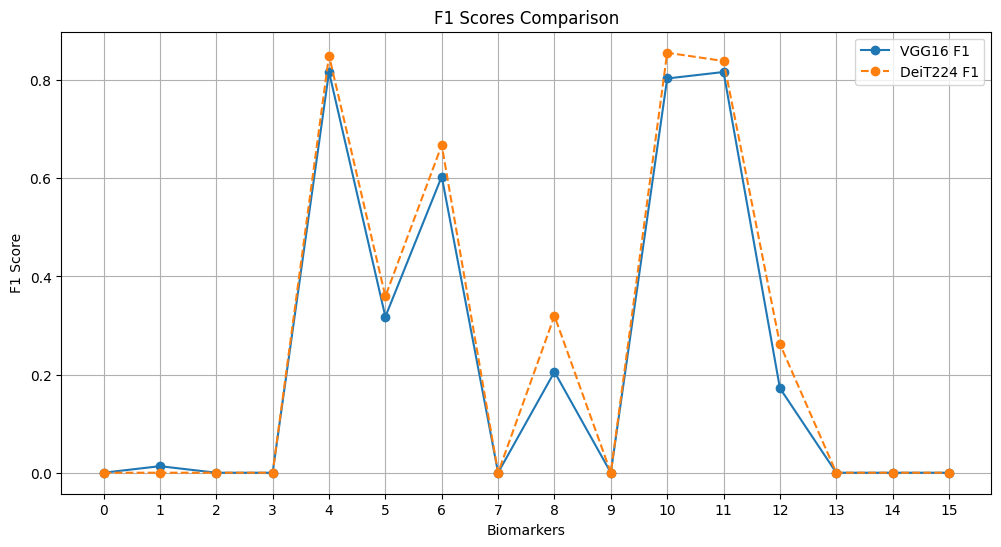

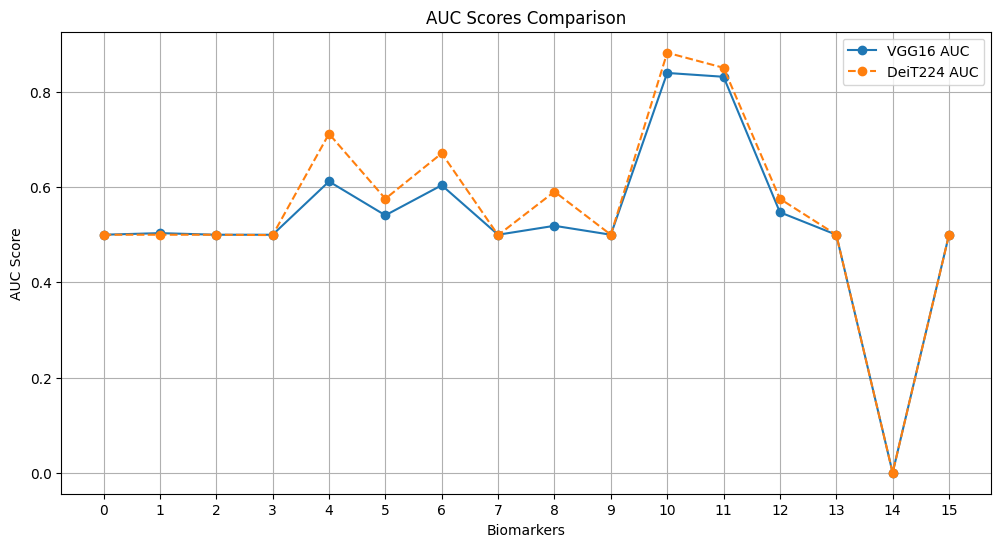

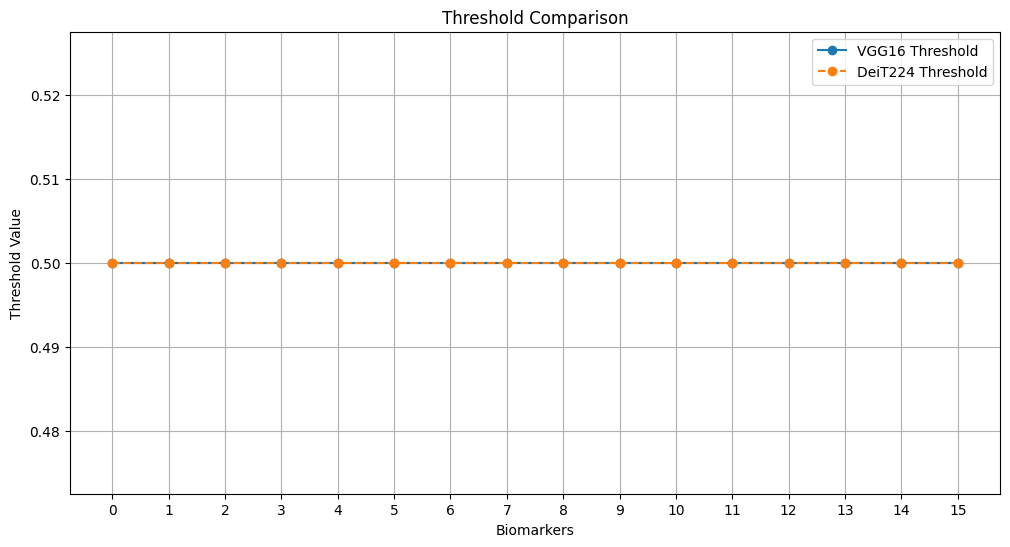

In [88]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load JSON data
with open("vgg16_StratX_BCE_0.5threshold_metrics.json", "r") as f:
    vgg16_metrics = json.load(f)

with open("deit224_0.5_threshold_metrics_stratX_BCE_metrics.json", "r") as f:
    deit224_metrics = json.load(f)

# Extract Biomarker indices
biomarkers = list(range(len(vgg16_metrics)))

# Extract F1, AUC, and Threshold values for both datasets
vgg16_f1 = [vgg16_metrics[f"Biomarker_{i}"]["F1"] for i in biomarkers]
vgg16_auc = [vgg16_metrics[f"Biomarker_{i}"]["AUC"] if not np.isnan(vgg16_metrics[f"Biomarker_{i}"]["AUC"]) else 0 for i in biomarkers]
vgg16_threshold = [vgg16_metrics[f"Biomarker_{i}"]["Threshold"] for i in biomarkers]
deit224_f1 = [deit224_metrics[f"Biomarker_{i}"]["F1"] for i in biomarkers]
deit224_auc = [deit224_metrics[f"Biomarker_{i}"]["AUC"] if not np.isnan(deit224_metrics[f"Biomarker_{i}"]["AUC"]) else 0 for i in biomarkers]
deit224_threshold = [deit224_metrics[f"Biomarker_{i}"]["Threshold"] for i in biomarkers]

# Plot F1 Scores
plt.figure(figsize=(12, 6))
plt.plot(biomarkers, vgg16_f1, label="VGG16 F1", marker="o", linestyle="-")
plt.plot(biomarkers, deit224_f1, label="DeiT224 F1", marker="o", linestyle="--")
plt.title("F1 Scores Comparison")
plt.xlabel("Biomarkers")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.xticks(biomarkers)
plt.show()

# Plot AUC Scores
plt.figure(figsize=(12, 6))
plt.plot(biomarkers, vgg16_auc, label="VGG16 AUC", marker="o", linestyle="-")
plt.plot(biomarkers, deit224_auc, label="DeiT224 AUC", marker="o", linestyle="--")
plt.title("AUC Scores Comparison")
plt.xlabel("Biomarkers")
plt.ylabel("AUC Score")
plt.legend()
plt.grid(True)
plt.xticks(biomarkers)
plt.show()

# Plot Threshold Values
plt.figure(figsize=(12, 6))
plt.plot(biomarkers, vgg16_threshold, label="VGG16 Threshold", marker="o", linestyle="-")
plt.plot(biomarkers, deit224_threshold, label="DeiT224 Threshold", marker="o", linestyle="--")
plt.title("Threshold Comparison")
plt.xlabel("Biomarkers")
plt.ylabel("Threshold Value")
plt.legend()
plt.grid(True)
plt.xticks(biomarkers)
plt.show()



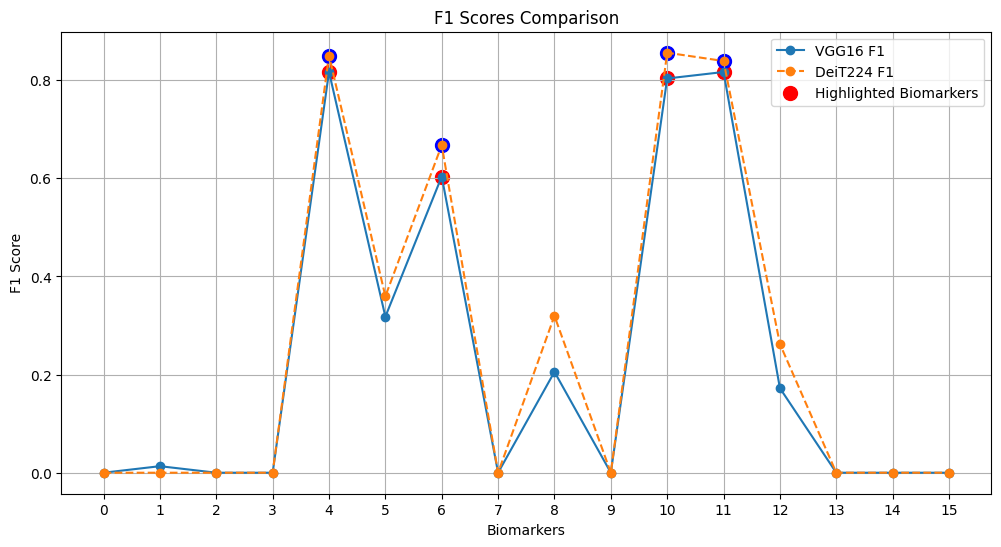

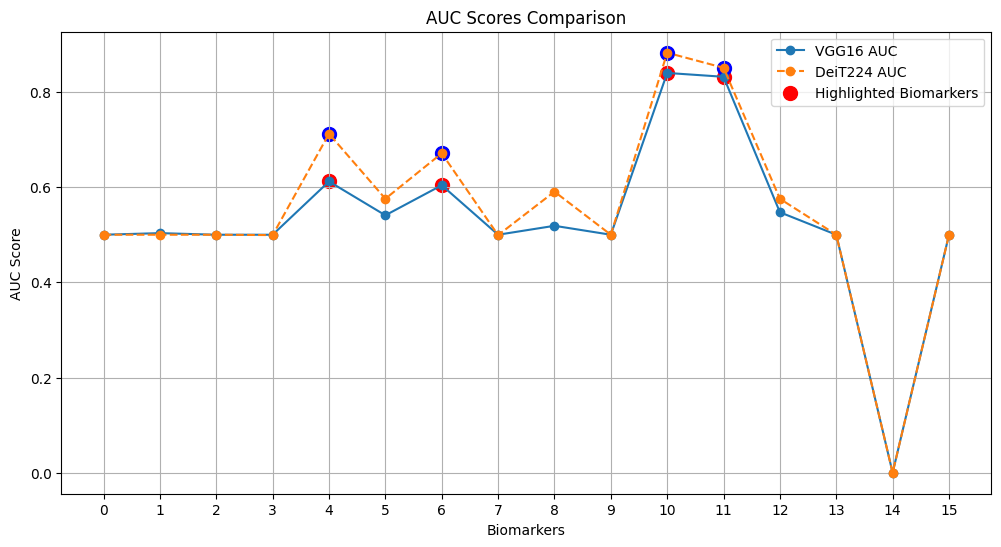

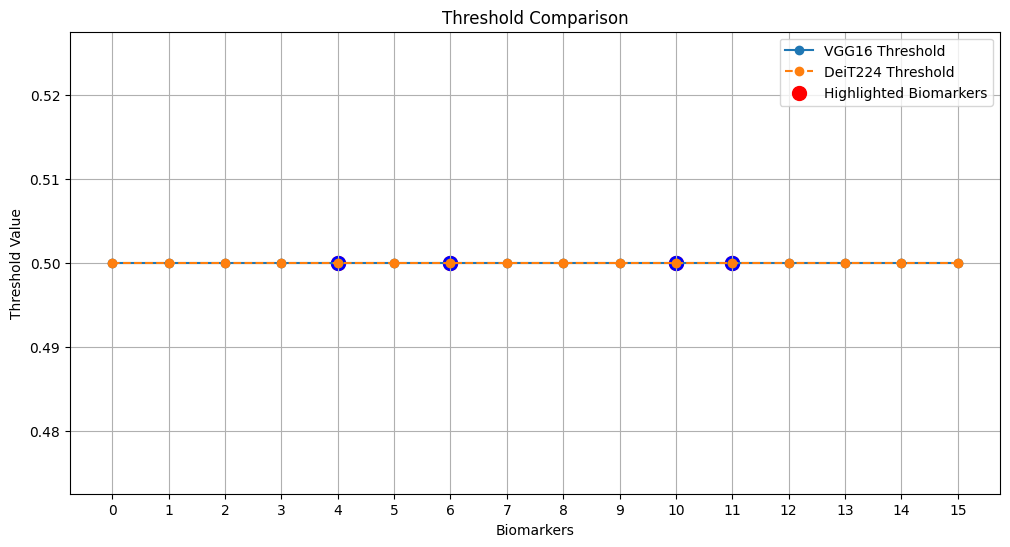

In [89]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load JSON data
with open("vgg16_StratX_BCE_0.5threshold_metrics.json", "r") as f:
    vgg16_metrics = json.load(f)

with open("deit224_0.5_threshold_metrics_stratX_BCE_metrics.json", "r") as f:
    deit224_metrics = json.load(f)

# Extract Biomarker indices
biomarkers = list(range(len(vgg16_metrics)))

# Highlighted Biomarkers
highlight_biomarkers = [4, 6, 10, 11]

# Extract F1, AUC, and Threshold values for both datasets
vgg16_f1 = [vgg16_metrics[f"Biomarker_{i}"]["F1"] for i in biomarkers]
vgg16_auc = [vgg16_metrics[f"Biomarker_{i}"]["AUC"] if not np.isnan(vgg16_metrics[f"Biomarker_{i}"]["AUC"]) else 0 for i in biomarkers]
vgg16_threshold = [vgg16_metrics[f"Biomarker_{i}"]["Threshold"] for i in biomarkers]

deit224_f1 = [deit224_metrics[f"Biomarker_{i}"]["F1"] for i in biomarkers]
deit224_auc = [deit224_metrics[f"Biomarker_{i}"]["AUC"] if not np.isnan(deit224_metrics[f"Biomarker_{i}"]["AUC"]) else 0 for i in biomarkers]
deit224_threshold = [deit224_metrics[f"Biomarker_{i}"]["Threshold"] for i in biomarkers]

# Function to highlight specific biomarkers
def highlight_points(ax, x, y, indices, color, label):
    for idx in indices:
        ax.scatter(x[idx], y[idx], color=color, s=100, label=label if idx == indices[0] else None)  # Add label only once

# Plot F1 Scores
plt.figure(figsize=(12, 6))
plt.plot(biomarkers, vgg16_f1, label="VGG16 F1", marker="o", linestyle="-")
plt.plot(biomarkers, deit224_f1, label="DeiT224 F1", marker="o", linestyle="--")

# Highlight points
ax = plt.gca()
highlight_points(ax, biomarkers, vgg16_f1, highlight_biomarkers, color="red", label="Highlighted Biomarkers")
highlight_points(ax, biomarkers, deit224_f1, highlight_biomarkers, color="blue", label=None)

plt.title("F1 Scores Comparison")
plt.xlabel("Biomarkers")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.xticks(biomarkers)
plt.show()

# Plot AUC Scores
plt.figure(figsize=(12, 6))
plt.plot(biomarkers, vgg16_auc, label="VGG16 AUC", marker="o", linestyle="-")
plt.plot(biomarkers, deit224_auc, label="DeiT224 AUC", marker="o", linestyle="--")

# Highlight points
ax = plt.gca()
highlight_points(ax, biomarkers, vgg16_auc, highlight_biomarkers, color="red", label="Highlighted Biomarkers")
highlight_points(ax, biomarkers, deit224_auc, highlight_biomarkers, color="blue", label=None)

plt.title("AUC Scores Comparison")
plt.xlabel("Biomarkers")
plt.ylabel("AUC Score")
plt.legend()
plt.grid(True)
plt.xticks(biomarkers)
plt.show()

# Plot Threshold Values
plt.figure(figsize=(12, 6))
plt.plot(biomarkers, vgg16_threshold, label="VGG16 Threshold", marker="o", linestyle="-")
plt.plot(biomarkers, deit224_threshold, label="DeiT224 Threshold", marker="o", linestyle="--")

# Highlight points
ax = plt.gca()
highlight_points(ax, biomarkers, vgg16_threshold, highlight_biomarkers, color="red", label="Highlighted Biomarkers")
highlight_points(ax, biomarkers, deit224_threshold, highlight_biomarkers, color="blue", label=None)

plt.title("Threshold Comparison")
plt.xlabel("Biomarkers")
plt.ylabel("Threshold Value")
plt.legend()
plt.grid(True)
plt.xticks(biomarkers)
plt.show()


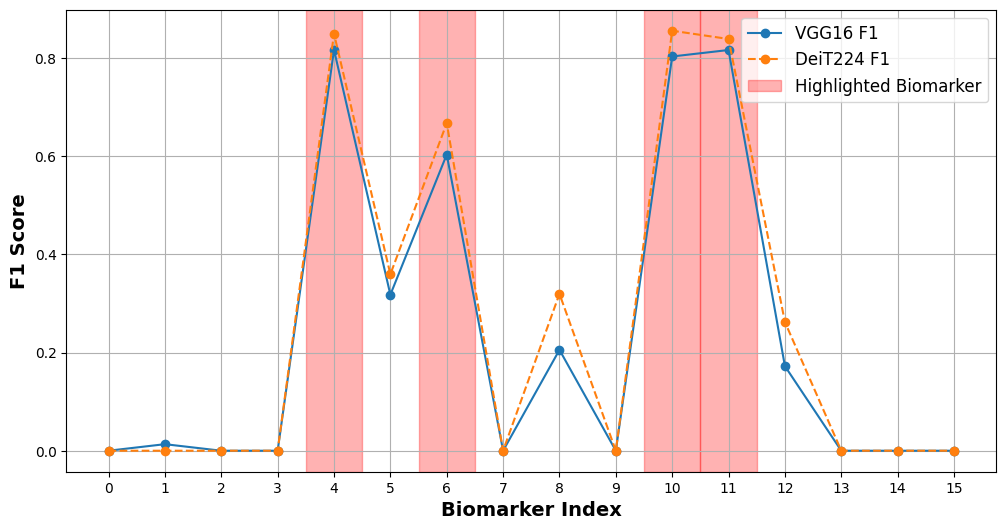

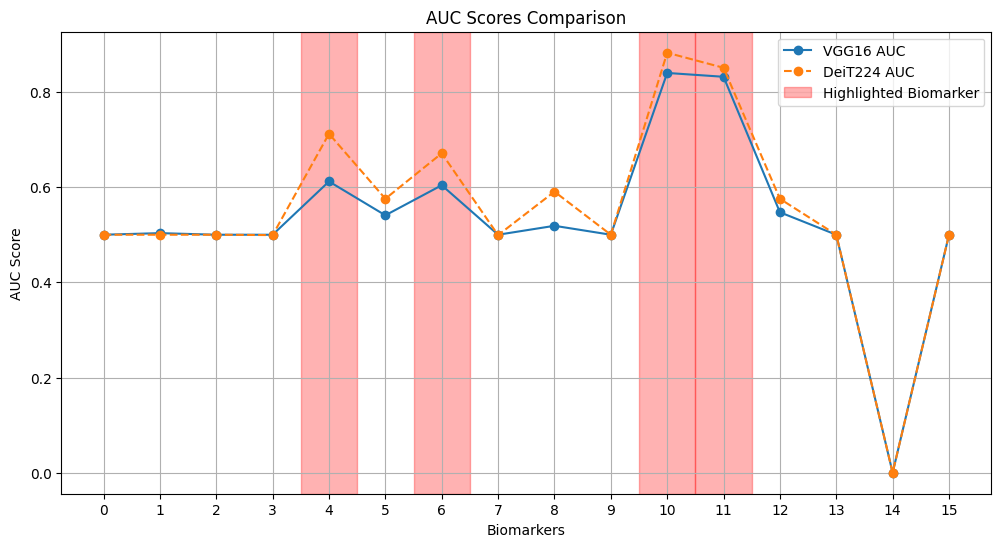

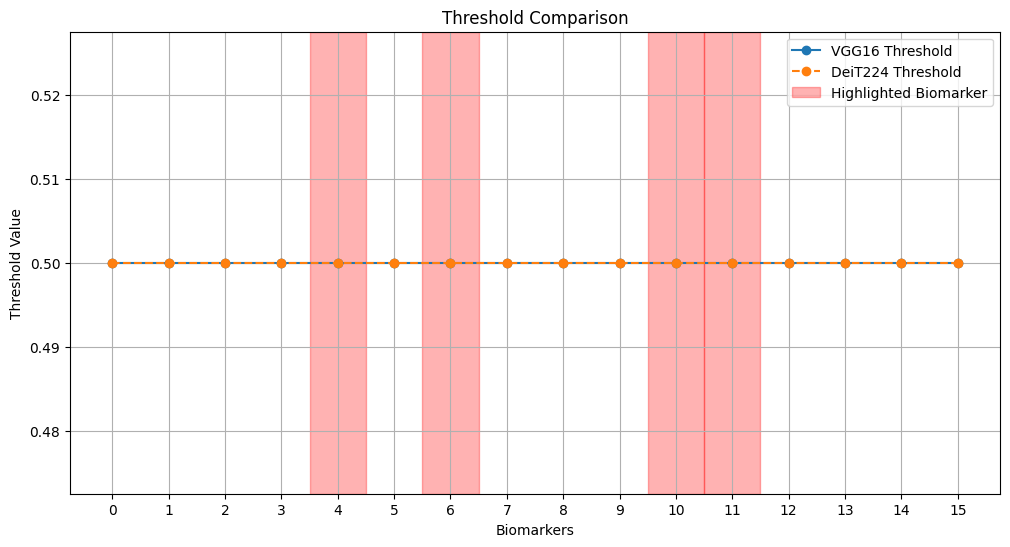

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load JSON data
with open("vgg16_StratX_BCE_0.5threshold_metrics.json", "r") as f:
    vgg16_metrics = json.load(f)

with open("deit224_0.5_threshold_metrics_stratX_BCE_metrics.json", "r") as f:
    deit224_metrics = json.load(f)

# Extract Biomarker indices
biomarkers = list(range(len(vgg16_metrics)))

# Highlighted Biomarkers
highlight_biomarkers = [4, 6, 10, 11]

# Extract F1, AUC, and Threshold values for both datasets
vgg16_f1 = [vgg16_metrics[f"Biomarker_{i}"]["F1"] for i in biomarkers]
vgg16_auc = [vgg16_metrics[f"Biomarker_{i}"]["AUC"] if not np.isnan(vgg16_metrics[f"Biomarker_{i}"]["AUC"]) else 0 for i in biomarkers]
vgg16_threshold = [vgg16_metrics[f"Biomarker_{i}"]["Threshold"] for i in biomarkers]

deit224_f1 = [deit224_metrics[f"Biomarker_{i}"]["F1"] for i in biomarkers]
deit224_auc = [deit224_metrics[f"Biomarker_{i}"]["AUC"] if not np.isnan(deit224_metrics[f"Biomarker_{i}"]["AUC"]) else 0 for i in biomarkers]
deit224_threshold = [deit224_metrics[f"Biomarker_{i}"]["Threshold"] for i in biomarkers]

# Function to highlight specific areas
def highlight_areas(ax, indices, color, alpha=0.3):
    for idx in indices:
        ax.axvspan(idx - 0.5, idx + 0.5, color=color, alpha=alpha, label="Highlighted Biomarker" if idx == indices[0] else None)

# Plot F1 Scores
plt.figure(figsize=(12, 6))
plt.plot(biomarkers, vgg16_f1, label="VGG16 F1", marker="o", linestyle="-")
plt.plot(biomarkers, deit224_f1, label="DeiT224 F1", marker="o", linestyle="--")

# Highlight areas
ax = plt.gca()
highlight_areas(ax, highlight_biomarkers, color="red")

# plt.title("F1 Scores Comparison")
plt.xlabel("Biomarker Index", fontsize=14, fontweight='bold')
plt.ylabel("F1 Score", fontsize=14, fontweight='bold')
plt.legend(fontsize=12)  # Increase legend size
plt.grid(True)
plt.xticks(biomarkers)
plt.savefig("f1_scores_comparison_vgg_deit.png", dpi=300)  # Save as PNG with 300 dpi resolution
plt.show()

# Plot AUC Scores
plt.figure(figsize=(12, 6))
plt.plot(biomarkers, vgg16_auc, label="VGG16 AUC", marker="o", linestyle="-")
plt.plot(biomarkers, deit224_auc, label="DeiT224 AUC", marker="o", linestyle="--")

# Highlight areas
ax = plt.gca()
highlight_areas(ax, highlight_biomarkers, color="red")

plt.title("AUC Scores Comparison")
plt.xlabel("Biomarkers")
plt.ylabel("AUC Score")
plt.legend()
plt.grid(True)
plt.xticks(biomarkers)
plt.show()

# Plot Threshold Values
plt.figure(figsize=(12, 6))
plt.plot(biomarkers, vgg16_threshold, label="VGG16 Threshold", marker="o", linestyle="-")
plt.plot(biomarkers, deit224_threshold, label="DeiT224 Threshold", marker="o", linestyle="--")

# Highlight areas
ax = plt.gca()
highlight_areas(ax, highlight_biomarkers, color="red")

plt.title("Threshold Comparison")
plt.xlabel("Biomarkers")
plt.ylabel("Threshold Value")
plt.legend()
plt.grid(True)
plt.xticks(biomarkers)
plt.show()


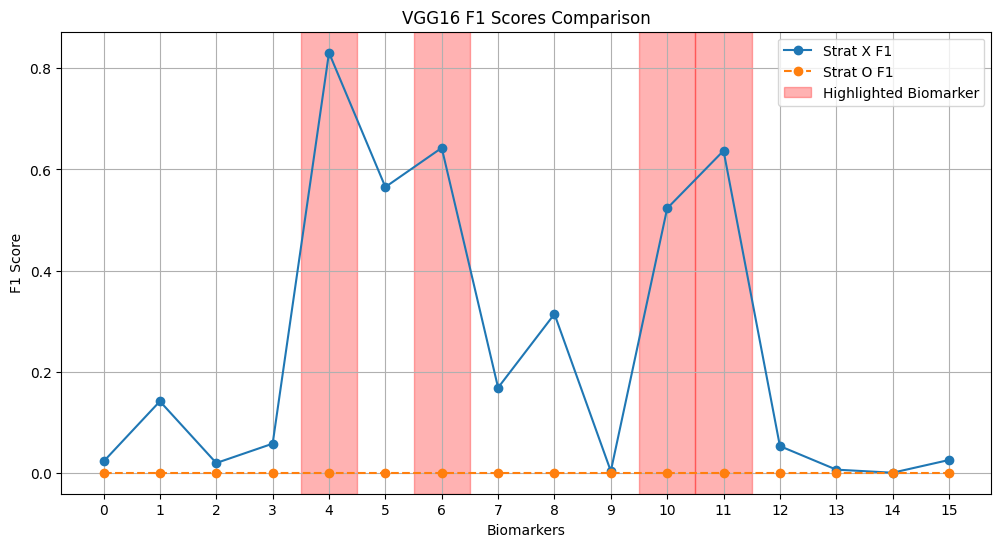

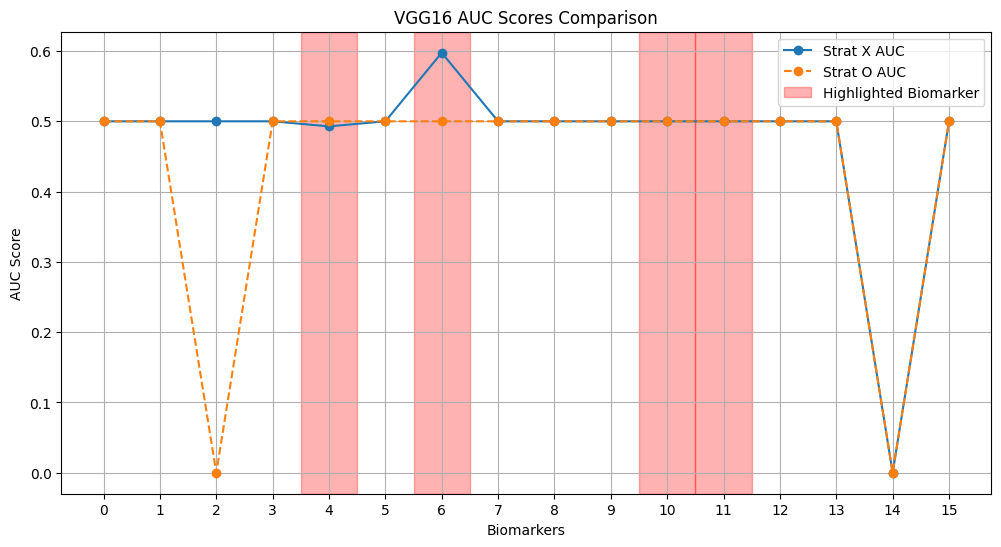

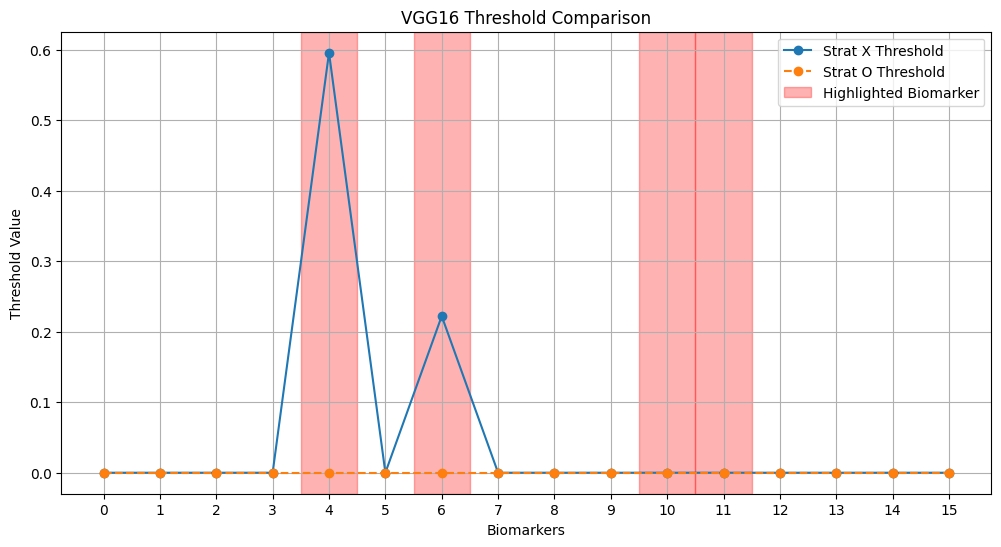

In [101]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load JSON data
with open("vgg16_StratX_Weighted_f1_threshold_metrics.json", "r") as f:
    stratx_metrics = json.load(f)

with open("vgg16_StratO_Weighted_f1_threshold_metrics.json", "r") as f:
    strato_metrics = json.load(f)

# Extract Biomarker indices
biomarkers = list(range(len(vgg16_metrics)))

# Highlighted Biomarkers
highlight_biomarkers = [4, 6, 10, 11]

# Extract F1, AUC, and Threshold values for both datasets
stratx_f1 = [stratx_metrics[f"Biomarker_{i}"]["F1"] for i in biomarkers]
stratx_auc = [stratx_metrics[f"Biomarker_{i}"]["AUC"] if not np.isnan(stratx_metrics[f"Biomarker_{i}"]["AUC"]) else 0 for i in biomarkers]
stratx_threshold = [stratx_metrics[f"Biomarker_{i}"]["Threshold"] for i in biomarkers]

strato_f1 = [strato_metrics[f"Biomarker_{i}"]["F1"] for i in biomarkers]
strato_auc = [strato_metrics[f"Biomarker_{i}"]["AUC"] if not np.isnan(strato_metrics[f"Biomarker_{i}"]["AUC"]) else 0 for i in biomarkers]
strato_threshold = [strato_metrics[f"Biomarker_{i}"]["Threshold"] for i in biomarkers]

# Function to highlight specific areas
def highlight_areas(ax, indices, color, alpha=0.3):
    for idx in indices:
        ax.axvspan(idx - 0.5, idx + 0.5, color=color, alpha=alpha, label="Highlighted Biomarker" if idx == indices[0] else None)

# Plot F1 Scores
plt.figure(figsize=(12, 6))
plt.plot(biomarkers, stratx_f1, label="Strat X F1", marker="o", linestyle="-")
plt.plot(biomarkers, strato_f1, label="Strat O F1", marker="o", linestyle="--")

# Highlight areas
ax = plt.gca()
highlight_areas(ax, highlight_biomarkers, color="red")

plt.title("VGG16 F1 Scores Comparison")
plt.xlabel("Biomarkers")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.xticks(biomarkers)
plt.savefig("f1_scores_comparison_vgg_deit.png", dpi=300)  # Save as PNG with 300 dpi resolution
plt.show()

# Plot AUC Scores
plt.figure(figsize=(12, 6))
plt.plot(biomarkers, stratx_auc, label="Strat X AUC", marker="o", linestyle="-")
plt.plot(biomarkers, strato_auc, label="Strat O AUC", marker="o", linestyle="--")

# Highlight areas
ax = plt.gca()
highlight_areas(ax, highlight_biomarkers, color="red")

plt.title("VGG16 AUC Scores Comparison")
plt.xlabel("Biomarkers")
plt.ylabel("AUC Score")
plt.legend()
plt.grid(True)
plt.xticks(biomarkers)
plt.show()

# Plot Threshold Values
plt.figure(figsize=(12, 6))
plt.plot(biomarkers, stratx_threshold, label="Strat X Threshold", marker="o", linestyle="-")
plt.plot(biomarkers, strato_threshold, label="Strat O Threshold", marker="o", linestyle="--")

# Highlight areas
ax = plt.gca()
highlight_areas(ax, highlight_biomarkers, color="red")

plt.title("VGG16 Threshold Comparison")
plt.xlabel("Biomarkers")
plt.ylabel("Threshold Value")
plt.legend()
plt.grid(True)
plt.xticks(biomarkers)
plt.show()


In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load JSON data
with open("deit224_f1_threshold_metrics_stratX_Weighted_metrics.json", "r") as f:
    stratx_metrics = json.load(f)

with open("deit224_.json", "r") as f:
    strato_metrics = json.load(f)

# Extract Biomarker indices
biomarkers = list(range(len(vgg16_metrics)))

# Highlighted Biomarkers
highlight_biomarkers = [4, 6, 10, 11]

# Extract F1, AUC, and Threshold values for both datasets
stratx_f1 = [stratx_metrics[f"Biomarker_{i}"]["F1"] for i in biomarkers]
stratx_auc = [stratx_metrics[f"Biomarker_{i}"]["AUC"] if not np.isnan(stratx_metrics[f"Biomarker_{i}"]["AUC"]) else 0 for i in biomarkers]
stratx_threshold = [stratx_metrics[f"Biomarker_{i}"]["Threshold"] for i in biomarkers]

strato_f1 = [strato_metrics[f"Biomarker_{i}"]["F1"] for i in biomarkers]
strato_auc = [strato_metrics[f"Biomarker_{i}"]["AUC"] if not np.isnan(strato_metrics[f"Biomarker_{i}"]["AUC"]) else 0 for i in biomarkers]
strato_threshold = [strato_metrics[f"Biomarker_{i}"]["Threshold"] for i in biomarkers]

# Function to highlight specific areas
def highlight_areas(ax, indices, color, alpha=0.3):
    for idx in indices:
        ax.axvspan(idx - 0.5, idx + 0.5, color=color, alpha=alpha, label="Highlighted Biomarker" if idx == indices[0] else None)

# Plot F1 Scores
plt.figure(figsize=(12, 6))
plt.plot(biomarkers, stratx_f1, label="Strat X F1", marker="o", linestyle="-")
plt.plot(biomarkers, strato_f1, label="Strat O F1", marker="o", linestyle="--")

# Highlight areas
ax = plt.gca()
highlight_areas(ax, highlight_biomarkers, color="red")

plt.title("VGG16 F1 Scores Comparison")
plt.xlabel("Biomarkers")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.xticks(biomarkers)
plt.show()

# Plot AUC Scores
plt.figure(figsize=(12, 6))
plt.plot(biomarkers, stratx_auc, label="Strat X AUC", marker="o", linestyle="-")
plt.plot(biomarkers, strato_auc, label="Strat O AUC", marker="o", linestyle="--")

# Highlight areas
ax = plt.gca()
highlight_areas(ax, highlight_biomarkers, color="red")

plt.title("VGG16 AUC Scores Comparison")
plt.xlabel("Biomarkers")
plt.ylabel("AUC Score")
plt.legend()
plt.grid(True)
plt.xticks(biomarkers)
plt.show()

# Plot Threshold Values
plt.figure(figsize=(12, 6))
plt.plot(biomarkers, stratx_threshold, label="Strat X Threshold", marker="o", linestyle="-")
plt.plot(biomarkers, strato_threshold, label="Strat O Threshold", marker="o", linestyle="--")

# Highlight areas
ax = plt.gca()
highlight_areas(ax, highlight_biomarkers, color="red")

plt.title("VGG16 Threshold Comparison")
plt.xlabel("Biomarkers")
plt.ylabel("Threshold Value")
plt.legend()
plt.grid(True)
plt.xticks(biomarkers)
plt.show()


In [ ]:
Strat O X (3 models) with BCE FOCAL

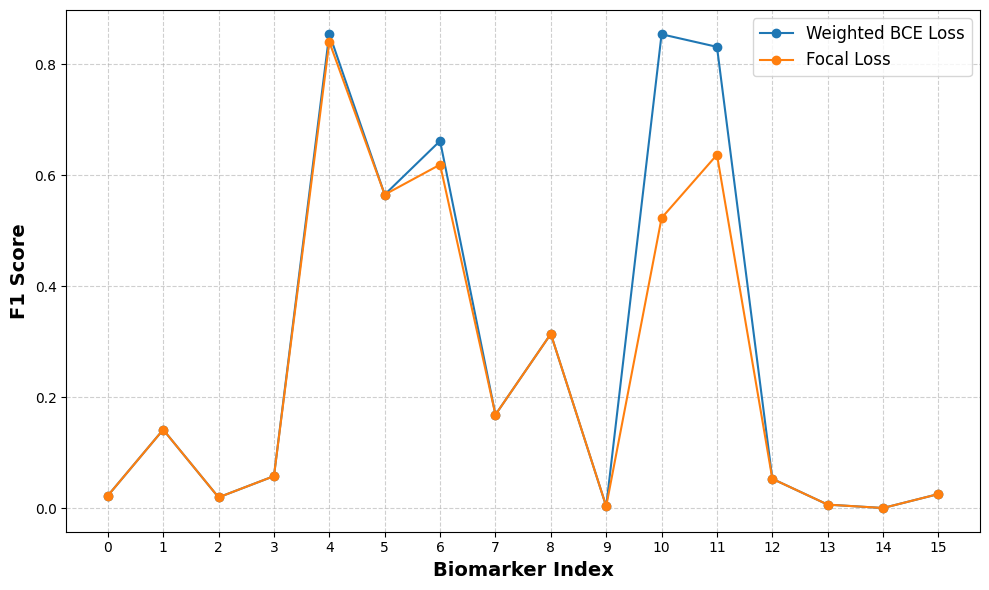

In [125]:
import json
import matplotlib.pyplot as plt

# File paths
files = {
    "Weighted BCE Loss": "deit224_f1_threshold_metrics_stratX_Weighted_metrics.json",
    # "BCE Loss": "deit224_f1_threshold_metrics_stratX_BCE_metrics.json",
    "Focal Loss": "deit224_stratX_focal_metrics.json"
}

# Initialize dictionary to store F1 values
f1_scores = {}

# Parse JSON files and extract F1 values
for loss_type, file_path in files.items():
    with open(file_path, 'r') as f:
        data = json.load(f)
        f1_scores[loss_type] = [data[key]["F1"] for key in data]

# Plot the F1 values
biomarkers = list(range(len(f1_scores["Weighted BCE Loss"])))  # Assuming all files have the same biomarkers

plt.figure(figsize=(10, 6))

for loss_type, scores in f1_scores.items():
    plt.plot(biomarkers, scores, label=loss_type, marker='o')

# Graph labels and legend with increased sizes
# plt.title("Comparison of F1 Scores for Different Loss Styles (Deit)")
plt.xlabel("Biomarker Index", fontsize=14, fontweight='bold')
plt.ylabel("F1 Score", fontsize=14, fontweight='bold')
plt.xticks(biomarkers)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)  # Increase legend size

# Save and show the plot
plt.tight_layout()
plt.savefig("Deit_f1_scores_comparison.png", dpi=300)  # Save as PNG with 300 dpi resolution
plt.show()


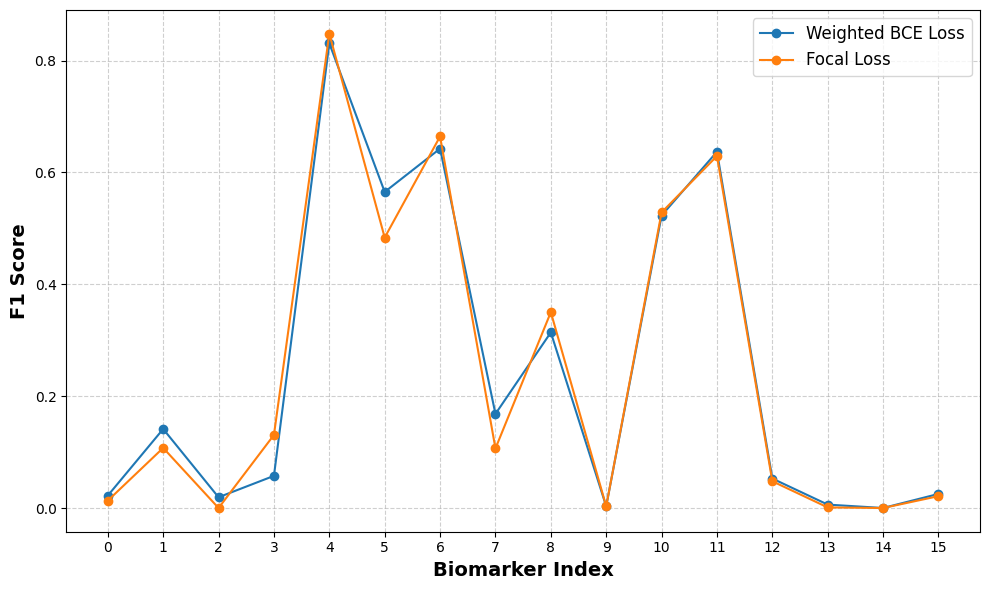

In [126]:
import json
import matplotlib.pyplot as plt

# File paths
files = {
    "Weighted BCE Loss": "vgg16_StratX_Weighted_f1_threshold_metrics.json",
    # "BCE Loss": "vgg16_StratX_BCE_f1_threshold_metrics.json",
    "Focal Loss": "vgg16_StratX_Focal_f1_threshold_metrics.json"
}

# Initialize dictionary to store F1 values
f1_scores = {}

# Parse JSON files and extract F1 values
for loss_type, file_path in files.items():
    with open(file_path, 'r') as f:
        data = json.load(f)
        f1_scores[loss_type] = [data[key]["F1"] for key in data]

# Plot the F1 values
biomarkers = list(range(len(f1_scores["Weighted BCE Loss"])))  # Assuming all files have the same biomarkers

plt.figure(figsize=(10, 6))

for loss_type, scores in f1_scores.items():
    plt.plot(biomarkers, scores, label=loss_type, marker='o')

# Graph labels and legend
# plt.title("Comparison of F1 Scores for Different Loss Styles (VGG16)")
plt.xlabel("Biomarker Index", fontsize=14, fontweight='bold')
plt.ylabel("F1 Score", fontsize=14, fontweight='bold')
plt.xticks(biomarkers)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)  # Increase legend size

# Show the plot
plt.tight_layout()
plt.savefig("VGG16_f1_scores_comparison.png", dpi=300)  # Save as PNG with 300 dpi resolution
plt.show()

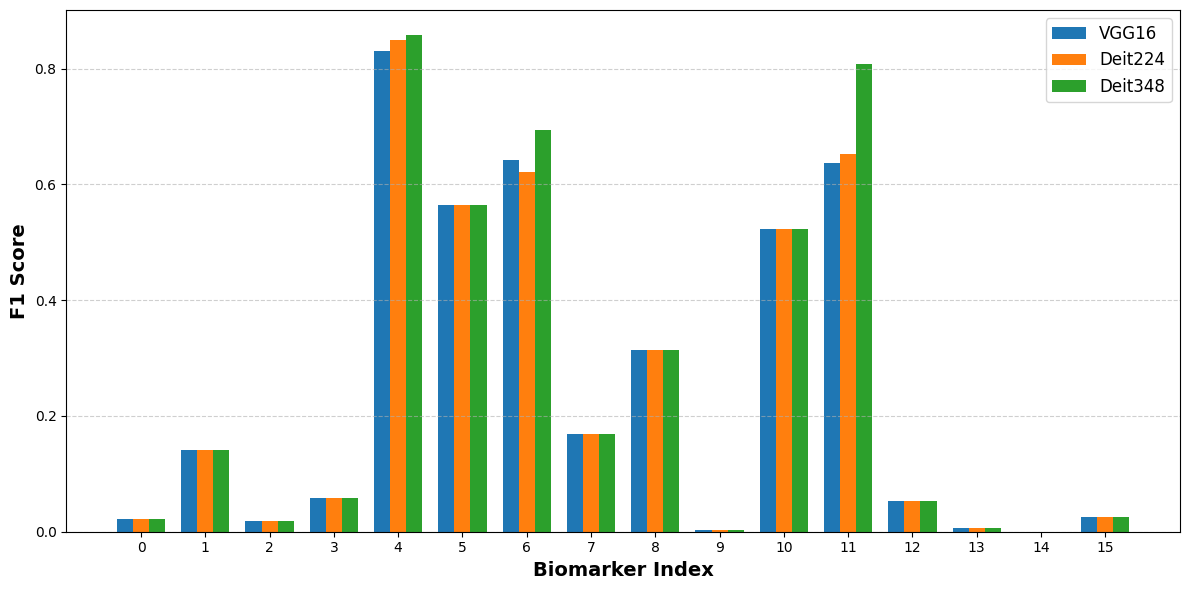

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

# File paths
files = {
    "VGG16": "vgg16_StratX_Weighted_f1_threshold_metrics.json",
    "Deit224": "deit224_stratX_weightedBCE_metrics.json",
    "Deit348": "deit384_f1_threshold_metrics.json"
}

# Initialize dictionary to store F1 values
f1_scores = {}

# Parse JSON files and extract F1 values
for loss_type, file_path in files.items():
    with open(file_path, 'r') as f:
        data = json.load(f)
        f1_scores[loss_type] = [data[key]["F1"] for key in data]

# Prepare data for bar plot
biomarkers = list(range(len(f1_scores["VGG16"])))  # Assuming all files have the same biomarkers
loss_types = list(f1_scores.keys())
bar_width = 0.25
x = np.arange(len(biomarkers))  # X-axis positions for biomarkers

# Plot the bar graph
plt.figure(figsize=(12, 6))

for i, loss_type in enumerate(loss_types):
    plt.bar(x + i * bar_width, f1_scores[loss_type], width=bar_width, label=loss_type)

# Graph labels and legend
# plt.title("Comparison of F1 Scores for Different Models")
plt.xlabel("Biomarker Index", fontsize=14, fontweight='bold')
plt.ylabel("F1 Score", fontsize=14, fontweight='bold')
plt.xticks(x + bar_width, biomarkers)  # Center ticks with the bar groups
plt.grid(True, linestyle='--', alpha=0.6, axis='y')
plt.legend(fontsize=12)  # Increase legend size

# Save and show the plot
plt.tight_layout()
plt.savefig("f1_scores_comparison_bar_graph.png", dpi=300)  # Save as PNG with 300 dpi resolution
plt.show()


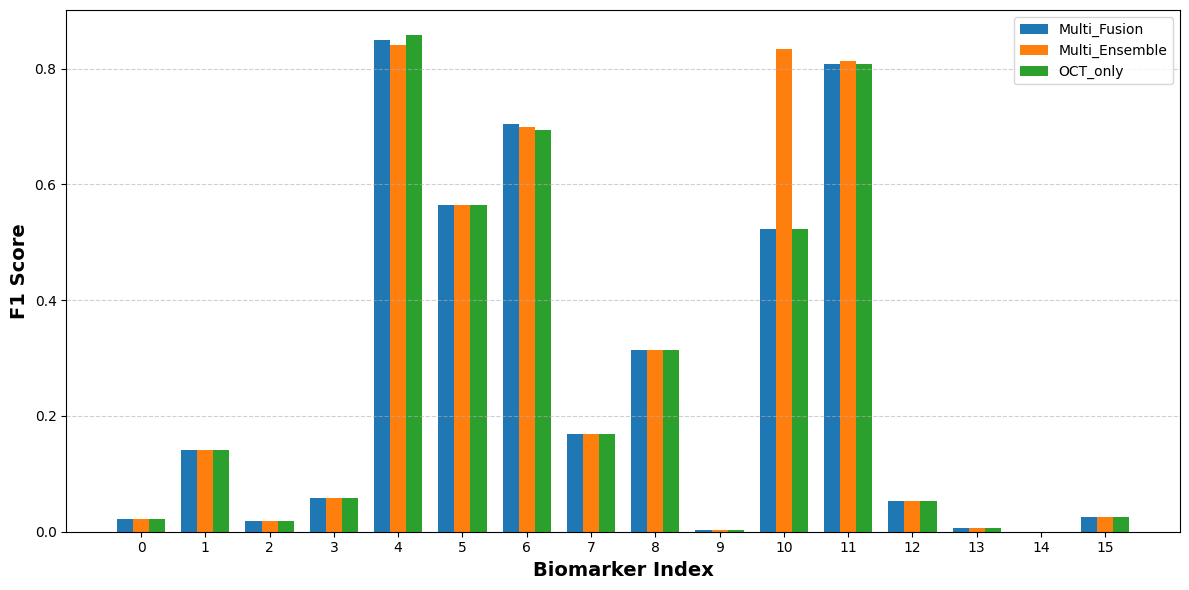

In [128]:
import json
import numpy as np
import matplotlib.pyplot as plt

# File paths
files = {
    "Multi_Fusion": "deit384_fusion_f1_threshold_metrics.json",
    "Multi_Ensemble": "deit384_ensemble_f1_threshold_metrics.json",
    "OCT_only": "deit384_f1_threshold_metrics.json"
}

# Initialize dictionary to store F1 values
f1_scores = {}

# Parse JSON files and extract F1 values
for loss_type, file_path in files.items():
    with open(file_path, 'r') as f:
        data = json.load(f)
        f1_scores[loss_type] = [data[key]["F1"] for key in data]

# Prepare data for bar plot
biomarkers = list(range(len(f1_scores["Multi_Fusion"])))  # Assuming all files have the same biomarkers
loss_types = list(f1_scores.keys())
bar_width = 0.25
x = np.arange(len(biomarkers))  # X-axis positions for biomarkers

# Plot the bar graph
plt.figure(figsize=(12, 6))

for i, loss_type in enumerate(loss_types):
    plt.bar(x + i * bar_width, f1_scores[loss_type], width=bar_width, label=loss_type)

# Graph labels and legend
# plt.title("Comparison of F1 Scores for Different Models")
plt.xlabel("Biomarker Index", fontsize=14, fontweight='bold')
plt.ylabel("F1 Score", fontsize=14, fontweight='bold')
plt.xticks(x + bar_width, biomarkers)  # Center ticks with the bar groups
plt.grid(True, linestyle='--', alpha=0.6, axis='y')
plt.legend()

# Save and show the plot
plt.tight_layout()
plt.savefig("f1_scores_comparison_bar_graph_multi.png", dpi=300)  # Save as PNG with 300 dpi resolution
plt.show()


In [ ]:
import json
import matplotlib.pyplot as plt

# File paths
files = {
    "Weighted BCE Loss": "deit224_f1_threshold_metrics_stratX_Weighted_metrics.json",
    "BCE Loss": "deit224_f1_threshold_metrics_stratX_BCE_metrics.json",
    "Focal Loss": "deit224_stratX_focal_metrics.json"
}

# Initialize dictionary to store F1 values
f1_scores = {}

# Parse JSON files and extract F1 values
for loss_type, file_path in files.items():
    with open(file_path, 'r') as f:
        data = json.load(f)
        f1_scores[loss_type] = [data[key]["F1"] for key in data]

# Plot the F1 values
biomarkers = list(range(len(f1_scores["Weighted BCE Loss"])))  # Assuming all files have the same biomarkers

plt.figure(figsize=(10, 6))

for loss_type, scores in f1_scores.items():
    plt.plot(biomarkers, scores, label=loss_type, marker='o')

# Graph labels and legend
plt.title("Comparison of F1 Scores for Different Loss Styles (Deit)")
plt.xlabel("Biomarker Index")
plt.ylabel("F1 Score")
plt.xticks(biomarkers)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)  # Increase legend size

# Show the plot
plt.tight_layout()
plt.savefig("Deit_f1_scores_comparison.png", dpi=300)  # Save as PNG with 300 dpi resolution
plt.show()

